In [1]:
import numpy as np
import tensorflow as tf

In [2]:
import os
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/datasets/aml/archive_occular_disease.zip -d /content/drive/MyDrive/datasets/aml

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/datasets/aml/archive_occular_disease/ODIR-5K/ODIR-5K/Training Images/4237_right.jpg  
  inflating: /content/drive/MyDrive/datasets/aml/__MACOSX/archive_occular_disease/ODIR-5K/ODIR-5K/Training Images/._4237_right.jpg  
  inflating: /content/drive/MyDrive/datasets/aml/archive_occular_disease/ODIR-5K/ODIR-5K/Training Images/107_left.jpg  
  inflating: /content/drive/MyDrive/datasets/aml/__MACOSX/archive_occular_disease/ODIR-5K/ODIR-5K/Training Images/._107_left.jpg  
  inflating: /content/drive/MyDrive/datasets/aml/archive_occular_disease/ODIR-5K/ODIR-5K/Training Images/361_left.jpg  
  inflating: /content/drive/MyDrive/datasets/aml/__MACOSX/archive_occular_disease/ODIR-5K/ODIR-5K/Training Images/._361_left.jpg  
  inflating: /content/drive/MyDrive/datasets/aml/archive_occular_disease/ODIR-5K/ODIR-5K/Training Images/816_right.jpg  
  inflating: /content/drive/MyDrive/datasets/aml/__MACOSX/archive_occul

In [6]:
!cp /content/drive/MyDrive/datasets/aml/archive_occular_disease/preprocessed_images -r "/content/"

In [8]:
#Reading full_df.csv
df= pd.read_csv("/content/drive/MyDrive/datasets/aml/archive_occular_disease/full_df.csv")

df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [9]:
#Creating a new df with just two columns, i.e. the filename and the associated label
new_df = df[['filename', 'labels']]
new_df.head()

#Checking how many labels for each class
print(new_df['labels'].value_counts())

['N']    2873
['D']    1608
['O']     708
['C']     293
['G']     284
['A']     266
['M']     232
['H']     128
Name: labels, dtype: int64


In [10]:
#Jumbling the entries to randomize it
new_df = new_df.sample(frac=1,random_state=10)
new_df.reset_index(drop=True,inplace=True)
new_df.head()

,filename,labels
0,4365_right.jpg,['D']
1,2566_right.jpg,['N']
2,145_left.jpg,['M']
3,2452_right.jpg,['N']
4,4286_right.jpg,['D']


In [11]:
#Splitting the dataset into 20% testing and the rest 80% to be split later for training and validation
from sklearn.model_selection import train_test_split

training_df, testing_df = train_test_split(new_df, test_size=0.2)
training_df.reset_index(drop=True,inplace=True)
testing_df.reset_index(drop=True,inplace=True)
print(training_df.head())
print(testing_df.head())

         filename labels
0    161_left.jpg  ['D']
1  3067_right.jpg  ['N']
2   1008_left.jpg  ['N']
3    969_left.jpg  ['O']
4  3391_right.jpg  ['N']
         filename labels
0    750_left.jpg  ['C']
1  1276_right.jpg  ['G']
2   1109_left.jpg  ['N']
3  2102_right.jpg  ['C']
4   3269_left.jpg  ['N']


In [12]:
#Using ImageDataGenerator for data augmentation i.e. transform the data to increase the size and to generalize better later.
train_datagen= tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1/255,
                featurewise_center=True,
                rotation_range=45,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                validation_split=0.2,
            )

#We don't need to do so much data augmentation for testing images. We'll just rescale them.
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1/255
            )




In [13]:
#In the train_datagen we mentioned the validation split to be 20%, so the data is divided accordingly
#We are taking the target_size as 224x224 for VGG16 architecture
train_gen=train_datagen.flow_from_dataframe(
            dataframe=training_df,
            directory='/content/preprocessed_images',
            x_col='filename',
            y_col='labels',
            subset='training',
            batch_size=32,
            shuffle=True,
            class_mode='categorical',
            target_size=(224, 224),
            )


validation_gen=train_datagen.flow_from_dataframe(
            dataframe=training_df,
            directory='/content/preprocessed_images',
            x_col="filename",
            y_col="labels",
            subset="validation",
            batch_size=32,
            shuffle=True,
            class_mode="categorical",
            target_size=(224,224)
            )

Found 4091 validated image filenames belonging to 8 classes.
Found 1022 validated image filenames belonging to 8 classes.


In [14]:
#Getting testing images ready
test_gen=test_datagen.flow_from_dataframe(
dataframe=testing_df,
directory='/content/preprocessed_images',
x_col="filename",
y_col="labels",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(224,224))

Found 1279 validated image filenames belonging to 8 classes.


In [15]:
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

vgg = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),weights='imagenet',include_top=False)
vgg.trainable = False

f = Flatten()(vgg.output)
d_1 = Dense(units=128,activation='relu')(f)
d_2 = Dense(units=128, activation='relu')(d_1)
outputs = Dense(8, activation='softmax')(d_2)
model = Model(inputs = vgg.input, outputs = outputs)
model.compile(optimizer=Adam(learning_rate = 0.00001),loss='categorical_crossentropy',metrics=['accuracy'])


model.summary()
     

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
model_checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq=1)

In [18]:
#Taking a batch size of 32 for this, as mentioned in the train_gen and validation_gen above. That's why we are taking steps per epoch and val
#Steps per epoch essentially tells us how many batches of samples would it take for 1 epoch, so it's calculated by the number of samples/batch size. Similarly for validation_steps
model_fit = model.fit(train_gen,
                        steps_per_epoch=train_gen.samples//32,
                        validation_data=validation_gen,
                        validation_steps=validation_gen.samples // 32,
                        epochs=30,
                        shuffle=True,
                        callbacks=[model_checkpoint]
            )

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/30


  1/127 [..............................] - ETA: 27:40 - loss: 2.6388 - accuracy: 0.0312

  2/127 [..............................] - ETA: 14s - loss: 2.6042 - accuracy: 0.0625  

  3/127 [..............................] - ETA: 35s - loss: 2.6186 - accuracy: 0.0625

  4/127 [..............................] - ETA: 42s - loss: 2.5948 - accuracy: 0.0625

  5/127 [>.............................] - ETA: 45s - loss: 2.5890 - accuracy: 0.0562

  6/127 [>.............................] - ETA: 48s - loss: 2.5459 - accuracy: 0.0573

  7/127 [>.............................] - ETA: 53s - loss: 2.5089 - accuracy: 0.0625

  8/127 [>.............................] - ETA: 57s - loss: 2.4773 - accuracy: 0.0547

  9/127 [=>............................] - ETA: 1:00 - loss: 2.4421 - accuracy: 0.0590

 10/127 [=>............................] - ETA: 1:02 - loss: 2.4181 - accuracy: 0.0531

 11/127 [=>............................] - ETA: 1:03 - loss: 2.3843 - accuracy: 0.0568

 12/127 [=>............................] - ETA: 1:02 - loss: 2.3503 - accuracy: 0.0729

 13/127 [==>...........................] - ETA: 1:01 - loss: 2.3284 - accuracy: 0.0841

 14/127 [==>...........................] - ETA: 1:00 - loss: 2.3072 - accuracy: 0.0960

 15/127 [==>...........................] - ETA: 58s - loss: 2.2987 - accuracy: 0.1021 

 16/127 [==>...........................] - ETA: 57s - loss: 2.2828 - accuracy: 0.1191

 17/127 [===>..........................] - ETA: 56s - loss: 2.2617 - accuracy: 0.1434

 18/127 [===>..........................] - ETA: 56s - loss: 2.2440 - accuracy: 0.1580

 19/127 [===>..........................] - ETA: 55s - loss: 2.2326 - accuracy: 0.1661

 20/127 [===>..........................] - ETA: 54s - loss: 2.2152 - accuracy: 0.1797

 21/127 [===>..........................] - ETA: 53s - loss: 2.1971 - accuracy: 0.1964

 22/127 [====>.........................] - ETA: 52s - loss: 2.1751 - accuracy: 0.2145

 23/127 [====>.........................] - ETA: 52s - loss: 2.1596 - accuracy: 0.2255

 24/127 [====>.........................] - ETA: 51s - loss: 2.1465 - accuracy: 0.2344

 25/127 [====>.........................] - ETA: 50s - loss: 2.1287 - accuracy: 0.2463

 26/127 [=====>........................] - ETA: 50s - loss: 2.1179 - accuracy: 0.2548

 27/127 [=====>........................] - ETA: 49s - loss: 2.1082 - accuracy: 0.2569

 28/127 [=====>........................] - ETA: 48s - loss: 2.0969 - accuracy: 0.2634

 29/127 [=====>........................] - ETA: 48s - loss: 2.0875 - accuracy: 0.2672

 30/127 [======>.......................] - ETA: 47s - loss: 2.0735 - accuracy: 0.2771

 31/127 [======>.......................] - ETA: 46s - loss: 2.0638 - accuracy: 0.2843

 32/127 [======>.......................] - ETA: 46s - loss: 2.0568 - accuracy: 0.2881

 33/127 [======>.......................] - ETA: 45s - loss: 2.0491 - accuracy: 0.2907

 34/127 [=======>......................] - ETA: 46s - loss: 2.0432 - accuracy: 0.2932

 35/127 [=======>......................] - ETA: 46s - loss: 2.0314 - accuracy: 0.3009

 36/127 [=======>......................] - ETA: 46s - loss: 2.0232 - accuracy: 0.3047

 37/127 [=======>......................] - ETA: 46s - loss: 2.0150 - accuracy: 0.3108

 38/127 [=======>......................] - ETA: 46s - loss: 2.0052 - accuracy: 0.3150

 39/127 [========>.....................] - ETA: 45s - loss: 1.9948 - accuracy: 0.3205

 40/127 [========>.....................] - ETA: 44s - loss: 1.9868 - accuracy: 0.3227

 41/127 [========>.....................] - ETA: 44s - loss: 1.9779 - accuracy: 0.3277

 42/127 [========>.....................] - ETA: 43s - loss: 1.9746 - accuracy: 0.3274

 43/127 [=========>....................] - ETA: 43s - loss: 1.9672 - accuracy: 0.3307

 44/127 [=========>....................] - ETA: 42s - loss: 1.9659 - accuracy: 0.3303

 45/127 [=========>....................] - ETA: 41s - loss: 1.9646 - accuracy: 0.3306

 46/127 [=========>....................] - ETA: 41s - loss: 1.9604 - accuracy: 0.3308

 47/127 [==========>...................] - ETA: 40s - loss: 1.9539 - accuracy: 0.3331

 48/127 [==========>...................] - ETA: 40s - loss: 1.9500 - accuracy: 0.3346

 49/127 [==========>...................] - ETA: 39s - loss: 1.9465 - accuracy: 0.3348

 50/127 [==========>...................] - ETA: 38s - loss: 1.9425 - accuracy: 0.3338

 51/127 [===========>..................] - ETA: 38s - loss: 1.9398 - accuracy: 0.3346

 52/127 [===========>..................] - ETA: 37s - loss: 1.9352 - accuracy: 0.3359

 53/127 [===========>..................] - ETA: 37s - loss: 1.9279 - accuracy: 0.3390

 54/127 [===========>..................] - ETA: 36s - loss: 1.9239 - accuracy: 0.3409

 55/127 [===========>..................] - ETA: 36s - loss: 1.9162 - accuracy: 0.3443

 56/127 [============>.................] - ETA: 35s - loss: 1.9110 - accuracy: 0.3465

 57/127 [============>.................] - ETA: 35s - loss: 1.9090 - accuracy: 0.3476

 58/127 [============>.................] - ETA: 34s - loss: 1.9029 - accuracy: 0.3513

 59/127 [============>.................] - ETA: 33s - loss: 1.8960 - accuracy: 0.3533

 60/127 [=============>................] - ETA: 33s - loss: 1.8911 - accuracy: 0.3542

 61/127 [=============>................] - ETA: 33s - loss: 1.8897 - accuracy: 0.3555

 62/127 [=============>................] - ETA: 32s - loss: 1.8853 - accuracy: 0.3579

 63/127 [=============>................] - ETA: 32s - loss: 1.8819 - accuracy: 0.3591

 64/127 [==============>...............] - ETA: 32s - loss: 1.8773 - accuracy: 0.3608

 65/127 [==============>...............] - ETA: 32s - loss: 1.8703 - accuracy: 0.3639

 66/127 [==============>...............] - ETA: 31s - loss: 1.8725 - accuracy: 0.3627

 67/127 [==============>...............] - ETA: 30s - loss: 1.8708 - accuracy: 0.3638

 68/127 [===============>..............] - ETA: 30s - loss: 1.8677 - accuracy: 0.3640

 69/127 [===============>..............] - ETA: 29s - loss: 1.8635 - accuracy: 0.3646

 70/127 [===============>..............] - ETA: 29s - loss: 1.8619 - accuracy: 0.3634

 71/127 [===============>..............] - ETA: 28s - loss: 1.8573 - accuracy: 0.3658

 72/127 [================>.............] - ETA: 28s - loss: 1.8548 - accuracy: 0.3663

 73/127 [================>.............] - ETA: 27s - loss: 1.8507 - accuracy: 0.3673

 74/127 [================>.............] - ETA: 27s - loss: 1.8452 - accuracy: 0.3708

 75/127 [================>.............] - ETA: 26s - loss: 1.8433 - accuracy: 0.3708

 76/127 [================>.............] - ETA: 25s - loss: 1.8421 - accuracy: 0.3709

 77/127 [=================>............] - ETA: 25s - loss: 1.8374 - accuracy: 0.3718

 78/127 [=================>............] - ETA: 24s - loss: 1.8327 - accuracy: 0.3734

 79/127 [=================>............] - ETA: 24s - loss: 1.8269 - accuracy: 0.3758

 80/127 [=================>............] - ETA: 23s - loss: 1.8230 - accuracy: 0.3758

 81/127 [==================>...........] - ETA: 23s - loss: 1.8183 - accuracy: 0.3777

 82/127 [==================>...........] - ETA: 22s - loss: 1.8121 - accuracy: 0.3811

 83/127 [==================>...........] - ETA: 22s - loss: 1.8080 - accuracy: 0.3833

 84/127 [==================>...........] - ETA: 21s - loss: 1.8071 - accuracy: 0.3832

 85/127 [===================>..........] - ETA: 21s - loss: 1.8043 - accuracy: 0.3827

 86/127 [===================>..........] - ETA: 20s - loss: 1.8031 - accuracy: 0.3819

 87/127 [===================>..........] - ETA: 20s - loss: 1.7993 - accuracy: 0.3836

 88/127 [===================>..........] - ETA: 19s - loss: 1.7968 - accuracy: 0.3832

 89/127 [====================>.........] - ETA: 19s - loss: 1.7960 - accuracy: 0.3834

 90/127 [====================>.........] - ETA: 18s - loss: 1.7916 - accuracy: 0.3844

 91/127 [====================>.........] - ETA: 18s - loss: 1.7903 - accuracy: 0.3846

 92/127 [====================>.........] - ETA: 18s - loss: 1.7864 - accuracy: 0.3849

 93/127 [====================>.........] - ETA: 17s - loss: 1.7847 - accuracy: 0.3847

 94/127 [=====================>........] - ETA: 16s - loss: 1.7815 - accuracy: 0.3866

 95/127 [=====================>........] - ETA: 16s - loss: 1.7774 - accuracy: 0.3878

 96/127 [=====================>........] - ETA: 15s - loss: 1.7763 - accuracy: 0.3874

 97/127 [=====================>........] - ETA: 15s - loss: 1.7729 - accuracy: 0.3895

 98/127 [======================>.......] - ETA: 14s - loss: 1.7688 - accuracy: 0.3913

 99/127 [======================>.......] - ETA: 14s - loss: 1.7655 - accuracy: 0.3924

100/127 [======================>.......] - ETA: 13s - loss: 1.7658 - accuracy: 0.3919

101/127 [======================>.......] - ETA: 13s - loss: 1.7641 - accuracy: 0.3926

102/127 [=======================>......] - ETA: 12s - loss: 1.7644 - accuracy: 0.3915

103/127 [=======================>......] - ETA: 12s - loss: 1.7629 - accuracy: 0.3917

104/127 [=======================>......] - ETA: 11s - loss: 1.7643 - accuracy: 0.3909

105/127 [=======================>......] - ETA: 11s - loss: 1.7621 - accuracy: 0.3914

106/127 [========================>.....] - ETA: 10s - loss: 1.7594 - accuracy: 0.3930

107/127 [========================>.....] - ETA: 10s - loss: 1.7588 - accuracy: 0.3940

108/127 [========================>.....] - ETA: 9s - loss: 1.7593 - accuracy: 0.3941 

109/127 [========================>.....] - ETA: 9s - loss: 1.7591 - accuracy: 0.3933

110/127 [========================>.....] - ETA: 8s - loss: 1.7584 - accuracy: 0.3935

111/127 [=========================>....] - ETA: 8s - loss: 1.7571 - accuracy: 0.3941

112/127 [=========================>....] - ETA: 7s - loss: 1.7546 - accuracy: 0.3954

113/127 [=========================>....] - ETA: 7s - loss: 1.7551 - accuracy: 0.3944

114/127 [=========================>....] - ETA: 6s - loss: 1.7530 - accuracy: 0.3947

115/127 [==========================>...] - ETA: 6s - loss: 1.7500 - accuracy: 0.3954

116/127 [==========================>...] - ETA: 5s - loss: 1.7477 - accuracy: 0.3957

117/127 [==========================>...] - ETA: 5s - loss: 1.7471 - accuracy: 0.3956

118/127 [==========================>...] - ETA: 4s - loss: 1.7457 - accuracy: 0.3964

119/127 [===========================>..] - ETA: 4s - loss: 1.7434 - accuracy: 0.3976

120/127 [===========================>..] - ETA: 3s - loss: 1.7410 - accuracy: 0.3990

121/127 [===========================>..] - ETA: 3s - loss: 1.7387 - accuracy: 0.4006

122/127 [===========================>..] - ETA: 2s - loss: 1.7386 - accuracy: 0.4006

123/127 [============================>.] - ETA: 2s - loss: 1.7382 - accuracy: 0.4004

124/127 [============================>.] - ETA: 1s - loss: 1.7370 - accuracy: 0.4002

125/127 [============================>.] - ETA: 1s - loss: 1.7337 - accuracy: 0.4013

126/127 [============================>.] - ETA: 0s - loss: 1.7312 - accuracy: 0.4020

127/127 [==============================] - 100s 690ms/step - loss: 1.7290 - accuracy: 0.4033 - val_loss: 1.5625 - val_accuracy: 0.4425
Epoch 2/30


  1/127 [..............................] - ETA: 1:19 - loss: 1.4557 - accuracy: 0.4375

  2/127 [..............................] - ETA: 57s - loss: 1.5079 - accuracy: 0.4062 

  3/127 [..............................] - ETA: 56s - loss: 1.5278 - accuracy: 0.4167

  4/127 [..............................] - ETA: 55s - loss: 1.4858 - accuracy: 0.3984

  5/127 [>.............................] - ETA: 55s - loss: 1.5095 - accuracy: 0.4125

  6/127 [>.............................] - ETA: 58s - loss: 1.5637 - accuracy: 0.3854

  7/127 [>.............................] - ETA: 1:03 - loss: 1.5934 - accuracy: 0.3929

  8/127 [>.............................] - ETA: 1:06 - loss: 1.5805 - accuracy: 0.3945

  9/127 [=>............................] - ETA: 1:07 - loss: 1.5622 - accuracy: 0.4132

 10/127 [=>............................] - ETA: 1:09 - loss: 1.5575 - accuracy: 0.4219

 11/127 [=>............................] - ETA: 1:09 - loss: 1.5361 - accuracy: 0.4233

 12/127 [=>............................] - ETA: 1:07 - loss: 1.5722 - accuracy: 0.4115

 13/127 [==>...........................] - ETA: 1:05 - loss: 1.5593 - accuracy: 0.4231

 14/127 [==>...........................] - ETA: 1:04 - loss: 1.5569 - accuracy: 0.4263

 15/127 [==>...........................] - ETA: 1:02 - loss: 1.5614 - accuracy: 0.4250

 16/127 [==>...........................] - ETA: 1:01 - loss: 1.5632 - accuracy: 0.4219

 17/127 [===>..........................] - ETA: 1:00 - loss: 1.5716 - accuracy: 0.4210

 18/127 [===>..........................] - ETA: 59s - loss: 1.5682 - accuracy: 0.4253 

 19/127 [===>..........................] - ETA: 58s - loss: 1.5759 - accuracy: 0.4227

 20/127 [===>..........................] - ETA: 57s - loss: 1.5695 - accuracy: 0.4297

 21/127 [===>..........................] - ETA: 56s - loss: 1.5765 - accuracy: 0.4286

 22/127 [====>.........................] - ETA: 55s - loss: 1.5704 - accuracy: 0.4318

 23/127 [====>.........................] - ETA: 54s - loss: 1.5666 - accuracy: 0.4375

 24/127 [====>.........................] - ETA: 53s - loss: 1.5569 - accuracy: 0.4427

 25/127 [====>.........................] - ETA: 53s - loss: 1.5606 - accuracy: 0.4425

 26/127 [=====>........................] - ETA: 52s - loss: 1.5671 - accuracy: 0.4399

 27/127 [=====>........................] - ETA: 51s - loss: 1.5703 - accuracy: 0.4410

 28/127 [=====>........................] - ETA: 50s - loss: 1.5773 - accuracy: 0.4353

 29/127 [=====>........................] - ETA: 50s - loss: 1.5849 - accuracy: 0.4321

 30/127 [======>.......................] - ETA: 49s - loss: 1.5811 - accuracy: 0.4354

 31/127 [======>.......................] - ETA: 48s - loss: 1.5741 - accuracy: 0.4375

 32/127 [======>.......................] - ETA: 48s - loss: 1.5624 - accuracy: 0.4434

 33/127 [======>.......................] - ETA: 48s - loss: 1.5606 - accuracy: 0.4441

 34/127 [=======>......................] - ETA: 48s - loss: 1.5563 - accuracy: 0.4458

 35/127 [=======>......................] - ETA: 48s - loss: 1.5573 - accuracy: 0.4420

 36/127 [=======>......................] - ETA: 48s - loss: 1.5573 - accuracy: 0.4427

 37/127 [=======>......................] - ETA: 48s - loss: 1.5624 - accuracy: 0.4417

 38/127 [=======>......................] - ETA: 47s - loss: 1.5594 - accuracy: 0.4449

 39/127 [========>.....................] - ETA: 47s - loss: 1.5588 - accuracy: 0.4455

 40/127 [========>.....................] - ETA: 46s - loss: 1.5524 - accuracy: 0.4492

 41/127 [========>.....................] - ETA: 45s - loss: 1.5487 - accuracy: 0.4505

 42/127 [========>.....................] - ETA: 44s - loss: 1.5565 - accuracy: 0.4464

 43/127 [=========>....................] - ETA: 44s - loss: 1.5567 - accuracy: 0.4448

 44/127 [=========>....................] - ETA: 43s - loss: 1.5543 - accuracy: 0.4439

 45/127 [=========>....................] - ETA: 42s - loss: 1.5533 - accuracy: 0.4472

 46/127 [=========>....................] - ETA: 42s - loss: 1.5519 - accuracy: 0.4477

 47/127 [==========>...................] - ETA: 41s - loss: 1.5527 - accuracy: 0.4468

 48/127 [==========>...................] - ETA: 41s - loss: 1.5518 - accuracy: 0.4473

 49/127 [==========>...................] - ETA: 40s - loss: 1.5499 - accuracy: 0.4483

 50/127 [==========>...................] - ETA: 39s - loss: 1.5539 - accuracy: 0.4456

 51/127 [===========>..................] - ETA: 39s - loss: 1.5524 - accuracy: 0.4473

 52/127 [===========>..................] - ETA: 38s - loss: 1.5501 - accuracy: 0.4489

 53/127 [===========>..................] - ETA: 38s - loss: 1.5513 - accuracy: 0.4481

 54/127 [===========>..................] - ETA: 37s - loss: 1.5527 - accuracy: 0.4468

 55/127 [===========>..................] - ETA: 36s - loss: 1.5485 - accuracy: 0.4489

 56/127 [============>.................] - ETA: 36s - loss: 1.5483 - accuracy: 0.4470

 57/127 [============>.................] - ETA: 35s - loss: 1.5482 - accuracy: 0.4479

 58/127 [============>.................] - ETA: 35s - loss: 1.5476 - accuracy: 0.4467

 59/127 [============>.................] - ETA: 34s - loss: 1.5451 - accuracy: 0.4486

 60/127 [=============>................] - ETA: 34s - loss: 1.5469 - accuracy: 0.4484

 61/127 [=============>................] - ETA: 34s - loss: 1.5466 - accuracy: 0.4462

 62/127 [=============>................] - ETA: 33s - loss: 1.5477 - accuracy: 0.4466

 63/127 [=============>................] - ETA: 33s - loss: 1.5466 - accuracy: 0.4469

 64/127 [==============>...............] - ETA: 33s - loss: 1.5463 - accuracy: 0.4458

 65/127 [==============>...............] - ETA: 32s - loss: 1.5415 - accuracy: 0.4495

 66/127 [==============>...............] - ETA: 32s - loss: 1.5438 - accuracy: 0.4498

 67/127 [==============>...............] - ETA: 31s - loss: 1.5479 - accuracy: 0.4487

 68/127 [===============>..............] - ETA: 30s - loss: 1.5470 - accuracy: 0.4485

 69/127 [===============>..............] - ETA: 30s - loss: 1.5470 - accuracy: 0.4484

 70/127 [===============>..............] - ETA: 29s - loss: 1.5430 - accuracy: 0.4491

 71/127 [===============>..............] - ETA: 29s - loss: 1.5400 - accuracy: 0.4507

 72/127 [================>.............] - ETA: 28s - loss: 1.5397 - accuracy: 0.4510

 73/127 [================>.............] - ETA: 28s - loss: 1.5402 - accuracy: 0.4499

 74/127 [================>.............] - ETA: 27s - loss: 1.5417 - accuracy: 0.4489

 75/127 [================>.............] - ETA: 26s - loss: 1.5403 - accuracy: 0.4483

 76/127 [================>.............] - ETA: 26s - loss: 1.5368 - accuracy: 0.4502

 77/127 [=================>............] - ETA: 25s - loss: 1.5431 - accuracy: 0.4485

 78/127 [=================>............] - ETA: 25s - loss: 1.5404 - accuracy: 0.4507

 79/127 [=================>............] - ETA: 24s - loss: 1.5390 - accuracy: 0.4506

 80/127 [=================>............] - ETA: 24s - loss: 1.5384 - accuracy: 0.4508

 81/127 [==================>...........] - ETA: 23s - loss: 1.5347 - accuracy: 0.4541

 82/127 [==================>...........] - ETA: 23s - loss: 1.5350 - accuracy: 0.4535

 83/127 [==================>...........] - ETA: 22s - loss: 1.5365 - accuracy: 0.4529

 84/127 [==================>...........] - ETA: 21s - loss: 1.5382 - accuracy: 0.4525

 85/127 [===================>..........] - ETA: 21s - loss: 1.5427 - accuracy: 0.4508

 86/127 [===================>..........] - ETA: 20s - loss: 1.5425 - accuracy: 0.4499

 87/127 [===================>..........] - ETA: 20s - loss: 1.5441 - accuracy: 0.4487

 88/127 [===================>..........] - ETA: 20s - loss: 1.5437 - accuracy: 0.4490

 89/127 [====================>.........] - ETA: 19s - loss: 1.5447 - accuracy: 0.4485

 90/127 [====================>.........] - ETA: 19s - loss: 1.5437 - accuracy: 0.4497

 91/127 [====================>.........] - ETA: 18s - loss: 1.5426 - accuracy: 0.4493

 92/127 [====================>.........] - ETA: 18s - loss: 1.5464 - accuracy: 0.4474

 93/127 [====================>.........] - ETA: 17s - loss: 1.5477 - accuracy: 0.4470

 94/127 [=====================>........] - ETA: 17s - loss: 1.5475 - accuracy: 0.4466

 95/127 [=====================>........] - ETA: 16s - loss: 1.5473 - accuracy: 0.4458

 96/127 [=====================>........] - ETA: 16s - loss: 1.5487 - accuracy: 0.4451

 97/127 [=====================>........] - ETA: 15s - loss: 1.5484 - accuracy: 0.4456

 98/127 [======================>.......] - ETA: 14s - loss: 1.5504 - accuracy: 0.4446

 99/127 [======================>.......] - ETA: 14s - loss: 1.5530 - accuracy: 0.4439

100/127 [======================>.......] - ETA: 13s - loss: 1.5514 - accuracy: 0.4448

101/127 [======================>.......] - ETA: 13s - loss: 1.5523 - accuracy: 0.4441

102/127 [=======================>......] - ETA: 12s - loss: 1.5549 - accuracy: 0.4434

103/127 [=======================>......] - ETA: 12s - loss: 1.5560 - accuracy: 0.4424

104/127 [=======================>......] - ETA: 11s - loss: 1.5558 - accuracy: 0.4430

105/127 [=======================>......] - ETA: 11s - loss: 1.5564 - accuracy: 0.4426

106/127 [========================>.....] - ETA: 10s - loss: 1.5545 - accuracy: 0.4438

107/127 [========================>.....] - ETA: 10s - loss: 1.5546 - accuracy: 0.4437

108/127 [========================>.....] - ETA: 9s - loss: 1.5540 - accuracy: 0.4442 

109/127 [========================>.....] - ETA: 9s - loss: 1.5532 - accuracy: 0.4442

110/127 [========================>.....] - ETA: 8s - loss: 1.5537 - accuracy: 0.4424

111/127 [=========================>....] - ETA: 8s - loss: 1.5536 - accuracy: 0.4432

112/127 [=========================>....] - ETA: 7s - loss: 1.5545 - accuracy: 0.4437

113/127 [=========================>....] - ETA: 7s - loss: 1.5544 - accuracy: 0.4434

114/127 [=========================>....] - ETA: 6s - loss: 1.5519 - accuracy: 0.4450

115/127 [==========================>...] - ETA: 6s - loss: 1.5498 - accuracy: 0.4468

116/127 [==========================>...] - ETA: 5s - loss: 1.5483 - accuracy: 0.4473

117/127 [==========================>...] - ETA: 5s - loss: 1.5472 - accuracy: 0.4477

118/127 [==========================>...] - ETA: 4s - loss: 1.5461 - accuracy: 0.4476

119/127 [===========================>..] - ETA: 4s - loss: 1.5467 - accuracy: 0.4473

120/127 [===========================>..] - ETA: 3s - loss: 1.5465 - accuracy: 0.4472

121/127 [===========================>..] - ETA: 3s - loss: 1.5458 - accuracy: 0.4469

122/127 [===========================>..] - ETA: 2s - loss: 1.5449 - accuracy: 0.4470

123/127 [============================>.] - ETA: 2s - loss: 1.5442 - accuracy: 0.4470

124/127 [============================>.] - ETA: 1s - loss: 1.5425 - accuracy: 0.4476

125/127 [============================>.] - ETA: 1s - loss: 1.5458 - accuracy: 0.4463

126/127 [============================>.] - ETA: 0s - loss: 1.5451 - accuracy: 0.4457

127/127 [==============================] - 82s 646ms/step - loss: 1.5462 - accuracy: 0.4449 - val_loss: 1.5249 - val_accuracy: 0.4486
Epoch 3/30


  1/127 [..............................] - ETA: 1:09 - loss: 1.3937 - accuracy: 0.5625

  2/127 [..............................] - ETA: 59s - loss: 1.5413 - accuracy: 0.5000 

  3/127 [..............................] - ETA: 57s - loss: 1.5138 - accuracy: 0.4688

  4/127 [..............................] - ETA: 58s - loss: 1.5163 - accuracy: 0.4609

  5/127 [>.............................] - ETA: 57s - loss: 1.5157 - accuracy: 0.4500

  6/127 [>.............................] - ETA: 57s - loss: 1.4875 - accuracy: 0.4531

  7/127 [>.............................] - ETA: 1:00 - loss: 1.5315 - accuracy: 0.4464

  8/127 [>.............................] - ETA: 1:03 - loss: 1.5004 - accuracy: 0.4570

  9/127 [=>............................] - ETA: 1:05 - loss: 1.4856 - accuracy: 0.4757

 10/127 [=>............................] - ETA: 1:06 - loss: 1.4992 - accuracy: 0.4625

 11/127 [=>............................] - ETA: 1:08 - loss: 1.5076 - accuracy: 0.4631

 12/127 [=>............................] - ETA: 1:07 - loss: 1.5136 - accuracy: 0.4635

 13/127 [==>...........................] - ETA: 1:05 - loss: 1.5141 - accuracy: 0.4591

 14/127 [==>...........................] - ETA: 1:03 - loss: 1.5227 - accuracy: 0.4487

 15/127 [==>...........................] - ETA: 1:02 - loss: 1.5250 - accuracy: 0.4542

 16/127 [==>...........................] - ETA: 1:01 - loss: 1.5392 - accuracy: 0.4551

 17/127 [===>..........................] - ETA: 1:00 - loss: 1.5426 - accuracy: 0.4504

 18/127 [===>..........................] - ETA: 59s - loss: 1.5395 - accuracy: 0.4514 

 19/127 [===>..........................] - ETA: 58s - loss: 1.5424 - accuracy: 0.4457

 20/127 [===>..........................] - ETA: 57s - loss: 1.5647 - accuracy: 0.4359

 21/127 [===>..........................] - ETA: 56s - loss: 1.5602 - accuracy: 0.4330

 22/127 [====>.........................] - ETA: 55s - loss: 1.5737 - accuracy: 0.4247

 23/127 [====>.........................] - ETA: 54s - loss: 1.5859 - accuracy: 0.4158

 24/127 [====>.........................] - ETA: 53s - loss: 1.5859 - accuracy: 0.4167

 25/127 [====>.........................] - ETA: 53s - loss: 1.5775 - accuracy: 0.4200

 26/127 [=====>........................] - ETA: 52s - loss: 1.5778 - accuracy: 0.4219

 27/127 [=====>........................] - ETA: 51s - loss: 1.5780 - accuracy: 0.4225

 28/127 [=====>........................] - ETA: 51s - loss: 1.5721 - accuracy: 0.4330

 29/127 [=====>........................] - ETA: 50s - loss: 1.5727 - accuracy: 0.4364

 30/127 [======>.......................] - ETA: 49s - loss: 1.5715 - accuracy: 0.4417

 31/127 [======>.......................] - ETA: 49s - loss: 1.5662 - accuracy: 0.4435

 32/127 [======>.......................] - ETA: 48s - loss: 1.5590 - accuracy: 0.4434

 33/127 [======>.......................] - ETA: 47s - loss: 1.5617 - accuracy: 0.4403

 34/127 [=======>......................] - ETA: 47s - loss: 1.5606 - accuracy: 0.4412

 35/127 [=======>......................] - ETA: 47s - loss: 1.5565 - accuracy: 0.4420

 36/127 [=======>......................] - ETA: 47s - loss: 1.5498 - accuracy: 0.4462

 37/127 [=======>......................] - ETA: 47s - loss: 1.5537 - accuracy: 0.4443

 38/127 [=======>......................] - ETA: 47s - loss: 1.5481 - accuracy: 0.4465

 39/127 [========>.....................] - ETA: 47s - loss: 1.5515 - accuracy: 0.4463

 40/127 [========>.....................] - ETA: 46s - loss: 1.5421 - accuracy: 0.4516

 41/127 [========>.....................] - ETA: 45s - loss: 1.5418 - accuracy: 0.4512

 42/127 [========>.....................] - ETA: 45s - loss: 1.5388 - accuracy: 0.4531

 43/127 [=========>....................] - ETA: 45s - loss: 1.5370 - accuracy: 0.4528

 44/127 [=========>....................] - ETA: 45s - loss: 1.5375 - accuracy: 0.4538

 45/127 [=========>....................] - ETA: 44s - loss: 1.5398 - accuracy: 0.4507

 46/127 [=========>....................] - ETA: 43s - loss: 1.5399 - accuracy: 0.4504

 47/127 [==========>...................] - ETA: 43s - loss: 1.5393 - accuracy: 0.4508

 48/127 [==========>...................] - ETA: 42s - loss: 1.5398 - accuracy: 0.4492

 49/127 [==========>...................] - ETA: 41s - loss: 1.5415 - accuracy: 0.4490

 50/127 [==========>...................] - ETA: 41s - loss: 1.5417 - accuracy: 0.4494

 51/127 [===========>..................] - ETA: 40s - loss: 1.5359 - accuracy: 0.4516

 52/127 [===========>..................] - ETA: 39s - loss: 1.5381 - accuracy: 0.4495

 53/127 [===========>..................] - ETA: 39s - loss: 1.5405 - accuracy: 0.4487

 54/127 [===========>..................] - ETA: 38s - loss: 1.5419 - accuracy: 0.4473

 55/127 [===========>..................] - ETA: 38s - loss: 1.5403 - accuracy: 0.4477

 56/127 [============>.................] - ETA: 37s - loss: 1.5386 - accuracy: 0.4492

 57/127 [============>.................] - ETA: 36s - loss: 1.5394 - accuracy: 0.4501

 58/127 [============>.................] - ETA: 36s - loss: 1.5372 - accuracy: 0.4504

 59/127 [============>.................] - ETA: 35s - loss: 1.5376 - accuracy: 0.4518

 60/127 [=============>................] - ETA: 35s - loss: 1.5447 - accuracy: 0.4474

 61/127 [=============>................] - ETA: 35s - loss: 1.5464 - accuracy: 0.4452

 62/127 [=============>................] - ETA: 34s - loss: 1.5445 - accuracy: 0.4466

 63/127 [=============>................] - ETA: 34s - loss: 1.5454 - accuracy: 0.4454

 64/127 [==============>...............] - ETA: 34s - loss: 1.5441 - accuracy: 0.4458

 65/127 [==============>...............] - ETA: 33s - loss: 1.5444 - accuracy: 0.4457

 66/127 [==============>...............] - ETA: 32s - loss: 1.5471 - accuracy: 0.4451

 67/127 [==============>...............] - ETA: 32s - loss: 1.5438 - accuracy: 0.4464

 68/127 [===============>..............] - ETA: 31s - loss: 1.5455 - accuracy: 0.4458

 69/127 [===============>..............] - ETA: 31s - loss: 1.5416 - accuracy: 0.4479

 70/127 [===============>..............] - ETA: 30s - loss: 1.5413 - accuracy: 0.4482

 71/127 [===============>..............] - ETA: 29s - loss: 1.5386 - accuracy: 0.4481

 72/127 [================>.............] - ETA: 29s - loss: 1.5394 - accuracy: 0.4484

 73/127 [================>.............] - ETA: 28s - loss: 1.5414 - accuracy: 0.4469

 74/127 [================>.............] - ETA: 28s - loss: 1.5393 - accuracy: 0.4481

 75/127 [================>.............] - ETA: 27s - loss: 1.5352 - accuracy: 0.4504

 76/127 [================>.............] - ETA: 26s - loss: 1.5328 - accuracy: 0.4523

 77/127 [=================>............] - ETA: 26s - loss: 1.5306 - accuracy: 0.4533

 78/127 [=================>............] - ETA: 25s - loss: 1.5361 - accuracy: 0.4507

 79/127 [=================>............] - ETA: 25s - loss: 1.5368 - accuracy: 0.4498

 80/127 [=================>............] - ETA: 24s - loss: 1.5355 - accuracy: 0.4508

 81/127 [==================>...........] - ETA: 24s - loss: 1.5373 - accuracy: 0.4498

 82/127 [==================>...........] - ETA: 23s - loss: 1.5391 - accuracy: 0.4486

 83/127 [==================>...........] - ETA: 23s - loss: 1.5395 - accuracy: 0.4477

 84/127 [==================>...........] - ETA: 22s - loss: 1.5379 - accuracy: 0.4464

 85/127 [===================>..........] - ETA: 22s - loss: 1.5370 - accuracy: 0.4474

 86/127 [===================>..........] - ETA: 21s - loss: 1.5366 - accuracy: 0.4469

 87/127 [===================>..........] - ETA: 21s - loss: 1.5362 - accuracy: 0.4468

 88/127 [===================>..........] - ETA: 20s - loss: 1.5360 - accuracy: 0.4467

 89/127 [====================>.........] - ETA: 20s - loss: 1.5347 - accuracy: 0.4473

 90/127 [====================>.........] - ETA: 19s - loss: 1.5344 - accuracy: 0.4483

 91/127 [====================>.........] - ETA: 19s - loss: 1.5346 - accuracy: 0.4475

 92/127 [====================>.........] - ETA: 18s - loss: 1.5337 - accuracy: 0.4485

 93/127 [====================>.........] - ETA: 18s - loss: 1.5336 - accuracy: 0.4483

 94/127 [=====================>........] - ETA: 17s - loss: 1.5338 - accuracy: 0.4489

 95/127 [=====================>........] - ETA: 16s - loss: 1.5318 - accuracy: 0.4498

 96/127 [=====================>........] - ETA: 16s - loss: 1.5331 - accuracy: 0.4490

 97/127 [=====================>........] - ETA: 15s - loss: 1.5325 - accuracy: 0.4485

 98/127 [======================>.......] - ETA: 15s - loss: 1.5332 - accuracy: 0.4478

 99/127 [======================>.......] - ETA: 14s - loss: 1.5323 - accuracy: 0.4486

100/127 [======================>.......] - ETA: 14s - loss: 1.5321 - accuracy: 0.4485

101/127 [======================>.......] - ETA: 13s - loss: 1.5295 - accuracy: 0.4496

102/127 [=======================>......] - ETA: 13s - loss: 1.5320 - accuracy: 0.4489

103/127 [=======================>......] - ETA: 12s - loss: 1.5318 - accuracy: 0.4488

104/127 [=======================>......] - ETA: 12s - loss: 1.5313 - accuracy: 0.4481

105/127 [=======================>......] - ETA: 11s - loss: 1.5307 - accuracy: 0.4480

106/127 [========================>.....] - ETA: 11s - loss: 1.5304 - accuracy: 0.4467

107/127 [========================>.....] - ETA: 10s - loss: 1.5283 - accuracy: 0.4472

108/127 [========================>.....] - ETA: 9s - loss: 1.5290 - accuracy: 0.4462 

109/127 [========================>.....] - ETA: 9s - loss: 1.5272 - accuracy: 0.4470

110/127 [========================>.....] - ETA: 8s - loss: 1.5271 - accuracy: 0.4472

111/127 [=========================>....] - ETA: 8s - loss: 1.5270 - accuracy: 0.4469

112/127 [=========================>....] - ETA: 7s - loss: 1.5273 - accuracy: 0.4471

113/127 [=========================>....] - ETA: 7s - loss: 1.5274 - accuracy: 0.4470

114/127 [=========================>....] - ETA: 6s - loss: 1.5275 - accuracy: 0.4477

115/127 [==========================>...] - ETA: 6s - loss: 1.5277 - accuracy: 0.4479

116/127 [==========================>...] - ETA: 5s - loss: 1.5292 - accuracy: 0.4470

117/127 [==========================>...] - ETA: 5s - loss: 1.5284 - accuracy: 0.4466

118/127 [==========================>...] - ETA: 4s - loss: 1.5277 - accuracy: 0.4476

119/127 [===========================>..] - ETA: 4s - loss: 1.5270 - accuracy: 0.4489

120/127 [===========================>..] - ETA: 3s - loss: 1.5256 - accuracy: 0.4498

121/127 [===========================>..] - ETA: 3s - loss: 1.5245 - accuracy: 0.4502

122/127 [===========================>..] - ETA: 2s - loss: 1.5252 - accuracy: 0.4493

123/127 [============================>.] - ETA: 2s - loss: 1.5248 - accuracy: 0.4490

124/127 [============================>.] - ETA: 1s - loss: 1.5222 - accuracy: 0.4499

125/127 [============================>.] - ETA: 1s - loss: 1.5224 - accuracy: 0.4493

126/127 [============================>.] - ETA: 0s - loss: 1.5228 - accuracy: 0.4490

127/127 [==============================] - 83s 653ms/step - loss: 1.5237 - accuracy: 0.4484 - val_loss: 1.5120 - val_accuracy: 0.4486
Epoch 4/30


  1/127 [..............................] - ETA: 1:18 - loss: 1.5971 - accuracy: 0.4375

  2/127 [..............................] - ETA: 58s - loss: 1.6596 - accuracy: 0.3906 

  3/127 [..............................] - ETA: 56s - loss: 1.6465 - accuracy: 0.4062

  4/127 [..............................] - ETA: 56s - loss: 1.6525 - accuracy: 0.3906

  5/127 [>.............................] - ETA: 56s - loss: 1.6393 - accuracy: 0.4187

  6/127 [>.............................] - ETA: 56s - loss: 1.5906 - accuracy: 0.4323

  7/127 [>.............................] - ETA: 56s - loss: 1.5534 - accuracy: 0.4420

  8/127 [>.............................] - ETA: 55s - loss: 1.5511 - accuracy: 0.4336

  9/127 [=>............................] - ETA: 55s - loss: 1.5504 - accuracy: 0.4410

 10/127 [=>............................] - ETA: 57s - loss: 1.5602 - accuracy: 0.4281

 11/127 [=>............................] - ETA: 59s - loss: 1.5501 - accuracy: 0.4318

 12/127 [=>............................] - ETA: 1:01 - loss: 1.5328 - accuracy: 0.4401

 13/127 [==>...........................] - ETA: 1:03 - loss: 1.5248 - accuracy: 0.4399

 14/127 [==>...........................] - ETA: 1:04 - loss: 1.5347 - accuracy: 0.4397

 15/127 [==>...........................] - ETA: 1:03 - loss: 1.5275 - accuracy: 0.4417

 16/127 [==>...........................] - ETA: 1:01 - loss: 1.5316 - accuracy: 0.4355

 17/127 [===>..........................] - ETA: 1:00 - loss: 1.5061 - accuracy: 0.4449

 18/127 [===>..........................] - ETA: 59s - loss: 1.4973 - accuracy: 0.4531 

 19/127 [===>..........................] - ETA: 58s - loss: 1.4970 - accuracy: 0.4556

 20/127 [===>..........................] - ETA: 57s - loss: 1.5079 - accuracy: 0.4547

 21/127 [===>..........................] - ETA: 56s - loss: 1.5194 - accuracy: 0.4509

 22/127 [====>.........................] - ETA: 55s - loss: 1.5109 - accuracy: 0.4446

 23/127 [====>.........................] - ETA: 54s - loss: 1.5018 - accuracy: 0.4470

 24/127 [====>.........................] - ETA: 54s - loss: 1.4986 - accuracy: 0.4466

 25/127 [====>.........................] - ETA: 53s - loss: 1.5007 - accuracy: 0.4437

 26/127 [=====>........................] - ETA: 52s - loss: 1.5067 - accuracy: 0.4387

 27/127 [=====>........................] - ETA: 51s - loss: 1.5049 - accuracy: 0.4410

 28/127 [=====>........................] - ETA: 51s - loss: 1.4998 - accuracy: 0.4464

 29/127 [=====>........................] - ETA: 50s - loss: 1.4981 - accuracy: 0.4483

 30/127 [======>.......................] - ETA: 49s - loss: 1.4936 - accuracy: 0.4510

 31/127 [======>.......................] - ETA: 49s - loss: 1.4850 - accuracy: 0.4587

 32/127 [======>.......................] - ETA: 48s - loss: 1.4929 - accuracy: 0.4551

 33/127 [======>.......................] - ETA: 47s - loss: 1.4950 - accuracy: 0.4545

 34/127 [=======>......................] - ETA: 47s - loss: 1.4945 - accuracy: 0.4550

 35/127 [=======>......................] - ETA: 46s - loss: 1.4940 - accuracy: 0.4554

 36/127 [=======>......................] - ETA: 46s - loss: 1.5018 - accuracy: 0.4497

 37/127 [=======>......................] - ETA: 46s - loss: 1.5016 - accuracy: 0.4485

 38/127 [=======>......................] - ETA: 46s - loss: 1.5000 - accuracy: 0.4498

 39/127 [========>.....................] - ETA: 46s - loss: 1.4954 - accuracy: 0.4519

 40/127 [========>.....................] - ETA: 46s - loss: 1.4936 - accuracy: 0.4547

 41/127 [========>.....................] - ETA: 46s - loss: 1.4888 - accuracy: 0.4573

 42/127 [========>.....................] - ETA: 45s - loss: 1.4896 - accuracy: 0.4576

 43/127 [=========>....................] - ETA: 44s - loss: 1.4930 - accuracy: 0.4520

 44/127 [=========>....................] - ETA: 44s - loss: 1.4957 - accuracy: 0.4482

 45/127 [=========>....................] - ETA: 43s - loss: 1.4968 - accuracy: 0.4479

 46/127 [=========>....................] - ETA: 42s - loss: 1.4914 - accuracy: 0.4490

 47/127 [==========>...................] - ETA: 42s - loss: 1.4948 - accuracy: 0.4468

 48/127 [==========>...................] - ETA: 41s - loss: 1.4938 - accuracy: 0.4479

 49/127 [==========>...................] - ETA: 40s - loss: 1.4910 - accuracy: 0.4515

 50/127 [==========>...................] - ETA: 40s - loss: 1.4866 - accuracy: 0.4544

 51/127 [===========>..................] - ETA: 39s - loss: 1.4843 - accuracy: 0.4559

 52/127 [===========>..................] - ETA: 39s - loss: 1.4864 - accuracy: 0.4531

 53/127 [===========>..................] - ETA: 38s - loss: 1.4857 - accuracy: 0.4517

 54/127 [===========>..................] - ETA: 37s - loss: 1.4899 - accuracy: 0.4508

 55/127 [===========>..................] - ETA: 37s - loss: 1.4872 - accuracy: 0.4523

 56/127 [============>.................] - ETA: 36s - loss: 1.4916 - accuracy: 0.4509

 57/127 [============>.................] - ETA: 36s - loss: 1.4922 - accuracy: 0.4507

 58/127 [============>.................] - ETA: 35s - loss: 1.4921 - accuracy: 0.4504

 59/127 [============>.................] - ETA: 35s - loss: 1.4899 - accuracy: 0.4497

 60/127 [=============>................] - ETA: 34s - loss: 1.4901 - accuracy: 0.4516

 61/127 [=============>................] - ETA: 33s - loss: 1.4917 - accuracy: 0.4488

 62/127 [=============>................] - ETA: 33s - loss: 1.4912 - accuracy: 0.4491

 63/127 [=============>................] - ETA: 33s - loss: 1.4875 - accuracy: 0.4514

 64/127 [==============>...............] - ETA: 32s - loss: 1.4882 - accuracy: 0.4502

 65/127 [==============>...............] - ETA: 32s - loss: 1.4934 - accuracy: 0.4481

 66/127 [==============>...............] - ETA: 32s - loss: 1.4920 - accuracy: 0.4474

 67/127 [==============>...............] - ETA: 31s - loss: 1.4913 - accuracy: 0.4478

 68/127 [===============>..............] - ETA: 31s - loss: 1.4910 - accuracy: 0.4481

 69/127 [===============>..............] - ETA: 30s - loss: 1.4922 - accuracy: 0.4479

 70/127 [===============>..............] - ETA: 30s - loss: 1.4919 - accuracy: 0.4487

 71/127 [===============>..............] - ETA: 29s - loss: 1.4930 - accuracy: 0.4467

 72/127 [================>.............] - ETA: 28s - loss: 1.4922 - accuracy: 0.4479

 73/127 [================>.............] - ETA: 28s - loss: 1.4891 - accuracy: 0.4495

 74/127 [================>.............] - ETA: 27s - loss: 1.4886 - accuracy: 0.4489

 75/127 [================>.............] - ETA: 27s - loss: 1.4905 - accuracy: 0.4467

 76/127 [================>.............] - ETA: 26s - loss: 1.4911 - accuracy: 0.4486

 77/127 [=================>............] - ETA: 26s - loss: 1.4924 - accuracy: 0.4485

 78/127 [=================>............] - ETA: 25s - loss: 1.4905 - accuracy: 0.4491

 79/127 [=================>............] - ETA: 24s - loss: 1.4909 - accuracy: 0.4494

 80/127 [=================>............] - ETA: 24s - loss: 1.4876 - accuracy: 0.4500

 81/127 [==================>...........] - ETA: 23s - loss: 1.4902 - accuracy: 0.4487

 82/127 [==================>...........] - ETA: 23s - loss: 1.4906 - accuracy: 0.4489

 83/127 [==================>...........] - ETA: 22s - loss: 1.4919 - accuracy: 0.4488

 84/127 [==================>...........] - ETA: 22s - loss: 1.4908 - accuracy: 0.4494

 85/127 [===================>..........] - ETA: 21s - loss: 1.4933 - accuracy: 0.4482

 86/127 [===================>..........] - ETA: 21s - loss: 1.4931 - accuracy: 0.4484

 87/127 [===================>..........] - ETA: 20s - loss: 1.4914 - accuracy: 0.4504

 88/127 [===================>..........] - ETA: 20s - loss: 1.4947 - accuracy: 0.4499

 89/127 [====================>.........] - ETA: 19s - loss: 1.4947 - accuracy: 0.4505

 90/127 [====================>.........] - ETA: 19s - loss: 1.4939 - accuracy: 0.4507

 91/127 [====================>.........] - ETA: 18s - loss: 1.4946 - accuracy: 0.4492

 92/127 [====================>.........] - ETA: 18s - loss: 1.4937 - accuracy: 0.4487

 93/127 [====================>.........] - ETA: 17s - loss: 1.4921 - accuracy: 0.4489

 94/127 [=====================>........] - ETA: 17s - loss: 1.4932 - accuracy: 0.4481

 95/127 [=====================>........] - ETA: 16s - loss: 1.4947 - accuracy: 0.4470

 96/127 [=====================>........] - ETA: 16s - loss: 1.4958 - accuracy: 0.4473

 97/127 [=====================>........] - ETA: 15s - loss: 1.4994 - accuracy: 0.4463

 98/127 [======================>.......] - ETA: 15s - loss: 1.4988 - accuracy: 0.4475

 99/127 [======================>.......] - ETA: 14s - loss: 1.5029 - accuracy: 0.4455

100/127 [======================>.......] - ETA: 14s - loss: 1.4990 - accuracy: 0.4469

101/127 [======================>.......] - ETA: 13s - loss: 1.4982 - accuracy: 0.4478

102/127 [=======================>......] - ETA: 13s - loss: 1.4965 - accuracy: 0.4498

103/127 [=======================>......] - ETA: 12s - loss: 1.4981 - accuracy: 0.4491

104/127 [=======================>......] - ETA: 11s - loss: 1.4969 - accuracy: 0.4493

105/127 [=======================>......] - ETA: 11s - loss: 1.4945 - accuracy: 0.4504

106/127 [========================>.....] - ETA: 10s - loss: 1.4932 - accuracy: 0.4511

107/127 [========================>.....] - ETA: 10s - loss: 1.4943 - accuracy: 0.4504

108/127 [========================>.....] - ETA: 9s - loss: 1.4914 - accuracy: 0.4515 

109/127 [========================>.....] - ETA: 9s - loss: 1.4889 - accuracy: 0.4528

110/127 [========================>.....] - ETA: 8s - loss: 1.4881 - accuracy: 0.4538

111/127 [=========================>....] - ETA: 8s - loss: 1.4884 - accuracy: 0.4539

112/127 [=========================>....] - ETA: 7s - loss: 1.4911 - accuracy: 0.4526

113/127 [=========================>....] - ETA: 7s - loss: 1.4919 - accuracy: 0.4522

114/127 [=========================>....] - ETA: 6s - loss: 1.4932 - accuracy: 0.4524

115/127 [==========================>...] - ETA: 6s - loss: 1.4932 - accuracy: 0.4517

116/127 [==========================>...] - ETA: 5s - loss: 1.4927 - accuracy: 0.4513

117/127 [==========================>...] - ETA: 5s - loss: 1.4930 - accuracy: 0.4507

118/127 [==========================>...] - ETA: 4s - loss: 1.4944 - accuracy: 0.4495

119/127 [===========================>..] - ETA: 4s - loss: 1.4924 - accuracy: 0.4496

120/127 [===========================>..] - ETA: 3s - loss: 1.4945 - accuracy: 0.4485

121/127 [===========================>..] - ETA: 3s - loss: 1.4929 - accuracy: 0.4489

122/127 [===========================>..] - ETA: 2s - loss: 1.4932 - accuracy: 0.4486

123/127 [============================>.] - ETA: 2s - loss: 1.4944 - accuracy: 0.4472

124/127 [============================>.] - ETA: 1s - loss: 1.4937 - accuracy: 0.4469

125/127 [============================>.] - ETA: 1s - loss: 1.4936 - accuracy: 0.4478

126/127 [============================>.] - ETA: 0s - loss: 1.4926 - accuracy: 0.4482

127/127 [==============================] - 87s 685ms/step - loss: 1.4942 - accuracy: 0.4474 - val_loss: 1.4937 - val_accuracy: 0.4536
Epoch 5/30


  1/127 [..............................] - ETA: 2:17 - loss: 1.3988 - accuracy: 0.5625

  2/127 [..............................] - ETA: 1:49 - loss: 1.4739 - accuracy: 0.5156

  3/127 [..............................] - ETA: 1:37 - loss: 1.5315 - accuracy: 0.4792

  4/127 [..............................] - ETA: 1:24 - loss: 1.5889 - accuracy: 0.4297

  5/127 [>.............................] - ETA: 1:17 - loss: 1.6423 - accuracy: 0.4250

  6/127 [>.............................] - ETA: 1:13 - loss: 1.5660 - accuracy: 0.4427

  7/127 [>.............................] - ETA: 1:10 - loss: 1.5511 - accuracy: 0.4464

  8/127 [>.............................] - ETA: 1:07 - loss: 1.5474 - accuracy: 0.4297

  9/127 [=>............................] - ETA: 1:05 - loss: 1.5200 - accuracy: 0.4410

 10/127 [=>............................] - ETA: 1:04 - loss: 1.5060 - accuracy: 0.4469

 11/127 [=>............................] - ETA: 1:02 - loss: 1.4962 - accuracy: 0.4574

 12/127 [=>............................] - ETA: 1:01 - loss: 1.4588 - accuracy: 0.4844

 13/127 [==>...........................] - ETA: 1:01 - loss: 1.4493 - accuracy: 0.4832

 14/127 [==>...........................] - ETA: 1:02 - loss: 1.4544 - accuracy: 0.4777

 15/127 [==>...........................] - ETA: 1:03 - loss: 1.4565 - accuracy: 0.4750

 16/127 [==>...........................] - ETA: 1:04 - loss: 1.4606 - accuracy: 0.4707

 17/127 [===>..........................] - ETA: 1:04 - loss: 1.4568 - accuracy: 0.4724

 18/127 [===>..........................] - ETA: 1:04 - loss: 1.4600 - accuracy: 0.4635

 19/127 [===>..........................] - ETA: 1:03 - loss: 1.4610 - accuracy: 0.4589

 20/127 [===>..........................] - ETA: 1:02 - loss: 1.4589 - accuracy: 0.4625

 21/127 [===>..........................] - ETA: 1:01 - loss: 1.4410 - accuracy: 0.4732

 22/127 [====>.........................] - ETA: 1:00 - loss: 1.4390 - accuracy: 0.4730

 23/127 [====>.........................] - ETA: 59s - loss: 1.4387 - accuracy: 0.4728 

 24/127 [====>.........................] - ETA: 58s - loss: 1.4337 - accuracy: 0.4792

 25/127 [====>.........................] - ETA: 57s - loss: 1.4414 - accuracy: 0.4775

 26/127 [=====>........................] - ETA: 56s - loss: 1.4451 - accuracy: 0.4760

 27/127 [=====>........................] - ETA: 55s - loss: 1.4427 - accuracy: 0.4745

 28/127 [=====>........................] - ETA: 54s - loss: 1.4528 - accuracy: 0.4688

 29/127 [=====>........................] - ETA: 53s - loss: 1.4537 - accuracy: 0.4655

 30/127 [======>.......................] - ETA: 52s - loss: 1.4601 - accuracy: 0.4615

 31/127 [======>.......................] - ETA: 52s - loss: 1.4497 - accuracy: 0.4647

 32/127 [======>.......................] - ETA: 51s - loss: 1.4444 - accuracy: 0.4688

 33/127 [======>.......................] - ETA: 50s - loss: 1.4518 - accuracy: 0.4669

 34/127 [=======>......................] - ETA: 49s - loss: 1.4477 - accuracy: 0.4697

 35/127 [=======>......................] - ETA: 49s - loss: 1.4468 - accuracy: 0.4705

 36/127 [=======>......................] - ETA: 48s - loss: 1.4489 - accuracy: 0.4714

 37/127 [=======>......................] - ETA: 47s - loss: 1.4457 - accuracy: 0.4721

 38/127 [=======>......................] - ETA: 47s - loss: 1.4464 - accuracy: 0.4704

 39/127 [========>.....................] - ETA: 46s - loss: 1.4487 - accuracy: 0.4696

 40/127 [========>.....................] - ETA: 46s - loss: 1.4429 - accuracy: 0.4734

 41/127 [========>.....................] - ETA: 46s - loss: 1.4425 - accuracy: 0.4726

 42/127 [========>.....................] - ETA: 46s - loss: 1.4481 - accuracy: 0.4680

 43/127 [=========>....................] - ETA: 46s - loss: 1.4453 - accuracy: 0.4695

 44/127 [=========>....................] - ETA: 46s - loss: 1.4476 - accuracy: 0.4673

 45/127 [=========>....................] - ETA: 45s - loss: 1.4564 - accuracy: 0.4639

 46/127 [=========>....................] - ETA: 44s - loss: 1.4633 - accuracy: 0.4599

 47/127 [==========>...................] - ETA: 44s - loss: 1.4712 - accuracy: 0.4574

 48/127 [==========>...................] - ETA: 43s - loss: 1.4749 - accuracy: 0.4570

 49/127 [==========>...................] - ETA: 42s - loss: 1.4752 - accuracy: 0.4573

 50/127 [==========>...................] - ETA: 42s - loss: 1.4724 - accuracy: 0.4556

 51/127 [===========>..................] - ETA: 41s - loss: 1.4757 - accuracy: 0.4510

 52/127 [===========>..................] - ETA: 40s - loss: 1.4796 - accuracy: 0.4477

 53/127 [===========>..................] - ETA: 40s - loss: 1.4789 - accuracy: 0.4469

 54/127 [===========>..................] - ETA: 39s - loss: 1.4770 - accuracy: 0.4456

 55/127 [===========>..................] - ETA: 38s - loss: 1.4777 - accuracy: 0.4443

 56/127 [============>.................] - ETA: 38s - loss: 1.4794 - accuracy: 0.4448

 57/127 [============>.................] - ETA: 37s - loss: 1.4791 - accuracy: 0.4463

 58/127 [============>.................] - ETA: 37s - loss: 1.4824 - accuracy: 0.4434

 59/127 [============>.................] - ETA: 36s - loss: 1.4817 - accuracy: 0.4423

 60/127 [=============>................] - ETA: 35s - loss: 1.4796 - accuracy: 0.4443

 61/127 [=============>................] - ETA: 35s - loss: 1.4817 - accuracy: 0.4426

 62/127 [=============>................] - ETA: 34s - loss: 1.4857 - accuracy: 0.4415

 63/127 [=============>................] - ETA: 34s - loss: 1.4885 - accuracy: 0.4405

 64/127 [==============>...............] - ETA: 33s - loss: 1.4858 - accuracy: 0.4409

 65/127 [==============>...............] - ETA: 33s - loss: 1.4816 - accuracy: 0.4452

 66/127 [==============>...............] - ETA: 32s - loss: 1.4807 - accuracy: 0.4446

 67/127 [==============>...............] - ETA: 32s - loss: 1.4787 - accuracy: 0.4459

 68/127 [===============>..............] - ETA: 31s - loss: 1.4773 - accuracy: 0.4473

 69/127 [===============>..............] - ETA: 31s - loss: 1.4786 - accuracy: 0.4458

 70/127 [===============>..............] - ETA: 31s - loss: 1.4771 - accuracy: 0.4456

 71/127 [===============>..............] - ETA: 30s - loss: 1.4778 - accuracy: 0.4460

 72/127 [================>.............] - ETA: 29s - loss: 1.4801 - accuracy: 0.4458

 73/127 [================>.............] - ETA: 29s - loss: 1.4789 - accuracy: 0.4457

 74/127 [================>.............] - ETA: 28s - loss: 1.4793 - accuracy: 0.4456

 75/127 [================>.............] - ETA: 28s - loss: 1.4784 - accuracy: 0.4455

 76/127 [================>.............] - ETA: 27s - loss: 1.4773 - accuracy: 0.4471

 77/127 [=================>............] - ETA: 26s - loss: 1.4774 - accuracy: 0.4473

 78/127 [=================>............] - ETA: 26s - loss: 1.4757 - accuracy: 0.4492

 79/127 [=================>............] - ETA: 25s - loss: 1.4760 - accuracy: 0.4487

 80/127 [=================>............] - ETA: 25s - loss: 1.4753 - accuracy: 0.4493

 81/127 [==================>...........] - ETA: 24s - loss: 1.4752 - accuracy: 0.4484

 82/127 [==================>...........] - ETA: 24s - loss: 1.4728 - accuracy: 0.4486

 83/127 [==================>...........] - ETA: 23s - loss: 1.4739 - accuracy: 0.4481

 84/127 [==================>...........] - ETA: 22s - loss: 1.4752 - accuracy: 0.4473

 85/127 [===================>..........] - ETA: 22s - loss: 1.4737 - accuracy: 0.4475

 86/127 [===================>..........] - ETA: 21s - loss: 1.4731 - accuracy: 0.4492

 87/127 [===================>..........] - ETA: 21s - loss: 1.4714 - accuracy: 0.4498

 88/127 [===================>..........] - ETA: 20s - loss: 1.4702 - accuracy: 0.4490

 89/127 [====================>.........] - ETA: 20s - loss: 1.4680 - accuracy: 0.4509

 90/127 [====================>.........] - ETA: 19s - loss: 1.4677 - accuracy: 0.4518

 91/127 [====================>.........] - ETA: 19s - loss: 1.4671 - accuracy: 0.4517

 92/127 [====================>.........] - ETA: 18s - loss: 1.4652 - accuracy: 0.4522

 93/127 [====================>.........] - ETA: 18s - loss: 1.4651 - accuracy: 0.4527

 94/127 [=====================>........] - ETA: 17s - loss: 1.4676 - accuracy: 0.4515

 95/127 [=====================>........] - ETA: 17s - loss: 1.4688 - accuracy: 0.4507

 96/127 [=====================>........] - ETA: 16s - loss: 1.4706 - accuracy: 0.4490

 97/127 [=====================>........] - ETA: 16s - loss: 1.4709 - accuracy: 0.4495

 98/127 [======================>.......] - ETA: 15s - loss: 1.4745 - accuracy: 0.4487

 99/127 [======================>.......] - ETA: 15s - loss: 1.4742 - accuracy: 0.4493

100/127 [======================>.......] - ETA: 14s - loss: 1.4738 - accuracy: 0.4507

101/127 [======================>.......] - ETA: 13s - loss: 1.4748 - accuracy: 0.4506

102/127 [=======================>......] - ETA: 13s - loss: 1.4748 - accuracy: 0.4498

103/127 [=======================>......] - ETA: 12s - loss: 1.4742 - accuracy: 0.4494

104/127 [=======================>......] - ETA: 12s - loss: 1.4716 - accuracy: 0.4511

105/127 [=======================>......] - ETA: 11s - loss: 1.4699 - accuracy: 0.4522

106/127 [========================>.....] - ETA: 11s - loss: 1.4712 - accuracy: 0.4511

107/127 [========================>.....] - ETA: 10s - loss: 1.4712 - accuracy: 0.4516

108/127 [========================>.....] - ETA: 10s - loss: 1.4710 - accuracy: 0.4512

109/127 [========================>.....] - ETA: 9s - loss: 1.4721 - accuracy: 0.4505 

110/127 [========================>.....] - ETA: 9s - loss: 1.4693 - accuracy: 0.4509

111/127 [=========================>....] - ETA: 8s - loss: 1.4715 - accuracy: 0.4491

112/127 [=========================>....] - ETA: 7s - loss: 1.4703 - accuracy: 0.4498

113/127 [=========================>....] - ETA: 7s - loss: 1.4723 - accuracy: 0.4492

114/127 [=========================>....] - ETA: 6s - loss: 1.4705 - accuracy: 0.4496

115/127 [==========================>...] - ETA: 6s - loss: 1.4702 - accuracy: 0.4503

116/127 [==========================>...] - ETA: 5s - loss: 1.4680 - accuracy: 0.4510

117/127 [==========================>...] - ETA: 5s - loss: 1.4695 - accuracy: 0.4515

118/127 [==========================>...] - ETA: 4s - loss: 1.4708 - accuracy: 0.4513

119/127 [===========================>..] - ETA: 4s - loss: 1.4718 - accuracy: 0.4510

120/127 [===========================>..] - ETA: 3s - loss: 1.4715 - accuracy: 0.4501

121/127 [===========================>..] - ETA: 3s - loss: 1.4740 - accuracy: 0.4492

122/127 [===========================>..] - ETA: 2s - loss: 1.4744 - accuracy: 0.4486

123/127 [============================>.] - ETA: 2s - loss: 1.4713 - accuracy: 0.4503

124/127 [============================>.] - ETA: 1s - loss: 1.4728 - accuracy: 0.4487

125/127 [============================>.] - ETA: 1s - loss: 1.4713 - accuracy: 0.4491

126/127 [============================>.] - ETA: 0s - loss: 1.4726 - accuracy: 0.4475

127/127 [==============================] - 86s 674ms/step - loss: 1.4734 - accuracy: 0.4467 - val_loss: 1.4503 - val_accuracy: 0.4637
Epoch 6/30


  1/127 [..............................] - ETA: 1:16 - loss: 1.8118 - accuracy: 0.3125

  2/127 [..............................] - ETA: 56s - loss: 1.5817 - accuracy: 0.3594 

  3/127 [..............................] - ETA: 57s - loss: 1.5742 - accuracy: 0.3542

  4/127 [..............................] - ETA: 57s - loss: 1.5050 - accuracy: 0.4062

  5/127 [>.............................] - ETA: 54s - loss: 1.4712 - accuracy: 0.4258

  6/127 [>.............................] - ETA: 54s - loss: 1.4821 - accuracy: 0.4064

  7/127 [>.............................] - ETA: 54s - loss: 1.4516 - accuracy: 0.4064

  8/127 [>.............................] - ETA: 53s - loss: 1.4576 - accuracy: 0.4064

  9/127 [=>............................] - ETA: 54s - loss: 1.4582 - accuracy: 0.4134

 10/127 [=>............................] - ETA: 53s - loss: 1.4508 - accuracy: 0.4222

 11/127 [=>............................] - ETA: 53s - loss: 1.4465 - accuracy: 0.4380

 12/127 [=>............................] - ETA: 52s - loss: 1.4498 - accuracy: 0.4327

 13/127 [==>...........................] - ETA: 52s - loss: 1.4375 - accuracy: 0.4453

 14/127 [==>...........................] - ETA: 52s - loss: 1.4451 - accuracy: 0.4334

 15/127 [==>...........................] - ETA: 52s - loss: 1.4534 - accuracy: 0.4337

 16/127 [==>...........................] - ETA: 51s - loss: 1.4522 - accuracy: 0.4359

 17/127 [===>..........................] - ETA: 51s - loss: 1.4446 - accuracy: 0.4378

 18/127 [===>..........................] - ETA: 51s - loss: 1.4613 - accuracy: 0.4343

 19/127 [===>..........................] - ETA: 50s - loss: 1.4613 - accuracy: 0.4328

 20/127 [===>..........................] - ETA: 50s - loss: 1.4597 - accuracy: 0.4394

 21/127 [===>..........................] - ETA: 50s - loss: 1.4610 - accuracy: 0.4423

 22/127 [====>.........................] - ETA: 51s - loss: 1.4562 - accuracy: 0.4435

 23/127 [====>.........................] - ETA: 52s - loss: 1.4490 - accuracy: 0.4487

 24/127 [====>.........................] - ETA: 52s - loss: 1.4503 - accuracy: 0.4469

 25/127 [====>.........................] - ETA: 52s - loss: 1.4444 - accuracy: 0.4503

 26/127 [=====>........................] - ETA: 52s - loss: 1.4534 - accuracy: 0.4450

 27/127 [=====>........................] - ETA: 52s - loss: 1.4369 - accuracy: 0.4529

 28/127 [=====>........................] - ETA: 51s - loss: 1.4420 - accuracy: 0.4534

 29/127 [=====>........................] - ETA: 50s - loss: 1.4412 - accuracy: 0.4550

 30/127 [======>.......................] - ETA: 50s - loss: 1.4415 - accuracy: 0.4545

 31/127 [======>.......................] - ETA: 49s - loss: 1.4388 - accuracy: 0.4529

 32/127 [======>.......................] - ETA: 48s - loss: 1.4366 - accuracy: 0.4524

 33/127 [======>.......................] - ETA: 48s - loss: 1.4375 - accuracy: 0.4539

 34/127 [=======>......................] - ETA: 47s - loss: 1.4310 - accuracy: 0.4571

 35/127 [=======>......................] - ETA: 47s - loss: 1.4307 - accuracy: 0.4556

 36/127 [=======>......................] - ETA: 46s - loss: 1.4366 - accuracy: 0.4542

 37/127 [=======>......................] - ETA: 45s - loss: 1.4387 - accuracy: 0.4538

 38/127 [=======>......................] - ETA: 45s - loss: 1.4424 - accuracy: 0.4533

 39/127 [========>.....................] - ETA: 44s - loss: 1.4394 - accuracy: 0.4537

 40/127 [========>.....................] - ETA: 44s - loss: 1.4453 - accuracy: 0.4525

 41/127 [========>.....................] - ETA: 43s - loss: 1.4366 - accuracy: 0.4583

 42/127 [========>.....................] - ETA: 42s - loss: 1.4420 - accuracy: 0.4586

 43/127 [=========>....................] - ETA: 42s - loss: 1.4384 - accuracy: 0.4573

 44/127 [=========>....................] - ETA: 41s - loss: 1.4339 - accuracy: 0.4590

 45/127 [=========>....................] - ETA: 41s - loss: 1.4387 - accuracy: 0.4578

 46/127 [=========>....................] - ETA: 40s - loss: 1.4325 - accuracy: 0.4615

 47/127 [==========>...................] - ETA: 40s - loss: 1.4287 - accuracy: 0.4623

 48/127 [==========>...................] - ETA: 40s - loss: 1.4336 - accuracy: 0.4624

 49/127 [==========>...................] - ETA: 39s - loss: 1.4353 - accuracy: 0.4619

 50/127 [==========>...................] - ETA: 39s - loss: 1.4301 - accuracy: 0.4639

 51/127 [===========>..................] - ETA: 39s - loss: 1.4255 - accuracy: 0.4671

 52/127 [===========>..................] - ETA: 39s - loss: 1.4271 - accuracy: 0.4665

 53/127 [===========>..................] - ETA: 38s - loss: 1.4302 - accuracy: 0.4648

 54/127 [===========>..................] - ETA: 38s - loss: 1.4298 - accuracy: 0.4660

 55/127 [===========>..................] - ETA: 37s - loss: 1.4304 - accuracy: 0.4655

 56/127 [============>.................] - ETA: 36s - loss: 1.4323 - accuracy: 0.4650

 57/127 [============>.................] - ETA: 36s - loss: 1.4332 - accuracy: 0.4640

 58/127 [============>.................] - ETA: 35s - loss: 1.4314 - accuracy: 0.4657

 59/127 [============>.................] - ETA: 35s - loss: 1.4337 - accuracy: 0.4647

 60/127 [=============>................] - ETA: 34s - loss: 1.4309 - accuracy: 0.4637

 61/127 [=============>................] - ETA: 33s - loss: 1.4307 - accuracy: 0.4638

 62/127 [=============>................] - ETA: 33s - loss: 1.4317 - accuracy: 0.4618

 63/127 [=============>................] - ETA: 32s - loss: 1.4321 - accuracy: 0.4615

 64/127 [==============>...............] - ETA: 32s - loss: 1.4315 - accuracy: 0.4626

 65/127 [==============>...............] - ETA: 31s - loss: 1.4287 - accuracy: 0.4636

 66/127 [==============>...............] - ETA: 31s - loss: 1.4263 - accuracy: 0.4651

 67/127 [==============>...............] - ETA: 30s - loss: 1.4299 - accuracy: 0.4652

 68/127 [===============>..............] - ETA: 30s - loss: 1.4300 - accuracy: 0.4666

 69/127 [===============>..............] - ETA: 29s - loss: 1.4300 - accuracy: 0.4666

 70/127 [===============>..............] - ETA: 29s - loss: 1.4293 - accuracy: 0.4671

 71/127 [===============>..............] - ETA: 28s - loss: 1.4282 - accuracy: 0.4685

 72/127 [================>.............] - ETA: 27s - loss: 1.4279 - accuracy: 0.4685

 73/127 [================>.............] - ETA: 27s - loss: 1.4274 - accuracy: 0.4689

 74/127 [================>.............] - ETA: 27s - loss: 1.4246 - accuracy: 0.4693

 75/127 [================>.............] - ETA: 26s - loss: 1.4254 - accuracy: 0.4689

 76/127 [================>.............] - ETA: 26s - loss: 1.4277 - accuracy: 0.4681

 77/127 [=================>............] - ETA: 25s - loss: 1.4263 - accuracy: 0.4689

 78/127 [=================>............] - ETA: 25s - loss: 1.4292 - accuracy: 0.4677

 79/127 [=================>............] - ETA: 25s - loss: 1.4325 - accuracy: 0.4669

 80/127 [=================>............] - ETA: 24s - loss: 1.4327 - accuracy: 0.4661

 81/127 [==================>...........] - ETA: 23s - loss: 1.4339 - accuracy: 0.4642

 82/127 [==================>...........] - ETA: 23s - loss: 1.4324 - accuracy: 0.4647

 83/127 [==================>...........] - ETA: 22s - loss: 1.4313 - accuracy: 0.4644

 84/127 [==================>...........] - ETA: 22s - loss: 1.4330 - accuracy: 0.4640

 85/127 [===================>..........] - ETA: 21s - loss: 1.4338 - accuracy: 0.4626

 86/127 [===================>..........] - ETA: 21s - loss: 1.4316 - accuracy: 0.4638

 87/127 [===================>..........] - ETA: 20s - loss: 1.4307 - accuracy: 0.4642

 88/127 [===================>..........] - ETA: 20s - loss: 1.4275 - accuracy: 0.4650

 89/127 [====================>.........] - ETA: 19s - loss: 1.4249 - accuracy: 0.4671

 90/127 [====================>.........] - ETA: 19s - loss: 1.4264 - accuracy: 0.4661

 91/127 [====================>.........] - ETA: 18s - loss: 1.4264 - accuracy: 0.4668

 92/127 [====================>.........] - ETA: 18s - loss: 1.4254 - accuracy: 0.4678

 93/127 [====================>.........] - ETA: 17s - loss: 1.4251 - accuracy: 0.4675

 94/127 [=====================>........] - ETA: 17s - loss: 1.4256 - accuracy: 0.4675

 95/127 [=====================>........] - ETA: 16s - loss: 1.4257 - accuracy: 0.4675

 96/127 [=====================>........] - ETA: 15s - loss: 1.4270 - accuracy: 0.4669

 97/127 [=====================>........] - ETA: 15s - loss: 1.4250 - accuracy: 0.4676

 98/127 [======================>.......] - ETA: 14s - loss: 1.4275 - accuracy: 0.4660

 99/127 [======================>.......] - ETA: 14s - loss: 1.4314 - accuracy: 0.4641

100/127 [======================>.......] - ETA: 13s - loss: 1.4305 - accuracy: 0.4635

101/127 [======================>.......] - ETA: 13s - loss: 1.4300 - accuracy: 0.4639

102/127 [=======================>......] - ETA: 12s - loss: 1.4292 - accuracy: 0.4633

103/127 [=======================>......] - ETA: 12s - loss: 1.4322 - accuracy: 0.4622

104/127 [=======================>......] - ETA: 12s - loss: 1.4327 - accuracy: 0.4622

105/127 [=======================>......] - ETA: 11s - loss: 1.4312 - accuracy: 0.4635

106/127 [========================>.....] - ETA: 11s - loss: 1.4307 - accuracy: 0.4632

107/127 [========================>.....] - ETA: 10s - loss: 1.4339 - accuracy: 0.4618

108/127 [========================>.....] - ETA: 9s - loss: 1.4357 - accuracy: 0.4610 

109/127 [========================>.....] - ETA: 9s - loss: 1.4357 - accuracy: 0.4599

110/127 [========================>.....] - ETA: 8s - loss: 1.4361 - accuracy: 0.4595

111/127 [=========================>....] - ETA: 8s - loss: 1.4372 - accuracy: 0.4581

112/127 [=========================>....] - ETA: 7s - loss: 1.4386 - accuracy: 0.4577

113/127 [=========================>....] - ETA: 7s - loss: 1.4401 - accuracy: 0.4572

114/127 [=========================>....] - ETA: 6s - loss: 1.4407 - accuracy: 0.4557

115/127 [==========================>...] - ETA: 6s - loss: 1.4415 - accuracy: 0.4547

116/127 [==========================>...] - ETA: 5s - loss: 1.4422 - accuracy: 0.4543

117/127 [==========================>...] - ETA: 5s - loss: 1.4426 - accuracy: 0.4544

118/127 [==========================>...] - ETA: 4s - loss: 1.4443 - accuracy: 0.4535

119/127 [===========================>..] - ETA: 4s - loss: 1.4472 - accuracy: 0.4520

120/127 [===========================>..] - ETA: 3s - loss: 1.4494 - accuracy: 0.4508

121/127 [===========================>..] - ETA: 3s - loss: 1.4483 - accuracy: 0.4515

122/127 [===========================>..] - ETA: 2s - loss: 1.4503 - accuracy: 0.4501

123/127 [============================>.] - ETA: 2s - loss: 1.4492 - accuracy: 0.4510

124/127 [============================>.] - ETA: 1s - loss: 1.4500 - accuracy: 0.4507

125/127 [============================>.] - ETA: 1s - loss: 1.4493 - accuracy: 0.4513

126/127 [============================>.] - ETA: 0s - loss: 1.4500 - accuracy: 0.4519

127/127 [==============================] - 86s 681ms/step - loss: 1.4502 - accuracy: 0.4523 - val_loss: 1.4483 - val_accuracy: 0.4577
Epoch 7/30


  1/127 [..............................] - ETA: 1:17 - loss: 1.4689 - accuracy: 0.4688

  2/127 [..............................] - ETA: 1:02 - loss: 1.4889 - accuracy: 0.4688

  3/127 [..............................] - ETA: 59s - loss: 1.4259 - accuracy: 0.4896 

  4/127 [..............................] - ETA: 59s - loss: 1.4801 - accuracy: 0.4375

  5/127 [>.............................] - ETA: 58s - loss: 1.4908 - accuracy: 0.4313

  6/127 [>.............................] - ETA: 57s - loss: 1.4859 - accuracy: 0.4375

  7/127 [>.............................] - ETA: 57s - loss: 1.4706 - accuracy: 0.4420

  8/127 [>.............................] - ETA: 56s - loss: 1.4568 - accuracy: 0.4453

  9/127 [=>............................] - ETA: 56s - loss: 1.4532 - accuracy: 0.4410

 10/127 [=>............................] - ETA: 55s - loss: 1.4629 - accuracy: 0.4313

 11/127 [=>............................] - ETA: 55s - loss: 1.4744 - accuracy: 0.4318

 12/127 [=>............................] - ETA: 54s - loss: 1.4559 - accuracy: 0.4323

 13/127 [==>...........................] - ETA: 56s - loss: 1.4617 - accuracy: 0.4327

 14/127 [==>...........................] - ETA: 57s - loss: 1.4493 - accuracy: 0.4375

 15/127 [==>...........................] - ETA: 58s - loss: 1.4406 - accuracy: 0.4396

 16/127 [==>...........................] - ETA: 59s - loss: 1.4356 - accuracy: 0.4355

 17/127 [===>..........................] - ETA: 1:00 - loss: 1.4291 - accuracy: 0.4412

 18/127 [===>..........................] - ETA: 1:00 - loss: 1.4226 - accuracy: 0.4358

 19/127 [===>..........................] - ETA: 59s - loss: 1.4310 - accuracy: 0.4309 

 20/127 [===>..........................] - ETA: 58s - loss: 1.4442 - accuracy: 0.4281

 21/127 [===>..........................] - ETA: 57s - loss: 1.4351 - accuracy: 0.4286

 22/127 [====>.........................] - ETA: 56s - loss: 1.4250 - accuracy: 0.4361

 23/127 [====>.........................] - ETA: 55s - loss: 1.4273 - accuracy: 0.4321

 24/127 [====>.........................] - ETA: 54s - loss: 1.4148 - accuracy: 0.4362

 25/127 [====>.........................] - ETA: 53s - loss: 1.4172 - accuracy: 0.4387

 26/127 [=====>........................] - ETA: 53s - loss: 1.4184 - accuracy: 0.4411

 27/127 [=====>........................] - ETA: 52s - loss: 1.4217 - accuracy: 0.4456

 28/127 [=====>........................] - ETA: 51s - loss: 1.4131 - accuracy: 0.4498

 29/127 [=====>........................] - ETA: 51s - loss: 1.4164 - accuracy: 0.4494

 30/127 [======>.......................] - ETA: 50s - loss: 1.4197 - accuracy: 0.4521

 31/127 [======>.......................] - ETA: 49s - loss: 1.4236 - accuracy: 0.4526

 32/127 [======>.......................] - ETA: 49s - loss: 1.4234 - accuracy: 0.4561

 33/127 [======>.......................] - ETA: 48s - loss: 1.4307 - accuracy: 0.4517

 34/127 [=======>......................] - ETA: 47s - loss: 1.4281 - accuracy: 0.4531

 35/127 [=======>......................] - ETA: 47s - loss: 1.4310 - accuracy: 0.4518

 36/127 [=======>......................] - ETA: 46s - loss: 1.4342 - accuracy: 0.4505

 37/127 [=======>......................] - ETA: 46s - loss: 1.4399 - accuracy: 0.4493

 38/127 [=======>......................] - ETA: 45s - loss: 1.4464 - accuracy: 0.4490

 39/127 [========>.....................] - ETA: 45s - loss: 1.4427 - accuracy: 0.4503

 40/127 [========>.....................] - ETA: 45s - loss: 1.4467 - accuracy: 0.4484

 41/127 [========>.....................] - ETA: 45s - loss: 1.4451 - accuracy: 0.4489

 42/127 [========>.....................] - ETA: 45s - loss: 1.4474 - accuracy: 0.4487

 43/127 [=========>....................] - ETA: 45s - loss: 1.4501 - accuracy: 0.4462

 44/127 [=========>....................] - ETA: 44s - loss: 1.4558 - accuracy: 0.4446

 45/127 [=========>....................] - ETA: 44s - loss: 1.4567 - accuracy: 0.4444

 46/127 [=========>....................] - ETA: 43s - loss: 1.4546 - accuracy: 0.4443

 47/127 [==========>...................] - ETA: 42s - loss: 1.4535 - accuracy: 0.4448

 48/127 [==========>...................] - ETA: 42s - loss: 1.4529 - accuracy: 0.4447

 49/127 [==========>...................] - ETA: 41s - loss: 1.4558 - accuracy: 0.4432

 50/127 [==========>...................] - ETA: 40s - loss: 1.4559 - accuracy: 0.4444

 51/127 [===========>..................] - ETA: 40s - loss: 1.4572 - accuracy: 0.4455

 52/127 [===========>..................] - ETA: 39s - loss: 1.4538 - accuracy: 0.4459

 53/127 [===========>..................] - ETA: 39s - loss: 1.4511 - accuracy: 0.4469

 54/127 [===========>..................] - ETA: 38s - loss: 1.4500 - accuracy: 0.4468

 55/127 [===========>..................] - ETA: 37s - loss: 1.4503 - accuracy: 0.4466

 56/127 [============>.................] - ETA: 37s - loss: 1.4511 - accuracy: 0.4448

 57/127 [============>.................] - ETA: 36s - loss: 1.4484 - accuracy: 0.4468

 58/127 [============>.................] - ETA: 36s - loss: 1.4478 - accuracy: 0.4477

 59/127 [============>.................] - ETA: 35s - loss: 1.4533 - accuracy: 0.4449

 60/127 [=============>................] - ETA: 34s - loss: 1.4539 - accuracy: 0.4448

 61/127 [=============>................] - ETA: 34s - loss: 1.4488 - accuracy: 0.4477

 62/127 [=============>................] - ETA: 33s - loss: 1.4481 - accuracy: 0.4481

 63/127 [=============>................] - ETA: 33s - loss: 1.4459 - accuracy: 0.4499

 64/127 [==============>...............] - ETA: 32s - loss: 1.4460 - accuracy: 0.4502

 65/127 [==============>...............] - ETA: 32s - loss: 1.4428 - accuracy: 0.4505

 66/127 [==============>...............] - ETA: 31s - loss: 1.4423 - accuracy: 0.4522

 67/127 [==============>...............] - ETA: 31s - loss: 1.4420 - accuracy: 0.4515

 68/127 [===============>..............] - ETA: 31s - loss: 1.4419 - accuracy: 0.4513

 69/127 [===============>..............] - ETA: 30s - loss: 1.4449 - accuracy: 0.4506

 70/127 [===============>..............] - ETA: 30s - loss: 1.4432 - accuracy: 0.4518

 71/127 [===============>..............] - ETA: 29s - loss: 1.4453 - accuracy: 0.4511

 72/127 [================>.............] - ETA: 29s - loss: 1.4439 - accuracy: 0.4523

 73/127 [================>.............] - ETA: 28s - loss: 1.4414 - accuracy: 0.4542

 74/127 [================>.............] - ETA: 28s - loss: 1.4432 - accuracy: 0.4535

 75/127 [================>.............] - ETA: 27s - loss: 1.4444 - accuracy: 0.4517

 76/127 [================>.............] - ETA: 27s - loss: 1.4415 - accuracy: 0.4535

 77/127 [=================>............] - ETA: 26s - loss: 1.4419 - accuracy: 0.4537

 78/127 [=================>............] - ETA: 25s - loss: 1.4429 - accuracy: 0.4531

 79/127 [=================>............] - ETA: 25s - loss: 1.4443 - accuracy: 0.4525

 80/127 [=================>............] - ETA: 24s - loss: 1.4420 - accuracy: 0.4531

 81/127 [==================>...........] - ETA: 24s - loss: 1.4432 - accuracy: 0.4529

 82/127 [==================>...........] - ETA: 23s - loss: 1.4406 - accuracy: 0.4543

 83/127 [==================>...........] - ETA: 23s - loss: 1.4415 - accuracy: 0.4541

 84/127 [==================>...........] - ETA: 22s - loss: 1.4373 - accuracy: 0.4572

 85/127 [===================>..........] - ETA: 22s - loss: 1.4371 - accuracy: 0.4577

 86/127 [===================>..........] - ETA: 21s - loss: 1.4365 - accuracy: 0.4578

 87/127 [===================>..........] - ETA: 20s - loss: 1.4369 - accuracy: 0.4576

 88/127 [===================>..........] - ETA: 20s - loss: 1.4389 - accuracy: 0.4567

 89/127 [====================>.........] - ETA: 19s - loss: 1.4390 - accuracy: 0.4572

 90/127 [====================>.........] - ETA: 19s - loss: 1.4403 - accuracy: 0.4569

 91/127 [====================>.........] - ETA: 18s - loss: 1.4370 - accuracy: 0.4581

 92/127 [====================>.........] - ETA: 18s - loss: 1.4360 - accuracy: 0.4575

 93/127 [====================>.........] - ETA: 17s - loss: 1.4334 - accuracy: 0.4583

 94/127 [=====================>........] - ETA: 17s - loss: 1.4353 - accuracy: 0.4571

 95/127 [=====================>........] - ETA: 17s - loss: 1.4328 - accuracy: 0.4589

 96/127 [=====================>........] - ETA: 16s - loss: 1.4328 - accuracy: 0.4583

 97/127 [=====================>........] - ETA: 16s - loss: 1.4325 - accuracy: 0.4584

 98/127 [======================>.......] - ETA: 15s - loss: 1.4327 - accuracy: 0.4582

 99/127 [======================>.......] - ETA: 14s - loss: 1.4301 - accuracy: 0.4593

100/127 [======================>.......] - ETA: 14s - loss: 1.4297 - accuracy: 0.4609

101/127 [======================>.......] - ETA: 13s - loss: 1.4286 - accuracy: 0.4617

102/127 [=======================>......] - ETA: 13s - loss: 1.4268 - accuracy: 0.4627

103/127 [=======================>......] - ETA: 12s - loss: 1.4283 - accuracy: 0.4622

104/127 [=======================>......] - ETA: 12s - loss: 1.4283 - accuracy: 0.4625

105/127 [=======================>......] - ETA: 11s - loss: 1.4283 - accuracy: 0.4620

106/127 [========================>.....] - ETA: 11s - loss: 1.4296 - accuracy: 0.4615

107/127 [========================>.....] - ETA: 10s - loss: 1.4280 - accuracy: 0.4610

108/127 [========================>.....] - ETA: 10s - loss: 1.4284 - accuracy: 0.4607

109/127 [========================>.....] - ETA: 9s - loss: 1.4298 - accuracy: 0.4602 

110/127 [========================>.....] - ETA: 8s - loss: 1.4317 - accuracy: 0.4600

111/127 [=========================>....] - ETA: 8s - loss: 1.4315 - accuracy: 0.4595

112/127 [=========================>....] - ETA: 7s - loss: 1.4313 - accuracy: 0.4591

113/127 [=========================>....] - ETA: 7s - loss: 1.4315 - accuracy: 0.4594

114/127 [=========================>....] - ETA: 6s - loss: 1.4346 - accuracy: 0.4581

115/127 [==========================>...] - ETA: 6s - loss: 1.4355 - accuracy: 0.4571

116/127 [==========================>...] - ETA: 5s - loss: 1.4365 - accuracy: 0.4567

117/127 [==========================>...] - ETA: 5s - loss: 1.4357 - accuracy: 0.4568

118/127 [==========================>...] - ETA: 4s - loss: 1.4354 - accuracy: 0.4566

119/127 [===========================>..] - ETA: 4s - loss: 1.4360 - accuracy: 0.4567

120/127 [===========================>..] - ETA: 3s - loss: 1.4368 - accuracy: 0.4561

121/127 [===========================>..] - ETA: 3s - loss: 1.4365 - accuracy: 0.4564

122/127 [===========================>..] - ETA: 2s - loss: 1.4366 - accuracy: 0.4558

123/127 [============================>.] - ETA: 2s - loss: 1.4355 - accuracy: 0.4559

124/127 [============================>.] - ETA: 1s - loss: 1.4362 - accuracy: 0.4557

125/127 [============================>.] - ETA: 1s - loss: 1.4353 - accuracy: 0.4546

126/127 [============================>.] - ETA: 0s - loss: 1.4348 - accuracy: 0.4549

127/127 [==============================] - 88s 693ms/step - loss: 1.4353 - accuracy: 0.4553 - val_loss: 1.4262 - val_accuracy: 0.4597
Epoch 8/30


  1/127 [..............................] - ETA: 1:19 - loss: 1.5102 - accuracy: 0.3750

  2/127 [..............................] - ETA: 1:19 - loss: 1.6085 - accuracy: 0.3906

  3/127 [..............................] - ETA: 1:26 - loss: 1.5465 - accuracy: 0.3854

  4/127 [..............................] - ETA: 1:26 - loss: 1.6176 - accuracy: 0.3594

  5/127 [>.............................] - ETA: 1:25 - loss: 1.6019 - accuracy: 0.3688

  6/127 [>.............................] - ETA: 1:24 - loss: 1.5622 - accuracy: 0.3906

  7/127 [>.............................] - ETA: 1:23 - loss: 1.5621 - accuracy: 0.3839

  8/127 [>.............................] - ETA: 1:18 - loss: 1.5329 - accuracy: 0.4141

  9/127 [=>............................] - ETA: 1:15 - loss: 1.5067 - accuracy: 0.4167

 10/127 [=>............................] - ETA: 1:12 - loss: 1.5026 - accuracy: 0.4219

 11/127 [=>............................] - ETA: 1:10 - loss: 1.5038 - accuracy: 0.4148

 12/127 [=>............................] - ETA: 1:08 - loss: 1.4985 - accuracy: 0.4167

 13/127 [==>...........................] - ETA: 1:06 - loss: 1.4864 - accuracy: 0.4183

 14/127 [==>...........................] - ETA: 1:05 - loss: 1.4996 - accuracy: 0.4152

 15/127 [==>...........................] - ETA: 1:04 - loss: 1.5089 - accuracy: 0.4146

 16/127 [==>...........................] - ETA: 1:02 - loss: 1.5055 - accuracy: 0.4141

 17/127 [===>..........................] - ETA: 1:01 - loss: 1.4972 - accuracy: 0.4118

 18/127 [===>..........................] - ETA: 1:00 - loss: 1.4977 - accuracy: 0.4149

 19/127 [===>..........................] - ETA: 59s - loss: 1.4906 - accuracy: 0.4161 

 20/127 [===>..........................] - ETA: 58s - loss: 1.4906 - accuracy: 0.4156

 21/127 [===>..........................] - ETA: 57s - loss: 1.4889 - accuracy: 0.4196

 22/127 [====>.........................] - ETA: 56s - loss: 1.4755 - accuracy: 0.4276

 23/127 [====>.........................] - ETA: 55s - loss: 1.4651 - accuracy: 0.4307

 24/127 [====>.........................] - ETA: 55s - loss: 1.4607 - accuracy: 0.4310

 25/127 [====>.........................] - ETA: 54s - loss: 1.4578 - accuracy: 0.4325

 26/127 [=====>........................] - ETA: 53s - loss: 1.4576 - accuracy: 0.4315

 27/127 [=====>........................] - ETA: 53s - loss: 1.4562 - accuracy: 0.4317

 28/127 [=====>........................] - ETA: 53s - loss: 1.4533 - accuracy: 0.4353

 29/127 [=====>........................] - ETA: 53s - loss: 1.4511 - accuracy: 0.4397

 30/127 [======>.......................] - ETA: 53s - loss: 1.4551 - accuracy: 0.4396

 31/127 [======>.......................] - ETA: 53s - loss: 1.4539 - accuracy: 0.4415

 32/127 [======>.......................] - ETA: 53s - loss: 1.4543 - accuracy: 0.4385

 33/127 [======>.......................] - ETA: 53s - loss: 1.4478 - accuracy: 0.4422

 34/127 [=======>......................] - ETA: 52s - loss: 1.4436 - accuracy: 0.4430

 35/127 [=======>......................] - ETA: 51s - loss: 1.4419 - accuracy: 0.4420

 36/127 [=======>......................] - ETA: 50s - loss: 1.4397 - accuracy: 0.4427

 37/127 [=======>......................] - ETA: 50s - loss: 1.4327 - accuracy: 0.4468

 38/127 [=======>......................] - ETA: 49s - loss: 1.4348 - accuracy: 0.4424

 39/127 [========>.....................] - ETA: 48s - loss: 1.4305 - accuracy: 0.4423

 40/127 [========>.....................] - ETA: 48s - loss: 1.4299 - accuracy: 0.4437

 41/127 [========>.....................] - ETA: 47s - loss: 1.4385 - accuracy: 0.4413

 42/127 [========>.....................] - ETA: 46s - loss: 1.4367 - accuracy: 0.4427

 43/127 [=========>....................] - ETA: 45s - loss: 1.4330 - accuracy: 0.4440

 44/127 [=========>....................] - ETA: 45s - loss: 1.4332 - accuracy: 0.4418

 45/127 [=========>....................] - ETA: 44s - loss: 1.4352 - accuracy: 0.4410

 46/127 [=========>....................] - ETA: 44s - loss: 1.4397 - accuracy: 0.4409

 47/127 [==========>...................] - ETA: 43s - loss: 1.4388 - accuracy: 0.4422

 48/127 [==========>...................] - ETA: 43s - loss: 1.4428 - accuracy: 0.4382

 49/127 [==========>...................] - ETA: 43s - loss: 1.4468 - accuracy: 0.4369

 50/127 [==========>...................] - ETA: 42s - loss: 1.4428 - accuracy: 0.4394

 51/127 [===========>..................] - ETA: 41s - loss: 1.4442 - accuracy: 0.4381

 52/127 [===========>..................] - ETA: 41s - loss: 1.4470 - accuracy: 0.4375

 53/127 [===========>..................] - ETA: 40s - loss: 1.4457 - accuracy: 0.4375

 54/127 [===========>..................] - ETA: 40s - loss: 1.4428 - accuracy: 0.4404

 55/127 [===========>..................] - ETA: 40s - loss: 1.4371 - accuracy: 0.4426

 56/127 [============>.................] - ETA: 39s - loss: 1.4337 - accuracy: 0.4442

 57/127 [============>.................] - ETA: 39s - loss: 1.4334 - accuracy: 0.4435

 58/127 [============>.................] - ETA: 38s - loss: 1.4389 - accuracy: 0.4407

 59/127 [============>.................] - ETA: 38s - loss: 1.4374 - accuracy: 0.4412

 60/127 [=============>................] - ETA: 37s - loss: 1.4354 - accuracy: 0.4406

 61/127 [=============>................] - ETA: 36s - loss: 1.4334 - accuracy: 0.4416

 62/127 [=============>................] - ETA: 36s - loss: 1.4340 - accuracy: 0.4441

 63/127 [=============>................] - ETA: 35s - loss: 1.4342 - accuracy: 0.4420

 64/127 [==============>...............] - ETA: 35s - loss: 1.4321 - accuracy: 0.4429

 65/127 [==============>...............] - ETA: 34s - loss: 1.4328 - accuracy: 0.4413

 66/127 [==============>...............] - ETA: 33s - loss: 1.4316 - accuracy: 0.4413

 67/127 [==============>...............] - ETA: 33s - loss: 1.4307 - accuracy: 0.4398

 68/127 [===============>..............] - ETA: 32s - loss: 1.4302 - accuracy: 0.4398

 69/127 [===============>..............] - ETA: 31s - loss: 1.4303 - accuracy: 0.4411

 70/127 [===============>..............] - ETA: 31s - loss: 1.4299 - accuracy: 0.4411

 71/127 [===============>..............] - ETA: 30s - loss: 1.4293 - accuracy: 0.4441

 72/127 [================>.............] - ETA: 30s - loss: 1.4309 - accuracy: 0.4431

 73/127 [================>.............] - ETA: 29s - loss: 1.4291 - accuracy: 0.4443

 74/127 [================>.............] - ETA: 28s - loss: 1.4272 - accuracy: 0.4451

 75/127 [================>.............] - ETA: 28s - loss: 1.4254 - accuracy: 0.4467

 76/127 [================>.............] - ETA: 27s - loss: 1.4241 - accuracy: 0.4478

 77/127 [=================>............] - ETA: 27s - loss: 1.4249 - accuracy: 0.4476

 78/127 [=================>............] - ETA: 26s - loss: 1.4254 - accuracy: 0.4467

 79/127 [=================>............] - ETA: 26s - loss: 1.4210 - accuracy: 0.4486

 80/127 [=================>............] - ETA: 25s - loss: 1.4218 - accuracy: 0.4488

 81/127 [==================>...........] - ETA: 25s - loss: 1.4201 - accuracy: 0.4495

 82/127 [==================>...........] - ETA: 25s - loss: 1.4232 - accuracy: 0.4489

 83/127 [==================>...........] - ETA: 24s - loss: 1.4230 - accuracy: 0.4495

 84/127 [==================>...........] - ETA: 23s - loss: 1.4273 - accuracy: 0.4483

 85/127 [===================>..........] - ETA: 23s - loss: 1.4264 - accuracy: 0.4496

 86/127 [===================>..........] - ETA: 22s - loss: 1.4265 - accuracy: 0.4499

 87/127 [===================>..........] - ETA: 22s - loss: 1.4294 - accuracy: 0.4486

 88/127 [===================>..........] - ETA: 21s - loss: 1.4286 - accuracy: 0.4485

 89/127 [====================>.........] - ETA: 21s - loss: 1.4282 - accuracy: 0.4494

 90/127 [====================>.........] - ETA: 20s - loss: 1.4280 - accuracy: 0.4500

 91/127 [====================>.........] - ETA: 19s - loss: 1.4273 - accuracy: 0.4503

 92/127 [====================>.........] - ETA: 19s - loss: 1.4279 - accuracy: 0.4512

 93/127 [====================>.........] - ETA: 18s - loss: 1.4270 - accuracy: 0.4510

 94/127 [=====================>........] - ETA: 18s - loss: 1.4255 - accuracy: 0.4502

 95/127 [=====================>........] - ETA: 17s - loss: 1.4249 - accuracy: 0.4514

 96/127 [=====================>........] - ETA: 16s - loss: 1.4220 - accuracy: 0.4542

 97/127 [=====================>........] - ETA: 16s - loss: 1.4216 - accuracy: 0.4543

 98/127 [======================>.......] - ETA: 15s - loss: 1.4218 - accuracy: 0.4542

 99/127 [======================>.......] - ETA: 15s - loss: 1.4218 - accuracy: 0.4540

100/127 [======================>.......] - ETA: 14s - loss: 1.4209 - accuracy: 0.4545

101/127 [======================>.......] - ETA: 14s - loss: 1.4217 - accuracy: 0.4540

102/127 [=======================>......] - ETA: 13s - loss: 1.4217 - accuracy: 0.4544

103/127 [=======================>......] - ETA: 13s - loss: 1.4231 - accuracy: 0.4543

104/127 [=======================>......] - ETA: 12s - loss: 1.4229 - accuracy: 0.4541

105/127 [=======================>......] - ETA: 11s - loss: 1.4233 - accuracy: 0.4539

106/127 [========================>.....] - ETA: 11s - loss: 1.4224 - accuracy: 0.4541

107/127 [========================>.....] - ETA: 10s - loss: 1.4214 - accuracy: 0.4548

108/127 [========================>.....] - ETA: 10s - loss: 1.4219 - accuracy: 0.4555

109/127 [========================>.....] - ETA: 9s - loss: 1.4209 - accuracy: 0.4556 

110/127 [========================>.....] - ETA: 9s - loss: 1.4225 - accuracy: 0.4549

111/127 [=========================>....] - ETA: 8s - loss: 1.4253 - accuracy: 0.4545

112/127 [=========================>....] - ETA: 8s - loss: 1.4256 - accuracy: 0.4549

113/127 [=========================>....] - ETA: 7s - loss: 1.4253 - accuracy: 0.4544

114/127 [=========================>....] - ETA: 7s - loss: 1.4271 - accuracy: 0.4540

115/127 [==========================>...] - ETA: 6s - loss: 1.4262 - accuracy: 0.4544

116/127 [==========================>...] - ETA: 6s - loss: 1.4252 - accuracy: 0.4564

117/127 [==========================>...] - ETA: 5s - loss: 1.4247 - accuracy: 0.4568

118/127 [==========================>...] - ETA: 4s - loss: 1.4231 - accuracy: 0.4569

119/127 [===========================>..] - ETA: 4s - loss: 1.4221 - accuracy: 0.4583

120/127 [===========================>..] - ETA: 3s - loss: 1.4230 - accuracy: 0.4581

121/127 [===========================>..] - ETA: 3s - loss: 1.4218 - accuracy: 0.4590

122/127 [===========================>..] - ETA: 2s - loss: 1.4231 - accuracy: 0.4586

123/127 [============================>.] - ETA: 2s - loss: 1.4227 - accuracy: 0.4587

124/127 [============================>.] - ETA: 1s - loss: 1.4209 - accuracy: 0.4592

125/127 [============================>.] - ETA: 1s - loss: 1.4214 - accuracy: 0.4588

126/127 [============================>.] - ETA: 0s - loss: 1.4207 - accuracy: 0.4584

127/127 [==============================] - 85s 674ms/step - loss: 1.4205 - accuracy: 0.4582 - val_loss: 1.4103 - val_accuracy: 0.4657
Epoch 9/30


  1/127 [..............................] - ETA: 1:47 - loss: 1.3308 - accuracy: 0.5000

  2/127 [..............................] - ETA: 1:26 - loss: 1.4277 - accuracy: 0.4375

  3/127 [..............................] - ETA: 1:22 - loss: 1.3779 - accuracy: 0.4792

  4/127 [..............................] - ETA: 1:13 - loss: 1.3645 - accuracy: 0.5000

  5/127 [>.............................] - ETA: 1:09 - loss: 1.4339 - accuracy: 0.4812

  6/127 [>.............................] - ETA: 1:06 - loss: 1.4250 - accuracy: 0.4792

  7/127 [>.............................] - ETA: 1:04 - loss: 1.4353 - accuracy: 0.4643

  8/127 [>.............................] - ETA: 1:03 - loss: 1.4561 - accuracy: 0.4609

  9/127 [=>............................] - ETA: 1:01 - loss: 1.4141 - accuracy: 0.4722

 10/127 [=>............................] - ETA: 1:00 - loss: 1.4121 - accuracy: 0.4719

 11/127 [=>............................] - ETA: 59s - loss: 1.3952 - accuracy: 0.4773 

 12/127 [=>............................] - ETA: 58s - loss: 1.3770 - accuracy: 0.4870

 13/127 [==>...........................] - ETA: 58s - loss: 1.3750 - accuracy: 0.4904

 14/127 [==>...........................] - ETA: 57s - loss: 1.3733 - accuracy: 0.4888

 15/127 [==>...........................] - ETA: 56s - loss: 1.3790 - accuracy: 0.4812

 16/127 [==>...........................] - ETA: 55s - loss: 1.3803 - accuracy: 0.4785

 17/127 [===>..........................] - ETA: 55s - loss: 1.3679 - accuracy: 0.4798

 18/127 [===>..........................] - ETA: 54s - loss: 1.3735 - accuracy: 0.4774

 19/127 [===>..........................] - ETA: 53s - loss: 1.3830 - accuracy: 0.4688

 20/127 [===>..........................] - ETA: 53s - loss: 1.3905 - accuracy: 0.4688

 21/127 [===>..........................] - ETA: 52s - loss: 1.3866 - accuracy: 0.4688

 22/127 [====>.........................] - ETA: 52s - loss: 1.3916 - accuracy: 0.4616

 23/127 [====>.........................] - ETA: 51s - loss: 1.3835 - accuracy: 0.4633

 24/127 [====>.........................] - ETA: 51s - loss: 1.3896 - accuracy: 0.4609

 25/127 [====>.........................] - ETA: 51s - loss: 1.3890 - accuracy: 0.4613

 26/127 [=====>........................] - ETA: 52s - loss: 1.3896 - accuracy: 0.4555

 27/127 [=====>........................] - ETA: 52s - loss: 1.3907 - accuracy: 0.4514

 28/127 [=====>........................] - ETA: 53s - loss: 1.3951 - accuracy: 0.4520

 29/127 [=====>........................] - ETA: 53s - loss: 1.3982 - accuracy: 0.4547

 30/127 [======>.......................] - ETA: 52s - loss: 1.3953 - accuracy: 0.4565

 31/127 [======>.......................] - ETA: 51s - loss: 1.3981 - accuracy: 0.4549

 32/127 [======>.......................] - ETA: 50s - loss: 1.4065 - accuracy: 0.4504

 33/127 [======>.......................] - ETA: 50s - loss: 1.4132 - accuracy: 0.4481

 34/127 [=======>......................] - ETA: 49s - loss: 1.4108 - accuracy: 0.4478

 35/127 [=======>......................] - ETA: 48s - loss: 1.4149 - accuracy: 0.4493

 36/127 [=======>......................] - ETA: 48s - loss: 1.4200 - accuracy: 0.4499

 37/127 [=======>......................] - ETA: 47s - loss: 1.4176 - accuracy: 0.4512

 38/127 [=======>......................] - ETA: 46s - loss: 1.4121 - accuracy: 0.4558

 39/127 [========>.....................] - ETA: 46s - loss: 1.4135 - accuracy: 0.4570

 40/127 [========>.....................] - ETA: 45s - loss: 1.4124 - accuracy: 0.4580

 41/127 [========>.....................] - ETA: 44s - loss: 1.4114 - accuracy: 0.4606

 42/127 [========>.....................] - ETA: 44s - loss: 1.4112 - accuracy: 0.4615

 43/127 [=========>....................] - ETA: 43s - loss: 1.4149 - accuracy: 0.4617

 44/127 [=========>....................] - ETA: 43s - loss: 1.4153 - accuracy: 0.4604

 45/127 [=========>....................] - ETA: 42s - loss: 1.4128 - accuracy: 0.4606

 46/127 [=========>....................] - ETA: 41s - loss: 1.4147 - accuracy: 0.4581

 47/127 [==========>...................] - ETA: 41s - loss: 1.4132 - accuracy: 0.4576

 48/127 [==========>...................] - ETA: 40s - loss: 1.4112 - accuracy: 0.4579

 49/127 [==========>...................] - ETA: 40s - loss: 1.4103 - accuracy: 0.4581

 50/127 [==========>...................] - ETA: 39s - loss: 1.4107 - accuracy: 0.4571

 51/127 [===========>..................] - ETA: 39s - loss: 1.4074 - accuracy: 0.4591

 52/127 [===========>..................] - ETA: 39s - loss: 1.4029 - accuracy: 0.4599

 53/127 [===========>..................] - ETA: 39s - loss: 1.4007 - accuracy: 0.4613

 54/127 [===========>..................] - ETA: 39s - loss: 1.4007 - accuracy: 0.4614

 55/127 [===========>..................] - ETA: 38s - loss: 1.4062 - accuracy: 0.4587

 56/127 [============>.................] - ETA: 38s - loss: 1.4083 - accuracy: 0.4583

 57/127 [============>.................] - ETA: 37s - loss: 1.4062 - accuracy: 0.4596

 58/127 [============>.................] - ETA: 36s - loss: 1.4072 - accuracy: 0.4592

 59/127 [============>.................] - ETA: 36s - loss: 1.4088 - accuracy: 0.4567

 60/127 [=============>................] - ETA: 35s - loss: 1.4087 - accuracy: 0.4564

 61/127 [=============>................] - ETA: 35s - loss: 1.4079 - accuracy: 0.4566

 62/127 [=============>................] - ETA: 34s - loss: 1.4070 - accuracy: 0.4563

 63/127 [=============>................] - ETA: 34s - loss: 1.4084 - accuracy: 0.4550

 64/127 [==============>...............] - ETA: 33s - loss: 1.4114 - accuracy: 0.4537

 65/127 [==============>...............] - ETA: 32s - loss: 1.4089 - accuracy: 0.4549

 66/127 [==============>...............] - ETA: 32s - loss: 1.4053 - accuracy: 0.4566

 67/127 [==============>...............] - ETA: 31s - loss: 1.4070 - accuracy: 0.4558

 68/127 [===============>..............] - ETA: 31s - loss: 1.4103 - accuracy: 0.4556

 69/127 [===============>..............] - ETA: 30s - loss: 1.4104 - accuracy: 0.4539

 70/127 [===============>..............] - ETA: 30s - loss: 1.4080 - accuracy: 0.4546

 71/127 [===============>..............] - ETA: 29s - loss: 1.4075 - accuracy: 0.4548

 72/127 [================>.............] - ETA: 28s - loss: 1.4091 - accuracy: 0.4528

 73/127 [================>.............] - ETA: 28s - loss: 1.4125 - accuracy: 0.4526

 74/127 [================>.............] - ETA: 27s - loss: 1.4130 - accuracy: 0.4528

 75/127 [================>.............] - ETA: 27s - loss: 1.4138 - accuracy: 0.4526

 76/127 [================>.............] - ETA: 26s - loss: 1.4141 - accuracy: 0.4532

 77/127 [=================>............] - ETA: 26s - loss: 1.4158 - accuracy: 0.4522

 78/127 [=================>............] - ETA: 25s - loss: 1.4141 - accuracy: 0.4528

 79/127 [=================>............] - ETA: 25s - loss: 1.4150 - accuracy: 0.4522

 80/127 [=================>............] - ETA: 25s - loss: 1.4141 - accuracy: 0.4521

 81/127 [==================>...........] - ETA: 24s - loss: 1.4128 - accuracy: 0.4515

 82/127 [==================>...........] - ETA: 24s - loss: 1.4111 - accuracy: 0.4513

 83/127 [==================>...........] - ETA: 23s - loss: 1.4114 - accuracy: 0.4523

 84/127 [==================>...........] - ETA: 23s - loss: 1.4133 - accuracy: 0.4514

 85/127 [===================>..........] - ETA: 22s - loss: 1.4105 - accuracy: 0.4523

 86/127 [===================>..........] - ETA: 21s - loss: 1.4086 - accuracy: 0.4525

 87/127 [===================>..........] - ETA: 21s - loss: 1.4071 - accuracy: 0.4538

 88/127 [===================>..........] - ETA: 20s - loss: 1.4078 - accuracy: 0.4529

 89/127 [====================>.........] - ETA: 20s - loss: 1.4081 - accuracy: 0.4523

 90/127 [====================>.........] - ETA: 19s - loss: 1.4088 - accuracy: 0.4529

 91/127 [====================>.........] - ETA: 19s - loss: 1.4076 - accuracy: 0.4530

 92/127 [====================>.........] - ETA: 18s - loss: 1.4076 - accuracy: 0.4519

 93/127 [====================>.........] - ETA: 18s - loss: 1.4091 - accuracy: 0.4504

 94/127 [=====================>........] - ETA: 17s - loss: 1.4086 - accuracy: 0.4512

 95/127 [=====================>........] - ETA: 16s - loss: 1.4081 - accuracy: 0.4511

 96/127 [=====================>........] - ETA: 16s - loss: 1.4090 - accuracy: 0.4506

 97/127 [=====================>........] - ETA: 15s - loss: 1.4097 - accuracy: 0.4498

 98/127 [======================>.......] - ETA: 15s - loss: 1.4084 - accuracy: 0.4503

 99/127 [======================>.......] - ETA: 14s - loss: 1.4104 - accuracy: 0.4502

100/127 [======================>.......] - ETA: 14s - loss: 1.4103 - accuracy: 0.4488

101/127 [======================>.......] - ETA: 13s - loss: 1.4106 - accuracy: 0.4481

102/127 [=======================>......] - ETA: 13s - loss: 1.4087 - accuracy: 0.4501

103/127 [=======================>......] - ETA: 12s - loss: 1.4074 - accuracy: 0.4503

104/127 [=======================>......] - ETA: 12s - loss: 1.4084 - accuracy: 0.4508

105/127 [=======================>......] - ETA: 11s - loss: 1.4080 - accuracy: 0.4516

106/127 [========================>.....] - ETA: 11s - loss: 1.4090 - accuracy: 0.4523

107/127 [========================>.....] - ETA: 10s - loss: 1.4100 - accuracy: 0.4516

108/127 [========================>.....] - ETA: 10s - loss: 1.4089 - accuracy: 0.4520

109/127 [========================>.....] - ETA: 9s - loss: 1.4091 - accuracy: 0.4513 

110/127 [========================>.....] - ETA: 9s - loss: 1.4076 - accuracy: 0.4509

111/127 [=========================>....] - ETA: 8s - loss: 1.4057 - accuracy: 0.4516

112/127 [=========================>....] - ETA: 8s - loss: 1.4043 - accuracy: 0.4518

113/127 [=========================>....] - ETA: 7s - loss: 1.4051 - accuracy: 0.4511

114/127 [=========================>....] - ETA: 6s - loss: 1.4064 - accuracy: 0.4505

115/127 [==========================>...] - ETA: 6s - loss: 1.4056 - accuracy: 0.4517

116/127 [==========================>...] - ETA: 5s - loss: 1.4044 - accuracy: 0.4532

117/127 [==========================>...] - ETA: 5s - loss: 1.4029 - accuracy: 0.4533

118/127 [==========================>...] - ETA: 4s - loss: 1.4027 - accuracy: 0.4545

119/127 [===========================>..] - ETA: 4s - loss: 1.4026 - accuracy: 0.4541

120/127 [===========================>..] - ETA: 3s - loss: 1.4025 - accuracy: 0.4545

121/127 [===========================>..] - ETA: 3s - loss: 1.4031 - accuracy: 0.4551

122/127 [===========================>..] - ETA: 2s - loss: 1.4043 - accuracy: 0.4550

123/127 [============================>.] - ETA: 2s - loss: 1.4051 - accuracy: 0.4546

124/127 [============================>.] - ETA: 1s - loss: 1.4042 - accuracy: 0.4552

125/127 [============================>.] - ETA: 1s - loss: 1.4018 - accuracy: 0.4566

126/127 [============================>.] - ETA: 0s - loss: 1.3995 - accuracy: 0.4579

127/127 [==============================] - 88s 691ms/step - loss: 1.4004 - accuracy: 0.4577 - val_loss: 1.4072 - val_accuracy: 0.4708
Epoch 10/30


  1/127 [..............................] - ETA: 1:18 - loss: 1.3397 - accuracy: 0.5312

  2/127 [..............................] - ETA: 1:02 - loss: 1.3474 - accuracy: 0.5156

  3/127 [..............................] - ETA: 1:01 - loss: 1.4163 - accuracy: 0.4583

  4/127 [..............................] - ETA: 1:00 - loss: 1.3513 - accuracy: 0.4766

  5/127 [>.............................] - ETA: 59s - loss: 1.3782 - accuracy: 0.4563 

  6/127 [>.............................] - ETA: 59s - loss: 1.3827 - accuracy: 0.4635

  7/127 [>.............................] - ETA: 58s - loss: 1.3872 - accuracy: 0.4375

  8/127 [>.............................] - ETA: 57s - loss: 1.3778 - accuracy: 0.4492

  9/127 [=>............................] - ETA: 56s - loss: 1.4160 - accuracy: 0.4340

 10/127 [=>............................] - ETA: 56s - loss: 1.4034 - accuracy: 0.4375

 11/127 [=>............................] - ETA: 55s - loss: 1.3953 - accuracy: 0.4347

 12/127 [=>............................] - ETA: 55s - loss: 1.3843 - accuracy: 0.4505

 13/127 [==>...........................] - ETA: 54s - loss: 1.3893 - accuracy: 0.4471

 14/127 [==>...........................] - ETA: 54s - loss: 1.3868 - accuracy: 0.4464

 15/127 [==>...........................] - ETA: 55s - loss: 1.3838 - accuracy: 0.4521

 16/127 [==>...........................] - ETA: 56s - loss: 1.3894 - accuracy: 0.4395

 17/127 [===>..........................] - ETA: 56s - loss: 1.3874 - accuracy: 0.4304

 18/127 [===>..........................] - ETA: 57s - loss: 1.3876 - accuracy: 0.4343

 19/127 [===>..........................] - ETA: 58s - loss: 1.3932 - accuracy: 0.4328

 20/127 [===>..........................] - ETA: 58s - loss: 1.3853 - accuracy: 0.4394

 21/127 [===>..........................] - ETA: 57s - loss: 1.3841 - accuracy: 0.4453

 22/127 [====>.........................] - ETA: 56s - loss: 1.3870 - accuracy: 0.4449

 23/127 [====>.........................] - ETA: 55s - loss: 1.3863 - accuracy: 0.4487

 24/127 [====>.........................] - ETA: 55s - loss: 1.3939 - accuracy: 0.4456

 25/127 [====>.........................] - ETA: 54s - loss: 1.3919 - accuracy: 0.4491

 26/127 [=====>........................] - ETA: 53s - loss: 1.3891 - accuracy: 0.4474

 27/127 [=====>........................] - ETA: 52s - loss: 1.3876 - accuracy: 0.4517

 28/127 [=====>........................] - ETA: 52s - loss: 1.3904 - accuracy: 0.4501

 29/127 [=====>........................] - ETA: 51s - loss: 1.3933 - accuracy: 0.4507

 30/127 [======>.......................] - ETA: 50s - loss: 1.3939 - accuracy: 0.4492

 31/127 [======>.......................] - ETA: 50s - loss: 1.3893 - accuracy: 0.4539

 32/127 [======>.......................] - ETA: 49s - loss: 1.3824 - accuracy: 0.4583

 33/127 [======>.......................] - ETA: 48s - loss: 1.3826 - accuracy: 0.4577

 34/127 [=======>......................] - ETA: 48s - loss: 1.3752 - accuracy: 0.4598

 35/127 [=======>......................] - ETA: 47s - loss: 1.3707 - accuracy: 0.4619

 36/127 [=======>......................] - ETA: 47s - loss: 1.3731 - accuracy: 0.4595

 37/127 [=======>......................] - ETA: 46s - loss: 1.3722 - accuracy: 0.4589

 38/127 [=======>......................] - ETA: 45s - loss: 1.3743 - accuracy: 0.4591

 39/127 [========>.....................] - ETA: 45s - loss: 1.3805 - accuracy: 0.4562

 40/127 [========>.....................] - ETA: 44s - loss: 1.3816 - accuracy: 0.4565

 41/127 [========>.....................] - ETA: 44s - loss: 1.3861 - accuracy: 0.4560

 42/127 [========>.....................] - ETA: 44s - loss: 1.3841 - accuracy: 0.4563

 43/127 [=========>....................] - ETA: 44s - loss: 1.3866 - accuracy: 0.4573

 44/127 [=========>....................] - ETA: 44s - loss: 1.3870 - accuracy: 0.4555

 45/127 [=========>....................] - ETA: 44s - loss: 1.3901 - accuracy: 0.4523

 46/127 [=========>....................] - ETA: 43s - loss: 1.3942 - accuracy: 0.4526

 47/127 [==========>...................] - ETA: 43s - loss: 1.3888 - accuracy: 0.4543

 48/127 [==========>...................] - ETA: 42s - loss: 1.3917 - accuracy: 0.4540

 49/127 [==========>...................] - ETA: 41s - loss: 1.3935 - accuracy: 0.4511

 50/127 [==========>...................] - ETA: 41s - loss: 1.3941 - accuracy: 0.4520

 51/127 [===========>..................] - ETA: 40s - loss: 1.3924 - accuracy: 0.4524

 52/127 [===========>..................] - ETA: 40s - loss: 1.3923 - accuracy: 0.4551

 53/127 [===========>..................] - ETA: 39s - loss: 1.3913 - accuracy: 0.4589

 54/127 [===========>..................] - ETA: 38s - loss: 1.3916 - accuracy: 0.4597

 55/127 [===========>..................] - ETA: 38s - loss: 1.3885 - accuracy: 0.4610

 56/127 [============>.................] - ETA: 37s - loss: 1.3885 - accuracy: 0.4600

 57/127 [============>.................] - ETA: 37s - loss: 1.3884 - accuracy: 0.4601

 58/127 [============>.................] - ETA: 36s - loss: 1.3881 - accuracy: 0.4603

 59/127 [============>.................] - ETA: 36s - loss: 1.3902 - accuracy: 0.4599

 60/127 [=============>................] - ETA: 35s - loss: 1.3888 - accuracy: 0.4606

 61/127 [=============>................] - ETA: 34s - loss: 1.3895 - accuracy: 0.4597

 62/127 [=============>................] - ETA: 34s - loss: 1.3856 - accuracy: 0.4624

 63/127 [=============>................] - ETA: 33s - loss: 1.3861 - accuracy: 0.4630

 64/127 [==============>...............] - ETA: 33s - loss: 1.3852 - accuracy: 0.4621

 65/127 [==============>...............] - ETA: 32s - loss: 1.3819 - accuracy: 0.4636

 66/127 [==============>...............] - ETA: 32s - loss: 1.3830 - accuracy: 0.4637

 67/127 [==============>...............] - ETA: 31s - loss: 1.3886 - accuracy: 0.4610

 68/127 [===============>..............] - ETA: 31s - loss: 1.3890 - accuracy: 0.4629

 69/127 [===============>..............] - ETA: 31s - loss: 1.3887 - accuracy: 0.4630

 70/127 [===============>..............] - ETA: 30s - loss: 1.3941 - accuracy: 0.4617

 71/127 [===============>..............] - ETA: 30s - loss: 1.3945 - accuracy: 0.4614

 72/127 [================>.............] - ETA: 29s - loss: 1.3949 - accuracy: 0.4615

 73/127 [================>.............] - ETA: 29s - loss: 1.3906 - accuracy: 0.4637

 74/127 [================>.............] - ETA: 28s - loss: 1.3895 - accuracy: 0.4642

 75/127 [================>.............] - ETA: 28s - loss: 1.3870 - accuracy: 0.4660

 76/127 [================>.............] - ETA: 27s - loss: 1.3889 - accuracy: 0.4652

 77/127 [=================>............] - ETA: 26s - loss: 1.3887 - accuracy: 0.4669

 78/127 [=================>............] - ETA: 26s - loss: 1.3871 - accuracy: 0.4669

 79/127 [=================>............] - ETA: 25s - loss: 1.3859 - accuracy: 0.4665

 80/127 [=================>............] - ETA: 25s - loss: 1.3874 - accuracy: 0.4661

 81/127 [==================>...........] - ETA: 24s - loss: 1.3894 - accuracy: 0.4631

 82/127 [==================>...........] - ETA: 24s - loss: 1.3901 - accuracy: 0.4616

 83/127 [==================>...........] - ETA: 23s - loss: 1.3896 - accuracy: 0.4617

 84/127 [==================>...........] - ETA: 22s - loss: 1.3903 - accuracy: 0.4629

 85/127 [===================>..........] - ETA: 22s - loss: 1.3897 - accuracy: 0.4645

 86/127 [===================>..........] - ETA: 21s - loss: 1.3895 - accuracy: 0.4645

 87/127 [===================>..........] - ETA: 21s - loss: 1.3895 - accuracy: 0.4642

 88/127 [===================>..........] - ETA: 20s - loss: 1.3869 - accuracy: 0.4646

 89/127 [====================>.........] - ETA: 20s - loss: 1.3884 - accuracy: 0.4643

 90/127 [====================>.........] - ETA: 19s - loss: 1.3893 - accuracy: 0.4647

 91/127 [====================>.........] - ETA: 19s - loss: 1.3868 - accuracy: 0.4654

 92/127 [====================>.........] - ETA: 18s - loss: 1.3884 - accuracy: 0.4648

 93/127 [====================>.........] - ETA: 18s - loss: 1.3883 - accuracy: 0.4648

 94/127 [=====================>........] - ETA: 17s - loss: 1.3868 - accuracy: 0.4662

 95/127 [=====================>........] - ETA: 17s - loss: 1.3879 - accuracy: 0.4659

 96/127 [=====================>........] - ETA: 16s - loss: 1.3887 - accuracy: 0.4659

 97/127 [=====================>........] - ETA: 16s - loss: 1.3874 - accuracy: 0.4650

 98/127 [======================>.......] - ETA: 15s - loss: 1.3891 - accuracy: 0.4644

 99/127 [======================>.......] - ETA: 15s - loss: 1.3879 - accuracy: 0.4654

100/127 [======================>.......] - ETA: 14s - loss: 1.3884 - accuracy: 0.4654

101/127 [======================>.......] - ETA: 14s - loss: 1.3890 - accuracy: 0.4651

102/127 [=======================>......] - ETA: 13s - loss: 1.3891 - accuracy: 0.4649

103/127 [=======================>......] - ETA: 12s - loss: 1.3864 - accuracy: 0.4652

104/127 [=======================>......] - ETA: 12s - loss: 1.3869 - accuracy: 0.4664

105/127 [=======================>......] - ETA: 11s - loss: 1.3862 - accuracy: 0.4671

106/127 [========================>.....] - ETA: 11s - loss: 1.3860 - accuracy: 0.4668

107/127 [========================>.....] - ETA: 10s - loss: 1.3862 - accuracy: 0.4662

108/127 [========================>.....] - ETA: 10s - loss: 1.3878 - accuracy: 0.4651

109/127 [========================>.....] - ETA: 9s - loss: 1.3870 - accuracy: 0.4654 

110/127 [========================>.....] - ETA: 9s - loss: 1.3883 - accuracy: 0.4649

111/127 [=========================>....] - ETA: 8s - loss: 1.3883 - accuracy: 0.4638

112/127 [=========================>....] - ETA: 8s - loss: 1.3886 - accuracy: 0.4630

113/127 [=========================>....] - ETA: 7s - loss: 1.3890 - accuracy: 0.4628

114/127 [=========================>....] - ETA: 6s - loss: 1.3905 - accuracy: 0.4623

115/127 [==========================>...] - ETA: 6s - loss: 1.3925 - accuracy: 0.4620

116/127 [==========================>...] - ETA: 5s - loss: 1.3921 - accuracy: 0.4626

117/127 [==========================>...] - ETA: 5s - loss: 1.3919 - accuracy: 0.4630

118/127 [==========================>...] - ETA: 4s - loss: 1.3905 - accuracy: 0.4622

119/127 [===========================>..] - ETA: 4s - loss: 1.3891 - accuracy: 0.4628

120/127 [===========================>..] - ETA: 3s - loss: 1.3906 - accuracy: 0.4610

121/127 [===========================>..] - ETA: 3s - loss: 1.3914 - accuracy: 0.4608

122/127 [===========================>..] - ETA: 2s - loss: 1.3905 - accuracy: 0.4614

123/127 [============================>.] - ETA: 2s - loss: 1.3895 - accuracy: 0.4625

124/127 [============================>.] - ETA: 1s - loss: 1.3914 - accuracy: 0.4618

125/127 [============================>.] - ETA: 1s - loss: 1.3887 - accuracy: 0.4626

126/127 [============================>.] - ETA: 0s - loss: 1.3891 - accuracy: 0.4616

127/127 [==============================] - 85s 673ms/step - loss: 1.3900 - accuracy: 0.4614 - val_loss: 1.3797 - val_accuracy: 0.4819
Epoch 11/30


  1/127 [..............................] - ETA: 1:09 - loss: 1.1290 - accuracy: 0.6250

  2/127 [..............................] - ETA: 1:02 - loss: 1.3203 - accuracy: 0.5312

  3/127 [..............................] - ETA: 1:00 - loss: 1.2686 - accuracy: 0.5521

  4/127 [..............................] - ETA: 1:00 - loss: 1.2986 - accuracy: 0.5391

  5/127 [>.............................] - ETA: 1:01 - loss: 1.3507 - accuracy: 0.5000

  6/127 [>.............................] - ETA: 1:00 - loss: 1.3698 - accuracy: 0.4896

  7/127 [>.............................] - ETA: 59s - loss: 1.3927 - accuracy: 0.4688 

  8/127 [>.............................] - ETA: 59s - loss: 1.3715 - accuracy: 0.4805

  9/127 [=>............................] - ETA: 58s - loss: 1.3862 - accuracy: 0.4792

 10/127 [=>............................] - ETA: 57s - loss: 1.3908 - accuracy: 0.4656

 11/127 [=>............................] - ETA: 59s - loss: 1.3828 - accuracy: 0.4659

 12/127 [=>............................] - ETA: 1:01 - loss: 1.3746 - accuracy: 0.4661

 13/127 [==>...........................] - ETA: 1:03 - loss: 1.3825 - accuracy: 0.4615

 14/127 [==>...........................] - ETA: 1:04 - loss: 1.3653 - accuracy: 0.4688

 15/127 [==>...........................] - ETA: 1:05 - loss: 1.3699 - accuracy: 0.4604

 16/127 [==>...........................] - ETA: 1:05 - loss: 1.3715 - accuracy: 0.4590

 17/127 [===>..........................] - ETA: 1:04 - loss: 1.3665 - accuracy: 0.4614

 18/127 [===>..........................] - ETA: 1:02 - loss: 1.3891 - accuracy: 0.4549

 19/127 [===>..........................] - ETA: 1:01 - loss: 1.3883 - accuracy: 0.4523

 20/127 [===>..........................] - ETA: 1:00 - loss: 1.3872 - accuracy: 0.4547

 21/127 [===>..........................] - ETA: 59s - loss: 1.3853 - accuracy: 0.4539 

 22/127 [====>.........................] - ETA: 58s - loss: 1.3925 - accuracy: 0.4545

 23/127 [====>.........................] - ETA: 57s - loss: 1.3897 - accuracy: 0.4538

 24/127 [====>.........................] - ETA: 57s - loss: 1.3888 - accuracy: 0.4505

 25/127 [====>.........................] - ETA: 56s - loss: 1.3999 - accuracy: 0.4475

 26/127 [=====>........................] - ETA: 55s - loss: 1.3894 - accuracy: 0.4507

 27/127 [=====>........................] - ETA: 54s - loss: 1.3953 - accuracy: 0.4525

 28/127 [=====>........................] - ETA: 54s - loss: 1.3994 - accuracy: 0.4509

 29/127 [=====>........................] - ETA: 53s - loss: 1.4008 - accuracy: 0.4504

 30/127 [======>.......................] - ETA: 52s - loss: 1.4011 - accuracy: 0.4490

 31/127 [======>.......................] - ETA: 52s - loss: 1.4029 - accuracy: 0.4496

 32/127 [======>.......................] - ETA: 51s - loss: 1.4069 - accuracy: 0.4502

 33/127 [======>.......................] - ETA: 50s - loss: 1.4051 - accuracy: 0.4479

 34/127 [=======>......................] - ETA: 50s - loss: 1.4045 - accuracy: 0.4476

 35/127 [=======>......................] - ETA: 49s - loss: 1.4040 - accuracy: 0.4500

 36/127 [=======>......................] - ETA: 49s - loss: 1.4014 - accuracy: 0.4488

 37/127 [=======>......................] - ETA: 49s - loss: 1.3993 - accuracy: 0.4493

 38/127 [=======>......................] - ETA: 48s - loss: 1.3934 - accuracy: 0.4498

 39/127 [========>.....................] - ETA: 48s - loss: 1.3944 - accuracy: 0.4519

 40/127 [========>.....................] - ETA: 48s - loss: 1.3962 - accuracy: 0.4516

 41/127 [========>.....................] - ETA: 48s - loss: 1.3957 - accuracy: 0.4543

 42/127 [========>.....................] - ETA: 47s - loss: 1.3922 - accuracy: 0.4568

 43/127 [=========>....................] - ETA: 47s - loss: 1.3946 - accuracy: 0.4571

 44/127 [=========>....................] - ETA: 46s - loss: 1.3930 - accuracy: 0.4581

 45/127 [=========>....................] - ETA: 45s - loss: 1.3939 - accuracy: 0.4569

 46/127 [=========>....................] - ETA: 45s - loss: 1.3915 - accuracy: 0.4586

 47/127 [==========>...................] - ETA: 44s - loss: 1.3891 - accuracy: 0.4601

 48/127 [==========>...................] - ETA: 43s - loss: 1.3924 - accuracy: 0.4577

 49/127 [==========>...................] - ETA: 43s - loss: 1.3857 - accuracy: 0.4611

 50/127 [==========>...................] - ETA: 42s - loss: 1.3810 - accuracy: 0.4644

 51/127 [===========>..................] - ETA: 41s - loss: 1.3825 - accuracy: 0.4638

 52/127 [===========>..................] - ETA: 41s - loss: 1.3834 - accuracy: 0.4627

 53/127 [===========>..................] - ETA: 40s - loss: 1.3808 - accuracy: 0.4605

 54/127 [===========>..................] - ETA: 39s - loss: 1.3777 - accuracy: 0.4624

 55/127 [===========>..................] - ETA: 39s - loss: 1.3782 - accuracy: 0.4642

 56/127 [============>.................] - ETA: 38s - loss: 1.3800 - accuracy: 0.4660

 57/127 [============>.................] - ETA: 38s - loss: 1.3833 - accuracy: 0.4649

 58/127 [============>.................] - ETA: 37s - loss: 1.3838 - accuracy: 0.4639

 59/127 [============>.................] - ETA: 36s - loss: 1.3856 - accuracy: 0.4645

 60/127 [=============>................] - ETA: 36s - loss: 1.3843 - accuracy: 0.4672

 61/127 [=============>................] - ETA: 35s - loss: 1.3839 - accuracy: 0.4693

 62/127 [=============>................] - ETA: 35s - loss: 1.3843 - accuracy: 0.4693

 63/127 [=============>................] - ETA: 34s - loss: 1.3823 - accuracy: 0.4697

 64/127 [==============>...............] - ETA: 34s - loss: 1.3827 - accuracy: 0.4697

 65/127 [==============>...............] - ETA: 34s - loss: 1.3796 - accuracy: 0.4692

 66/127 [==============>...............] - ETA: 33s - loss: 1.3819 - accuracy: 0.4683

 67/127 [==============>...............] - ETA: 33s - loss: 1.3831 - accuracy: 0.4688

 68/127 [===============>..............] - ETA: 32s - loss: 1.3829 - accuracy: 0.4678

 69/127 [===============>..............] - ETA: 32s - loss: 1.3809 - accuracy: 0.4683

 70/127 [===============>..............] - ETA: 31s - loss: 1.3830 - accuracy: 0.4674

 71/127 [===============>..............] - ETA: 30s - loss: 1.3859 - accuracy: 0.4652

 72/127 [================>.............] - ETA: 30s - loss: 1.3857 - accuracy: 0.4648

 73/127 [================>.............] - ETA: 29s - loss: 1.3825 - accuracy: 0.4653

 74/127 [================>.............] - ETA: 29s - loss: 1.3860 - accuracy: 0.4654

 75/127 [================>.............] - ETA: 28s - loss: 1.3911 - accuracy: 0.4646

 76/127 [================>.............] - ETA: 27s - loss: 1.3927 - accuracy: 0.4644

 77/127 [=================>............] - ETA: 27s - loss: 1.3928 - accuracy: 0.4640

 78/127 [=================>............] - ETA: 26s - loss: 1.3914 - accuracy: 0.4653

 79/127 [=================>............] - ETA: 26s - loss: 1.3881 - accuracy: 0.4685

 80/127 [=================>............] - ETA: 25s - loss: 1.3885 - accuracy: 0.4677

 81/127 [==================>...........] - ETA: 25s - loss: 1.3878 - accuracy: 0.4689

 82/127 [==================>...........] - ETA: 24s - loss: 1.3871 - accuracy: 0.4704

 83/127 [==================>...........] - ETA: 23s - loss: 1.3875 - accuracy: 0.4704

 84/127 [==================>...........] - ETA: 23s - loss: 1.3864 - accuracy: 0.4693

 85/127 [===================>..........] - ETA: 22s - loss: 1.3871 - accuracy: 0.4703

 86/127 [===================>..........] - ETA: 22s - loss: 1.3866 - accuracy: 0.4700

 87/127 [===================>..........] - ETA: 21s - loss: 1.3848 - accuracy: 0.4696

 88/127 [===================>..........] - ETA: 21s - loss: 1.3839 - accuracy: 0.4699

 89/127 [====================>.........] - ETA: 20s - loss: 1.3837 - accuracy: 0.4699

 90/127 [====================>.........] - ETA: 20s - loss: 1.3852 - accuracy: 0.4682

 91/127 [====================>.........] - ETA: 19s - loss: 1.3860 - accuracy: 0.4678

 92/127 [====================>.........] - ETA: 19s - loss: 1.3884 - accuracy: 0.4675

 93/127 [====================>.........] - ETA: 18s - loss: 1.3878 - accuracy: 0.4668

 94/127 [=====================>........] - ETA: 18s - loss: 1.3876 - accuracy: 0.4679

 95/127 [=====================>........] - ETA: 17s - loss: 1.3861 - accuracy: 0.4692

 96/127 [=====================>........] - ETA: 17s - loss: 1.3835 - accuracy: 0.4708

 97/127 [=====================>........] - ETA: 16s - loss: 1.3815 - accuracy: 0.4718

 98/127 [======================>.......] - ETA: 15s - loss: 1.3795 - accuracy: 0.4721

 99/127 [======================>.......] - ETA: 15s - loss: 1.3805 - accuracy: 0.4720

100/127 [======================>.......] - ETA: 14s - loss: 1.3800 - accuracy: 0.4736

101/127 [======================>.......] - ETA: 14s - loss: 1.3808 - accuracy: 0.4732

102/127 [=======================>......] - ETA: 13s - loss: 1.3782 - accuracy: 0.4741

103/127 [=======================>......] - ETA: 13s - loss: 1.3811 - accuracy: 0.4719

104/127 [=======================>......] - ETA: 12s - loss: 1.3829 - accuracy: 0.4701

105/127 [=======================>......] - ETA: 11s - loss: 1.3828 - accuracy: 0.4706

106/127 [========================>.....] - ETA: 11s - loss: 1.3845 - accuracy: 0.4703

107/127 [========================>.....] - ETA: 10s - loss: 1.3819 - accuracy: 0.4709

108/127 [========================>.....] - ETA: 10s - loss: 1.3802 - accuracy: 0.4709

109/127 [========================>.....] - ETA: 9s - loss: 1.3803 - accuracy: 0.4720 

110/127 [========================>.....] - ETA: 9s - loss: 1.3792 - accuracy: 0.4725

111/127 [=========================>....] - ETA: 8s - loss: 1.3801 - accuracy: 0.4722

112/127 [=========================>....] - ETA: 8s - loss: 1.3813 - accuracy: 0.4722

113/127 [=========================>....] - ETA: 7s - loss: 1.3797 - accuracy: 0.4733

114/127 [=========================>....] - ETA: 7s - loss: 1.3789 - accuracy: 0.4741

115/127 [==========================>...] - ETA: 6s - loss: 1.3776 - accuracy: 0.4748

116/127 [==========================>...] - ETA: 6s - loss: 1.3799 - accuracy: 0.4734

117/127 [==========================>...] - ETA: 5s - loss: 1.3792 - accuracy: 0.4729

118/127 [==========================>...] - ETA: 4s - loss: 1.3773 - accuracy: 0.4741

119/127 [===========================>..] - ETA: 4s - loss: 1.3790 - accuracy: 0.4733

120/127 [===========================>..] - ETA: 3s - loss: 1.3785 - accuracy: 0.4730

121/127 [===========================>..] - ETA: 3s - loss: 1.3776 - accuracy: 0.4738

122/127 [===========================>..] - ETA: 2s - loss: 1.3764 - accuracy: 0.4735

123/127 [============================>.] - ETA: 2s - loss: 1.3770 - accuracy: 0.4729

124/127 [============================>.] - ETA: 1s - loss: 1.3792 - accuracy: 0.4724

125/127 [============================>.] - ETA: 1s - loss: 1.3797 - accuracy: 0.4726

126/127 [============================>.] - ETA: 0s - loss: 1.3795 - accuracy: 0.4726

127/127 [==============================] - 90s 708ms/step - loss: 1.3796 - accuracy: 0.4713 - val_loss: 1.3800 - val_accuracy: 0.4819
Epoch 12/30


  1/127 [..............................] - ETA: 1:14 - loss: 1.3917 - accuracy: 0.5000

  2/127 [..............................] - ETA: 57s - loss: 1.4855 - accuracy: 0.4688 

  3/127 [..............................] - ETA: 58s - loss: 1.4746 - accuracy: 0.4479

  4/127 [..............................] - ETA: 57s - loss: 1.3710 - accuracy: 0.5078

  5/127 [>.............................] - ETA: 57s - loss: 1.3780 - accuracy: 0.4938

  6/127 [>.............................] - ETA: 57s - loss: 1.3488 - accuracy: 0.5156

  7/127 [>.............................] - ETA: 57s - loss: 1.3576 - accuracy: 0.5045

  8/127 [>.............................] - ETA: 57s - loss: 1.3560 - accuracy: 0.5000

  9/127 [=>............................] - ETA: 56s - loss: 1.3784 - accuracy: 0.4965

 10/127 [=>............................] - ETA: 55s - loss: 1.3513 - accuracy: 0.5063

 11/127 [=>............................] - ETA: 55s - loss: 1.3822 - accuracy: 0.4943

 12/127 [=>............................] - ETA: 55s - loss: 1.4024 - accuracy: 0.4870

 13/127 [==>...........................] - ETA: 54s - loss: 1.4109 - accuracy: 0.4856

 14/127 [==>...........................] - ETA: 54s - loss: 1.4158 - accuracy: 0.4821

 15/127 [==>...........................] - ETA: 53s - loss: 1.4129 - accuracy: 0.4812

 16/127 [==>...........................] - ETA: 53s - loss: 1.3983 - accuracy: 0.4805

 17/127 [===>..........................] - ETA: 54s - loss: 1.4053 - accuracy: 0.4779

 18/127 [===>..........................] - ETA: 55s - loss: 1.4226 - accuracy: 0.4601

 19/127 [===>..........................] - ETA: 55s - loss: 1.4147 - accuracy: 0.4622

 20/127 [===>..........................] - ETA: 56s - loss: 1.4127 - accuracy: 0.4641

 21/127 [===>..........................] - ETA: 57s - loss: 1.4115 - accuracy: 0.4613

 22/127 [====>.........................] - ETA: 57s - loss: 1.4060 - accuracy: 0.4588

 23/127 [====>.........................] - ETA: 56s - loss: 1.4111 - accuracy: 0.4538

 24/127 [====>.........................] - ETA: 55s - loss: 1.4091 - accuracy: 0.4583

 25/127 [====>.........................] - ETA: 54s - loss: 1.4001 - accuracy: 0.4638

 26/127 [=====>........................] - ETA: 53s - loss: 1.3984 - accuracy: 0.4663

 27/127 [=====>........................] - ETA: 53s - loss: 1.4003 - accuracy: 0.4630

 28/127 [=====>........................] - ETA: 52s - loss: 1.4050 - accuracy: 0.4632

 29/127 [=====>........................] - ETA: 51s - loss: 1.4074 - accuracy: 0.4634

 30/127 [======>.......................] - ETA: 51s - loss: 1.4004 - accuracy: 0.4688

 31/127 [======>.......................] - ETA: 50s - loss: 1.4093 - accuracy: 0.4647

 32/127 [======>.......................] - ETA: 49s - loss: 1.4021 - accuracy: 0.4678

 33/127 [======>.......................] - ETA: 49s - loss: 1.3969 - accuracy: 0.4678

 34/127 [=======>......................] - ETA: 48s - loss: 1.4061 - accuracy: 0.4642

 35/127 [=======>......................] - ETA: 47s - loss: 1.3991 - accuracy: 0.4661

 36/127 [=======>......................] - ETA: 47s - loss: 1.4000 - accuracy: 0.4627

 37/127 [=======>......................] - ETA: 46s - loss: 1.4024 - accuracy: 0.4628

 38/127 [=======>......................] - ETA: 46s - loss: 1.4057 - accuracy: 0.4613

 39/127 [========>.....................] - ETA: 45s - loss: 1.4098 - accuracy: 0.4607

 40/127 [========>.....................] - ETA: 45s - loss: 1.4104 - accuracy: 0.4609

 41/127 [========>.....................] - ETA: 44s - loss: 1.4086 - accuracy: 0.4619

 42/127 [========>.....................] - ETA: 43s - loss: 1.4049 - accuracy: 0.4635

 43/127 [=========>....................] - ETA: 43s - loss: 1.4033 - accuracy: 0.4637

 44/127 [=========>....................] - ETA: 43s - loss: 1.3992 - accuracy: 0.4638

 45/127 [=========>....................] - ETA: 43s - loss: 1.3950 - accuracy: 0.4646

 46/127 [=========>....................] - ETA: 43s - loss: 1.3954 - accuracy: 0.4654

 47/127 [==========>...................] - ETA: 43s - loss: 1.3976 - accuracy: 0.4634

 48/127 [==========>...................] - ETA: 42s - loss: 1.3990 - accuracy: 0.4629

 49/127 [==========>...................] - ETA: 42s - loss: 1.3968 - accuracy: 0.4649

 50/127 [==========>...................] - ETA: 41s - loss: 1.3945 - accuracy: 0.4650

 51/127 [===========>..................] - ETA: 40s - loss: 1.3930 - accuracy: 0.4688

 52/127 [===========>..................] - ETA: 40s - loss: 1.3939 - accuracy: 0.4688

 53/127 [===========>..................] - ETA: 39s - loss: 1.3965 - accuracy: 0.4658

 54/127 [===========>..................] - ETA: 39s - loss: 1.3934 - accuracy: 0.4664

 55/127 [===========>..................] - ETA: 38s - loss: 1.3940 - accuracy: 0.4653

 56/127 [============>.................] - ETA: 37s - loss: 1.3925 - accuracy: 0.4654

 57/127 [============>.................] - ETA: 37s - loss: 1.3926 - accuracy: 0.4655

 58/127 [============>.................] - ETA: 36s - loss: 1.3914 - accuracy: 0.4661

 59/127 [============>.................] - ETA: 36s - loss: 1.3926 - accuracy: 0.4661

 60/127 [=============>................] - ETA: 35s - loss: 1.3951 - accuracy: 0.4661

 61/127 [=============>................] - ETA: 34s - loss: 1.3965 - accuracy: 0.4652

 62/127 [=============>................] - ETA: 34s - loss: 1.3945 - accuracy: 0.4657

 63/127 [=============>................] - ETA: 33s - loss: 1.3958 - accuracy: 0.4653

 64/127 [==============>...............] - ETA: 33s - loss: 1.3999 - accuracy: 0.4609

 65/127 [==============>...............] - ETA: 32s - loss: 1.3969 - accuracy: 0.4620

 66/127 [==============>...............] - ETA: 32s - loss: 1.3978 - accuracy: 0.4621

 67/127 [==============>...............] - ETA: 31s - loss: 1.3959 - accuracy: 0.4641

 68/127 [===============>..............] - ETA: 31s - loss: 1.3945 - accuracy: 0.4642

 69/127 [===============>..............] - ETA: 30s - loss: 1.3948 - accuracy: 0.4642

 70/127 [===============>..............] - ETA: 30s - loss: 1.3932 - accuracy: 0.4661

 71/127 [===============>..............] - ETA: 29s - loss: 1.3915 - accuracy: 0.4652

 72/127 [================>.............] - ETA: 29s - loss: 1.3929 - accuracy: 0.4631

 73/127 [================>.............] - ETA: 29s - loss: 1.3902 - accuracy: 0.4645

 74/127 [================>.............] - ETA: 28s - loss: 1.3901 - accuracy: 0.4645

 75/127 [================>.............] - ETA: 28s - loss: 1.3890 - accuracy: 0.4650

 76/127 [================>.............] - ETA: 27s - loss: 1.3878 - accuracy: 0.4650

 77/127 [=================>............] - ETA: 27s - loss: 1.3876 - accuracy: 0.4667

 78/127 [=================>............] - ETA: 26s - loss: 1.3886 - accuracy: 0.4663

 79/127 [=================>............] - ETA: 25s - loss: 1.3894 - accuracy: 0.4660

 80/127 [=================>............] - ETA: 25s - loss: 1.3890 - accuracy: 0.4664

 81/127 [==================>...........] - ETA: 24s - loss: 1.3883 - accuracy: 0.4672

 82/127 [==================>...........] - ETA: 24s - loss: 1.3909 - accuracy: 0.4653

 83/127 [==================>...........] - ETA: 23s - loss: 1.3925 - accuracy: 0.4654

 84/127 [==================>...........] - ETA: 23s - loss: 1.3893 - accuracy: 0.4665

 85/127 [===================>..........] - ETA: 22s - loss: 1.3885 - accuracy: 0.4658

 86/127 [===================>..........] - ETA: 21s - loss: 1.3868 - accuracy: 0.4662

 87/127 [===================>..........] - ETA: 21s - loss: 1.3871 - accuracy: 0.4652

 88/127 [===================>..........] - ETA: 20s - loss: 1.3864 - accuracy: 0.4659

 89/127 [====================>.........] - ETA: 20s - loss: 1.3871 - accuracy: 0.4663

 90/127 [====================>.........] - ETA: 19s - loss: 1.3845 - accuracy: 0.4670

 91/127 [====================>.........] - ETA: 19s - loss: 1.3848 - accuracy: 0.4671

 92/127 [====================>.........] - ETA: 18s - loss: 1.3879 - accuracy: 0.4665

 93/127 [====================>.........] - ETA: 18s - loss: 1.3847 - accuracy: 0.4679

 94/127 [=====================>........] - ETA: 17s - loss: 1.3840 - accuracy: 0.4669

 95/127 [=====================>........] - ETA: 17s - loss: 1.3827 - accuracy: 0.4672

 96/127 [=====================>........] - ETA: 16s - loss: 1.3809 - accuracy: 0.4663

 97/127 [=====================>........] - ETA: 16s - loss: 1.3817 - accuracy: 0.4656

 98/127 [======================>.......] - ETA: 15s - loss: 1.3820 - accuracy: 0.4660

 99/127 [======================>.......] - ETA: 15s - loss: 1.3836 - accuracy: 0.4641

100/127 [======================>.......] - ETA: 14s - loss: 1.3825 - accuracy: 0.4645

101/127 [======================>.......] - ETA: 14s - loss: 1.3779 - accuracy: 0.4667

102/127 [=======================>......] - ETA: 13s - loss: 1.3781 - accuracy: 0.4649

103/127 [=======================>......] - ETA: 12s - loss: 1.3791 - accuracy: 0.4652

104/127 [=======================>......] - ETA: 12s - loss: 1.3790 - accuracy: 0.4649

105/127 [=======================>......] - ETA: 11s - loss: 1.3805 - accuracy: 0.4635

106/127 [========================>.....] - ETA: 11s - loss: 1.3845 - accuracy: 0.4627

107/127 [========================>.....] - ETA: 10s - loss: 1.3825 - accuracy: 0.4639

108/127 [========================>.....] - ETA: 10s - loss: 1.3819 - accuracy: 0.4642

109/127 [========================>.....] - ETA: 9s - loss: 1.3801 - accuracy: 0.4651 

110/127 [========================>.....] - ETA: 9s - loss: 1.3790 - accuracy: 0.4663

111/127 [=========================>....] - ETA: 8s - loss: 1.3775 - accuracy: 0.4669

112/127 [=========================>....] - ETA: 8s - loss: 1.3769 - accuracy: 0.4666

113/127 [=========================>....] - ETA: 7s - loss: 1.3776 - accuracy: 0.4672

114/127 [=========================>....] - ETA: 6s - loss: 1.3800 - accuracy: 0.4666

115/127 [==========================>...] - ETA: 6s - loss: 1.3803 - accuracy: 0.4672

116/127 [==========================>...] - ETA: 5s - loss: 1.3797 - accuracy: 0.4675

117/127 [==========================>...] - ETA: 5s - loss: 1.3800 - accuracy: 0.4675

118/127 [==========================>...] - ETA: 4s - loss: 1.3777 - accuracy: 0.4688

119/127 [===========================>..] - ETA: 4s - loss: 1.3769 - accuracy: 0.4686

120/127 [===========================>..] - ETA: 3s - loss: 1.3766 - accuracy: 0.4683

121/127 [===========================>..] - ETA: 3s - loss: 1.3752 - accuracy: 0.4691

122/127 [===========================>..] - ETA: 2s - loss: 1.3758 - accuracy: 0.4686

123/127 [============================>.] - ETA: 2s - loss: 1.3764 - accuracy: 0.4688

124/127 [============================>.] - ETA: 1s - loss: 1.3750 - accuracy: 0.4701

125/127 [============================>.] - ETA: 1s - loss: 1.3760 - accuracy: 0.4698

126/127 [============================>.] - ETA: 0s - loss: 1.3752 - accuracy: 0.4698

127/127 [==============================] - 89s 703ms/step - loss: 1.3748 - accuracy: 0.4698 - val_loss: 1.3787 - val_accuracy: 0.4688
Epoch 13/30


  1/127 [..............................] - ETA: 1:18 - loss: 1.1150 - accuracy: 0.5312

  2/127 [..............................] - ETA: 1:01 - loss: 1.2134 - accuracy: 0.5469

  3/127 [..............................] - ETA: 59s - loss: 1.2189 - accuracy: 0.5312 

  4/127 [..............................] - ETA: 58s - loss: 1.1719 - accuracy: 0.5859

  5/127 [>.............................] - ETA: 59s - loss: 1.1923 - accuracy: 0.5750

  6/127 [>.............................] - ETA: 1:06 - loss: 1.2733 - accuracy: 0.5521

  7/127 [>.............................] - ETA: 1:09 - loss: 1.2558 - accuracy: 0.5446

  8/127 [>.............................] - ETA: 1:10 - loss: 1.2841 - accuracy: 0.5234

  9/127 [=>............................] - ETA: 1:11 - loss: 1.2831 - accuracy: 0.5139

 10/127 [=>............................] - ETA: 1:12 - loss: 1.2961 - accuracy: 0.5063

 11/127 [=>............................] - ETA: 1:11 - loss: 1.3028 - accuracy: 0.5085

 12/127 [=>............................] - ETA: 1:09 - loss: 1.3115 - accuracy: 0.5104

 13/127 [==>...........................] - ETA: 1:07 - loss: 1.3118 - accuracy: 0.5120

 14/127 [==>...........................] - ETA: 1:06 - loss: 1.3349 - accuracy: 0.5022

 15/127 [==>...........................] - ETA: 1:04 - loss: 1.3488 - accuracy: 0.4958

 16/127 [==>...........................] - ETA: 1:03 - loss: 1.3650 - accuracy: 0.4902

 17/127 [===>..........................] - ETA: 1:02 - loss: 1.3700 - accuracy: 0.4871

 18/127 [===>..........................] - ETA: 1:01 - loss: 1.3847 - accuracy: 0.4809

 19/127 [===>..........................] - ETA: 1:00 - loss: 1.3923 - accuracy: 0.4803

 20/127 [===>..........................] - ETA: 59s - loss: 1.3989 - accuracy: 0.4828 

 21/127 [===>..........................] - ETA: 58s - loss: 1.3976 - accuracy: 0.4777

 22/127 [====>.........................] - ETA: 57s - loss: 1.3860 - accuracy: 0.4830

 23/127 [====>.........................] - ETA: 56s - loss: 1.3845 - accuracy: 0.4837

 24/127 [====>.........................] - ETA: 56s - loss: 1.3879 - accuracy: 0.4818

 25/127 [====>.........................] - ETA: 55s - loss: 1.3860 - accuracy: 0.4837

 26/127 [=====>........................] - ETA: 54s - loss: 1.3805 - accuracy: 0.4820

 27/127 [=====>........................] - ETA: 53s - loss: 1.3776 - accuracy: 0.4850

 28/127 [=====>........................] - ETA: 53s - loss: 1.3809 - accuracy: 0.4821

 29/127 [=====>........................] - ETA: 52s - loss: 1.3766 - accuracy: 0.4860

 30/127 [======>.......................] - ETA: 51s - loss: 1.3766 - accuracy: 0.4844

 31/127 [======>.......................] - ETA: 51s - loss: 1.3799 - accuracy: 0.4819

 32/127 [======>.......................] - ETA: 51s - loss: 1.3817 - accuracy: 0.4824

 33/127 [======>.......................] - ETA: 51s - loss: 1.3795 - accuracy: 0.4848

 34/127 [=======>......................] - ETA: 51s - loss: 1.3757 - accuracy: 0.4871

 35/127 [=======>......................] - ETA: 50s - loss: 1.3756 - accuracy: 0.4848

 36/127 [=======>......................] - ETA: 50s - loss: 1.3701 - accuracy: 0.4878

 37/127 [=======>......................] - ETA: 50s - loss: 1.3705 - accuracy: 0.4899

 38/127 [=======>......................] - ETA: 49s - loss: 1.3745 - accuracy: 0.4836

 39/127 [========>.....................] - ETA: 49s - loss: 1.3721 - accuracy: 0.4840

 40/127 [========>.....................] - ETA: 48s - loss: 1.3747 - accuracy: 0.4805

 41/127 [========>.....................] - ETA: 47s - loss: 1.3752 - accuracy: 0.4817

 42/127 [========>.....................] - ETA: 46s - loss: 1.3755 - accuracy: 0.4821

 43/127 [=========>....................] - ETA: 46s - loss: 1.3690 - accuracy: 0.4847

 44/127 [=========>....................] - ETA: 45s - loss: 1.3687 - accuracy: 0.4844

 45/127 [=========>....................] - ETA: 44s - loss: 1.3660 - accuracy: 0.4840

 46/127 [=========>....................] - ETA: 44s - loss: 1.3645 - accuracy: 0.4830

 47/127 [==========>...................] - ETA: 43s - loss: 1.3636 - accuracy: 0.4834

 48/127 [==========>...................] - ETA: 43s - loss: 1.3644 - accuracy: 0.4831

 49/127 [==========>...................] - ETA: 42s - loss: 1.3658 - accuracy: 0.4841

 50/127 [==========>...................] - ETA: 41s - loss: 1.3667 - accuracy: 0.4825

 51/127 [===========>..................] - ETA: 41s - loss: 1.3683 - accuracy: 0.4810

 52/127 [===========>..................] - ETA: 40s - loss: 1.3661 - accuracy: 0.4814

 53/127 [===========>..................] - ETA: 40s - loss: 1.3707 - accuracy: 0.4800

 54/127 [===========>..................] - ETA: 39s - loss: 1.3662 - accuracy: 0.4826

 55/127 [===========>..................] - ETA: 38s - loss: 1.3596 - accuracy: 0.4835

 56/127 [============>.................] - ETA: 38s - loss: 1.3600 - accuracy: 0.4827

 57/127 [============>.................] - ETA: 37s - loss: 1.3582 - accuracy: 0.4825

 58/127 [============>.................] - ETA: 37s - loss: 1.3543 - accuracy: 0.4844

 59/127 [============>.................] - ETA: 37s - loss: 1.3536 - accuracy: 0.4846

 60/127 [=============>................] - ETA: 36s - loss: 1.3556 - accuracy: 0.4833

 61/127 [=============>................] - ETA: 36s - loss: 1.3547 - accuracy: 0.4831

 62/127 [=============>................] - ETA: 36s - loss: 1.3562 - accuracy: 0.4829

 63/127 [=============>................] - ETA: 35s - loss: 1.3569 - accuracy: 0.4807

 64/127 [==============>...............] - ETA: 34s - loss: 1.3579 - accuracy: 0.4790

 65/127 [==============>...............] - ETA: 34s - loss: 1.3557 - accuracy: 0.4784

 66/127 [==============>...............] - ETA: 33s - loss: 1.3591 - accuracy: 0.4782

 67/127 [==============>...............] - ETA: 33s - loss: 1.3586 - accuracy: 0.4790

 68/127 [===============>..............] - ETA: 32s - loss: 1.3582 - accuracy: 0.4784

 69/127 [===============>..............] - ETA: 31s - loss: 1.3630 - accuracy: 0.4760

 70/127 [===============>..............] - ETA: 31s - loss: 1.3630 - accuracy: 0.4786

 71/127 [===============>..............] - ETA: 30s - loss: 1.3612 - accuracy: 0.4789

 72/127 [================>.............] - ETA: 30s - loss: 1.3615 - accuracy: 0.4800

 73/127 [================>.............] - ETA: 29s - loss: 1.3598 - accuracy: 0.4803

 74/127 [================>.............] - ETA: 28s - loss: 1.3585 - accuracy: 0.4806

 75/127 [================>.............] - ETA: 28s - loss: 1.3586 - accuracy: 0.4812

 76/127 [================>.............] - ETA: 27s - loss: 1.3580 - accuracy: 0.4819

 77/127 [=================>............] - ETA: 27s - loss: 1.3575 - accuracy: 0.4817

 78/127 [=================>............] - ETA: 26s - loss: 1.3591 - accuracy: 0.4812

 79/127 [=================>............] - ETA: 26s - loss: 1.3594 - accuracy: 0.4802

 80/127 [=================>............] - ETA: 25s - loss: 1.3637 - accuracy: 0.4781

 81/127 [==================>...........] - ETA: 24s - loss: 1.3605 - accuracy: 0.4792

 82/127 [==================>...........] - ETA: 24s - loss: 1.3583 - accuracy: 0.4794

 83/127 [==================>...........] - ETA: 23s - loss: 1.3584 - accuracy: 0.4797

 84/127 [==================>...........] - ETA: 23s - loss: 1.3585 - accuracy: 0.4792

 85/127 [===================>..........] - ETA: 23s - loss: 1.3582 - accuracy: 0.4787

 86/127 [===================>..........] - ETA: 22s - loss: 1.3617 - accuracy: 0.4778

 87/127 [===================>..........] - ETA: 22s - loss: 1.3596 - accuracy: 0.4777

 88/127 [===================>..........] - ETA: 21s - loss: 1.3600 - accuracy: 0.4776

 89/127 [====================>.........] - ETA: 21s - loss: 1.3592 - accuracy: 0.4768

 90/127 [====================>.........] - ETA: 20s - loss: 1.3611 - accuracy: 0.4760

 91/127 [====================>.........] - ETA: 19s - loss: 1.3619 - accuracy: 0.4753

 92/127 [====================>.........] - ETA: 19s - loss: 1.3625 - accuracy: 0.4752

 93/127 [====================>.........] - ETA: 18s - loss: 1.3649 - accuracy: 0.4738

 94/127 [=====================>........] - ETA: 18s - loss: 1.3667 - accuracy: 0.4724

 95/127 [=====================>........] - ETA: 17s - loss: 1.3641 - accuracy: 0.4743

 96/127 [=====================>........] - ETA: 17s - loss: 1.3635 - accuracy: 0.4736

 97/127 [=====================>........] - ETA: 16s - loss: 1.3621 - accuracy: 0.4739

 98/127 [======================>.......] - ETA: 15s - loss: 1.3638 - accuracy: 0.4723

 99/127 [======================>.......] - ETA: 15s - loss: 1.3636 - accuracy: 0.4725

100/127 [======================>.......] - ETA: 14s - loss: 1.3632 - accuracy: 0.4722

101/127 [======================>.......] - ETA: 14s - loss: 1.3643 - accuracy: 0.4715

102/127 [=======================>......] - ETA: 13s - loss: 1.3653 - accuracy: 0.4715

103/127 [=======================>......] - ETA: 13s - loss: 1.3674 - accuracy: 0.4718

104/127 [=======================>......] - ETA: 12s - loss: 1.3670 - accuracy: 0.4724

105/127 [=======================>......] - ETA: 11s - loss: 1.3677 - accuracy: 0.4726

106/127 [========================>.....] - ETA: 11s - loss: 1.3668 - accuracy: 0.4726

107/127 [========================>.....] - ETA: 10s - loss: 1.3659 - accuracy: 0.4737

108/127 [========================>.....] - ETA: 10s - loss: 1.3660 - accuracy: 0.4737

109/127 [========================>.....] - ETA: 9s - loss: 1.3670 - accuracy: 0.4722 

110/127 [========================>.....] - ETA: 9s - loss: 1.3673 - accuracy: 0.4713

111/127 [=========================>....] - ETA: 8s - loss: 1.3665 - accuracy: 0.4710

112/127 [=========================>....] - ETA: 8s - loss: 1.3671 - accuracy: 0.4713

113/127 [=========================>....] - ETA: 7s - loss: 1.3664 - accuracy: 0.4715

114/127 [=========================>....] - ETA: 7s - loss: 1.3681 - accuracy: 0.4707

115/127 [==========================>...] - ETA: 6s - loss: 1.3678 - accuracy: 0.4704

116/127 [==========================>...] - ETA: 6s - loss: 1.3672 - accuracy: 0.4709

117/127 [==========================>...] - ETA: 5s - loss: 1.3669 - accuracy: 0.4706

118/127 [==========================>...] - ETA: 4s - loss: 1.3661 - accuracy: 0.4710

119/127 [===========================>..] - ETA: 4s - loss: 1.3657 - accuracy: 0.4715

120/127 [===========================>..] - ETA: 3s - loss: 1.3649 - accuracy: 0.4717

121/127 [===========================>..] - ETA: 3s - loss: 1.3657 - accuracy: 0.4704

122/127 [===========================>..] - ETA: 2s - loss: 1.3642 - accuracy: 0.4706

123/127 [============================>.] - ETA: 2s - loss: 1.3648 - accuracy: 0.4693

124/127 [============================>.] - ETA: 1s - loss: 1.3643 - accuracy: 0.4696

125/127 [============================>.] - ETA: 1s - loss: 1.3654 - accuracy: 0.4688

126/127 [============================>.] - ETA: 0s - loss: 1.3643 - accuracy: 0.4688

127/127 [==============================] - 90s 708ms/step - loss: 1.3635 - accuracy: 0.4693 - val_loss: 1.3627 - val_accuracy: 0.4788
Epoch 14/30


  1/127 [..............................] - ETA: 1:20 - loss: 1.4577 - accuracy: 0.5000

  2/127 [..............................] - ETA: 1:02 - loss: 1.4667 - accuracy: 0.4375

  3/127 [..............................] - ETA: 58s - loss: 1.4596 - accuracy: 0.4167 

  4/127 [..............................] - ETA: 58s - loss: 1.3961 - accuracy: 0.4375

  5/127 [>.............................] - ETA: 58s - loss: 1.4488 - accuracy: 0.4313

  6/127 [>.............................] - ETA: 58s - loss: 1.4171 - accuracy: 0.4479

  7/127 [>.............................] - ETA: 57s - loss: 1.4023 - accuracy: 0.4554

  8/127 [>.............................] - ETA: 57s - loss: 1.3711 - accuracy: 0.4609

  9/127 [=>............................] - ETA: 56s - loss: 1.3776 - accuracy: 0.4479

 10/127 [=>............................] - ETA: 56s - loss: 1.3584 - accuracy: 0.4563

 11/127 [=>............................] - ETA: 56s - loss: 1.3584 - accuracy: 0.4574

 12/127 [=>............................] - ETA: 58s - loss: 1.3583 - accuracy: 0.4505

 13/127 [==>...........................] - ETA: 59s - loss: 1.3438 - accuracy: 0.4688

 14/127 [==>...........................] - ETA: 1:00 - loss: 1.3371 - accuracy: 0.4643

 15/127 [==>...........................] - ETA: 1:01 - loss: 1.3405 - accuracy: 0.4667

 16/127 [==>...........................] - ETA: 1:02 - loss: 1.3377 - accuracy: 0.4727

 17/127 [===>..........................] - ETA: 1:02 - loss: 1.3260 - accuracy: 0.4816

 18/127 [===>..........................] - ETA: 1:01 - loss: 1.3476 - accuracy: 0.4722

 19/127 [===>..........................] - ETA: 1:00 - loss: 1.3588 - accuracy: 0.4605

 20/127 [===>..........................] - ETA: 59s - loss: 1.3574 - accuracy: 0.4625 

 21/127 [===>..........................] - ETA: 58s - loss: 1.3566 - accuracy: 0.4658

 22/127 [====>.........................] - ETA: 57s - loss: 1.3491 - accuracy: 0.4688

 23/127 [====>.........................] - ETA: 57s - loss: 1.3557 - accuracy: 0.4674

 24/127 [====>.........................] - ETA: 56s - loss: 1.3693 - accuracy: 0.4596

 25/127 [====>.........................] - ETA: 55s - loss: 1.3671 - accuracy: 0.4613

 26/127 [=====>........................] - ETA: 54s - loss: 1.3602 - accuracy: 0.4627

 27/127 [=====>........................] - ETA: 53s - loss: 1.3585 - accuracy: 0.4641

 28/127 [=====>........................] - ETA: 53s - loss: 1.3545 - accuracy: 0.4676

 29/127 [=====>........................] - ETA: 52s - loss: 1.3563 - accuracy: 0.4688

 30/127 [======>.......................] - ETA: 51s - loss: 1.3494 - accuracy: 0.4708

 31/127 [======>.......................] - ETA: 51s - loss: 1.3485 - accuracy: 0.4718

 32/127 [======>.......................] - ETA: 50s - loss: 1.3447 - accuracy: 0.4717

 33/127 [======>.......................] - ETA: 49s - loss: 1.3433 - accuracy: 0.4735

 34/127 [=======>......................] - ETA: 49s - loss: 1.3502 - accuracy: 0.4697

 35/127 [=======>......................] - ETA: 48s - loss: 1.3497 - accuracy: 0.4714

 36/127 [=======>......................] - ETA: 47s - loss: 1.3483 - accuracy: 0.4731

 37/127 [=======>......................] - ETA: 47s - loss: 1.3451 - accuracy: 0.4738

 38/127 [=======>......................] - ETA: 47s - loss: 1.3399 - accuracy: 0.4770

 39/127 [========>.....................] - ETA: 47s - loss: 1.3393 - accuracy: 0.4776

 40/127 [========>.....................] - ETA: 47s - loss: 1.3461 - accuracy: 0.4758

 41/127 [========>.....................] - ETA: 47s - loss: 1.3470 - accuracy: 0.4756

 42/127 [========>.....................] - ETA: 46s - loss: 1.3493 - accuracy: 0.4747

 43/127 [=========>....................] - ETA: 46s - loss: 1.3492 - accuracy: 0.4724

 44/127 [=========>....................] - ETA: 45s - loss: 1.3498 - accuracy: 0.4716

 45/127 [=========>....................] - ETA: 45s - loss: 1.3501 - accuracy: 0.4708

 46/127 [=========>....................] - ETA: 44s - loss: 1.3464 - accuracy: 0.4701

 47/127 [==========>...................] - ETA: 43s - loss: 1.3518 - accuracy: 0.4707

 48/127 [==========>...................] - ETA: 43s - loss: 1.3573 - accuracy: 0.4688

 49/127 [==========>...................] - ETA: 42s - loss: 1.3617 - accuracy: 0.4681

 50/127 [==========>...................] - ETA: 41s - loss: 1.3633 - accuracy: 0.4675

 51/127 [===========>..................] - ETA: 41s - loss: 1.3631 - accuracy: 0.4675

 52/127 [===========>..................] - ETA: 40s - loss: 1.3623 - accuracy: 0.4700

 53/127 [===========>..................] - ETA: 40s - loss: 1.3646 - accuracy: 0.4693

 54/127 [===========>..................] - ETA: 39s - loss: 1.3640 - accuracy: 0.4699

 55/127 [===========>..................] - ETA: 38s - loss: 1.3636 - accuracy: 0.4693

 56/127 [============>.................] - ETA: 38s - loss: 1.3639 - accuracy: 0.4688

 57/127 [============>.................] - ETA: 37s - loss: 1.3668 - accuracy: 0.4666

 58/127 [============>.................] - ETA: 37s - loss: 1.3680 - accuracy: 0.4671

 59/127 [============>.................] - ETA: 36s - loss: 1.3665 - accuracy: 0.4672

 60/127 [=============>................] - ETA: 35s - loss: 1.3632 - accuracy: 0.4693

 61/127 [=============>................] - ETA: 35s - loss: 1.3640 - accuracy: 0.4688

 62/127 [=============>................] - ETA: 34s - loss: 1.3647 - accuracy: 0.4688

 63/127 [=============>................] - ETA: 34s - loss: 1.3627 - accuracy: 0.4702

 64/127 [==============>...............] - ETA: 33s - loss: 1.3672 - accuracy: 0.4697

 65/127 [==============>...............] - ETA: 33s - loss: 1.3678 - accuracy: 0.4697

 66/127 [==============>...............] - ETA: 33s - loss: 1.3666 - accuracy: 0.4711

 67/127 [==============>...............] - ETA: 32s - loss: 1.3663 - accuracy: 0.4711

 68/127 [===============>..............] - ETA: 32s - loss: 1.3642 - accuracy: 0.4710

 69/127 [===============>..............] - ETA: 31s - loss: 1.3633 - accuracy: 0.4710

 70/127 [===============>..............] - ETA: 31s - loss: 1.3617 - accuracy: 0.4723

 71/127 [===============>..............] - ETA: 30s - loss: 1.3632 - accuracy: 0.4714

 72/127 [================>.............] - ETA: 30s - loss: 1.3652 - accuracy: 0.4705

 73/127 [================>.............] - ETA: 29s - loss: 1.3640 - accuracy: 0.4713

 74/127 [================>.............] - ETA: 28s - loss: 1.3630 - accuracy: 0.4717

 75/127 [================>.............] - ETA: 28s - loss: 1.3657 - accuracy: 0.4708

 76/127 [================>.............] - ETA: 27s - loss: 1.3633 - accuracy: 0.4720

 77/127 [=================>............] - ETA: 27s - loss: 1.3638 - accuracy: 0.4712

 78/127 [=================>............] - ETA: 26s - loss: 1.3639 - accuracy: 0.4708

 79/127 [=================>............] - ETA: 25s - loss: 1.3623 - accuracy: 0.4723

 80/127 [=================>............] - ETA: 25s - loss: 1.3633 - accuracy: 0.4734

 81/127 [==================>...........] - ETA: 24s - loss: 1.3627 - accuracy: 0.4734

 82/127 [==================>...........] - ETA: 24s - loss: 1.3611 - accuracy: 0.4737

 83/127 [==================>...........] - ETA: 23s - loss: 1.3660 - accuracy: 0.4740

 84/127 [==================>...........] - ETA: 23s - loss: 1.3654 - accuracy: 0.4747

 85/127 [===================>..........] - ETA: 22s - loss: 1.3677 - accuracy: 0.4728

 86/127 [===================>..........] - ETA: 22s - loss: 1.3678 - accuracy: 0.4724

 87/127 [===================>..........] - ETA: 21s - loss: 1.3668 - accuracy: 0.4723

 88/127 [===================>..........] - ETA: 20s - loss: 1.3667 - accuracy: 0.4723

 89/127 [====================>.........] - ETA: 20s - loss: 1.3646 - accuracy: 0.4730

 90/127 [====================>.........] - ETA: 19s - loss: 1.3624 - accuracy: 0.4750

 91/127 [====================>.........] - ETA: 19s - loss: 1.3651 - accuracy: 0.4736

 92/127 [====================>.........] - ETA: 18s - loss: 1.3650 - accuracy: 0.4745

 93/127 [====================>.........] - ETA: 18s - loss: 1.3641 - accuracy: 0.4748

 94/127 [=====================>........] - ETA: 18s - loss: 1.3628 - accuracy: 0.4764

 95/127 [=====================>........] - ETA: 17s - loss: 1.3624 - accuracy: 0.4766

 96/127 [=====================>........] - ETA: 16s - loss: 1.3620 - accuracy: 0.4759

 97/127 [=====================>........] - ETA: 16s - loss: 1.3588 - accuracy: 0.4774

 98/127 [======================>.......] - ETA: 15s - loss: 1.3590 - accuracy: 0.4780

 99/127 [======================>.......] - ETA: 15s - loss: 1.3601 - accuracy: 0.4779

100/127 [======================>.......] - ETA: 14s - loss: 1.3592 - accuracy: 0.4781

101/127 [======================>.......] - ETA: 14s - loss: 1.3586 - accuracy: 0.4774

102/127 [=======================>......] - ETA: 13s - loss: 1.3569 - accuracy: 0.4776

103/127 [=======================>......] - ETA: 12s - loss: 1.3550 - accuracy: 0.4785

104/127 [=======================>......] - ETA: 12s - loss: 1.3559 - accuracy: 0.4781

105/127 [=======================>......] - ETA: 11s - loss: 1.3579 - accuracy: 0.4777

106/127 [========================>.....] - ETA: 11s - loss: 1.3588 - accuracy: 0.4776

107/127 [========================>.....] - ETA: 10s - loss: 1.3593 - accuracy: 0.4784

108/127 [========================>.....] - ETA: 10s - loss: 1.3590 - accuracy: 0.4783

109/127 [========================>.....] - ETA: 9s - loss: 1.3596 - accuracy: 0.4779 

110/127 [========================>.....] - ETA: 9s - loss: 1.3584 - accuracy: 0.4778

111/127 [=========================>....] - ETA: 8s - loss: 1.3615 - accuracy: 0.4764

112/127 [=========================>....] - ETA: 8s - loss: 1.3605 - accuracy: 0.4767

113/127 [=========================>....] - ETA: 7s - loss: 1.3607 - accuracy: 0.4772

114/127 [=========================>....] - ETA: 6s - loss: 1.3605 - accuracy: 0.4763

115/127 [==========================>...] - ETA: 6s - loss: 1.3612 - accuracy: 0.4756

116/127 [==========================>...] - ETA: 5s - loss: 1.3619 - accuracy: 0.4756

117/127 [==========================>...] - ETA: 5s - loss: 1.3617 - accuracy: 0.4750

118/127 [==========================>...] - ETA: 4s - loss: 1.3605 - accuracy: 0.4749

119/127 [===========================>..] - ETA: 4s - loss: 1.3590 - accuracy: 0.4746

120/127 [===========================>..] - ETA: 3s - loss: 1.3585 - accuracy: 0.4741

121/127 [===========================>..] - ETA: 3s - loss: 1.3582 - accuracy: 0.4745

122/127 [===========================>..] - ETA: 2s - loss: 1.3584 - accuracy: 0.4740

123/127 [============================>.] - ETA: 2s - loss: 1.3577 - accuracy: 0.4747

124/127 [============================>.] - ETA: 1s - loss: 1.3566 - accuracy: 0.4749

125/127 [============================>.] - ETA: 1s - loss: 1.3573 - accuracy: 0.4748

126/127 [============================>.] - ETA: 0s - loss: 1.3555 - accuracy: 0.4753

127/127 [==============================] - 89s 705ms/step - loss: 1.3542 - accuracy: 0.4767 - val_loss: 1.3609 - val_accuracy: 0.4758
Epoch 15/30


  1/127 [..............................] - ETA: 1:48 - loss: 1.5012 - accuracy: 0.4062

  2/127 [..............................] - ETA: 1:23 - loss: 1.5350 - accuracy: 0.4219

  3/127 [..............................] - ETA: 1:28 - loss: 1.4319 - accuracy: 0.4375

  4/127 [..............................] - ETA: 1:31 - loss: 1.3626 - accuracy: 0.4766

  5/127 [>.............................] - ETA: 1:29 - loss: 1.3766 - accuracy: 0.4812

  6/127 [>.............................] - ETA: 1:22 - loss: 1.3564 - accuracy: 0.4896

  7/127 [>.............................] - ETA: 1:17 - loss: 1.3229 - accuracy: 0.4955

  8/127 [>.............................] - ETA: 1:14 - loss: 1.3186 - accuracy: 0.5039

  9/127 [=>............................] - ETA: 1:12 - loss: 1.3463 - accuracy: 0.4826

 10/127 [=>............................] - ETA: 1:09 - loss: 1.3341 - accuracy: 0.4812

 11/127 [=>............................] - ETA: 1:08 - loss: 1.3311 - accuracy: 0.4886

 12/127 [=>............................] - ETA: 1:06 - loss: 1.3547 - accuracy: 0.4740

 13/127 [==>...........................] - ETA: 1:04 - loss: 1.3475 - accuracy: 0.4760

 14/127 [==>...........................] - ETA: 1:03 - loss: 1.3288 - accuracy: 0.4777

 15/127 [==>...........................] - ETA: 1:02 - loss: 1.3301 - accuracy: 0.4792

 16/127 [==>...........................] - ETA: 1:01 - loss: 1.3483 - accuracy: 0.4746

 17/127 [===>..........................] - ETA: 1:00 - loss: 1.3545 - accuracy: 0.4651

 18/127 [===>..........................] - ETA: 59s - loss: 1.3548 - accuracy: 0.4705 

 19/127 [===>..........................] - ETA: 58s - loss: 1.3431 - accuracy: 0.4770

 20/127 [===>..........................] - ETA: 57s - loss: 1.3374 - accuracy: 0.4797

 21/127 [===>..........................] - ETA: 57s - loss: 1.3366 - accuracy: 0.4821

 22/127 [====>.........................] - ETA: 56s - loss: 1.3358 - accuracy: 0.4901

 23/127 [====>.........................] - ETA: 55s - loss: 1.3307 - accuracy: 0.4905

 24/127 [====>.........................] - ETA: 54s - loss: 1.3372 - accuracy: 0.4896

 25/127 [====>.........................] - ETA: 54s - loss: 1.3327 - accuracy: 0.4938

 26/127 [=====>........................] - ETA: 54s - loss: 1.3224 - accuracy: 0.4952

 27/127 [=====>........................] - ETA: 54s - loss: 1.3331 - accuracy: 0.4919

 28/127 [=====>........................] - ETA: 54s - loss: 1.3380 - accuracy: 0.4877

 29/127 [=====>........................] - ETA: 54s - loss: 1.3417 - accuracy: 0.4871

 30/127 [======>.......................] - ETA: 54s - loss: 1.3402 - accuracy: 0.4854

 31/127 [======>.......................] - ETA: 54s - loss: 1.3371 - accuracy: 0.4849

 32/127 [======>.......................] - ETA: 53s - loss: 1.3420 - accuracy: 0.4814

 33/127 [======>.......................] - ETA: 52s - loss: 1.3462 - accuracy: 0.4811

 34/127 [=======>......................] - ETA: 51s - loss: 1.3432 - accuracy: 0.4835

 35/127 [=======>......................] - ETA: 51s - loss: 1.3451 - accuracy: 0.4830

 36/127 [=======>......................] - ETA: 50s - loss: 1.3391 - accuracy: 0.4861

 37/127 [=======>......................] - ETA: 49s - loss: 1.3384 - accuracy: 0.4840

 38/127 [=======>......................] - ETA: 49s - loss: 1.3402 - accuracy: 0.4819

 39/127 [========>.....................] - ETA: 48s - loss: 1.3342 - accuracy: 0.4856

 40/127 [========>.....................] - ETA: 47s - loss: 1.3315 - accuracy: 0.4852

 41/127 [========>.....................] - ETA: 46s - loss: 1.3364 - accuracy: 0.4817

 42/127 [========>.....................] - ETA: 46s - loss: 1.3380 - accuracy: 0.4814

 43/127 [=========>....................] - ETA: 45s - loss: 1.3435 - accuracy: 0.4797

 44/127 [=========>....................] - ETA: 45s - loss: 1.3448 - accuracy: 0.4787

 45/127 [=========>....................] - ETA: 44s - loss: 1.3475 - accuracy: 0.4778

 46/127 [=========>....................] - ETA: 43s - loss: 1.3517 - accuracy: 0.4755

 47/127 [==========>...................] - ETA: 43s - loss: 1.3534 - accuracy: 0.4767

 48/127 [==========>...................] - ETA: 42s - loss: 1.3527 - accuracy: 0.4766

 49/127 [==========>...................] - ETA: 41s - loss: 1.3533 - accuracy: 0.4726

 50/127 [==========>...................] - ETA: 41s - loss: 1.3535 - accuracy: 0.4744

 51/127 [===========>..................] - ETA: 40s - loss: 1.3523 - accuracy: 0.4737

 52/127 [===========>..................] - ETA: 40s - loss: 1.3518 - accuracy: 0.4742

 53/127 [===========>..................] - ETA: 40s - loss: 1.3557 - accuracy: 0.4735

 54/127 [===========>..................] - ETA: 39s - loss: 1.3572 - accuracy: 0.4705

 55/127 [===========>..................] - ETA: 39s - loss: 1.3595 - accuracy: 0.4716

 56/127 [============>.................] - ETA: 39s - loss: 1.3604 - accuracy: 0.4693

 57/127 [============>.................] - ETA: 38s - loss: 1.3604 - accuracy: 0.4682

 58/127 [============>.................] - ETA: 38s - loss: 1.3593 - accuracy: 0.4677

 59/127 [============>.................] - ETA: 37s - loss: 1.3629 - accuracy: 0.4672

 60/127 [=============>................] - ETA: 36s - loss: 1.3656 - accuracy: 0.4688

 61/127 [=============>................] - ETA: 36s - loss: 1.3640 - accuracy: 0.4698

 62/127 [=============>................] - ETA: 35s - loss: 1.3649 - accuracy: 0.4693

 63/127 [=============>................] - ETA: 35s - loss: 1.3664 - accuracy: 0.4712

 64/127 [==============>...............] - ETA: 34s - loss: 1.3671 - accuracy: 0.4717

 65/127 [==============>...............] - ETA: 33s - loss: 1.3658 - accuracy: 0.4726

 66/127 [==============>...............] - ETA: 33s - loss: 1.3638 - accuracy: 0.4744

 67/127 [==============>...............] - ETA: 32s - loss: 1.3681 - accuracy: 0.4720

 68/127 [===============>..............] - ETA: 32s - loss: 1.3684 - accuracy: 0.4724

 69/127 [===============>..............] - ETA: 31s - loss: 1.3667 - accuracy: 0.4733

 70/127 [===============>..............] - ETA: 30s - loss: 1.3671 - accuracy: 0.4732

 71/127 [===============>..............] - ETA: 30s - loss: 1.3689 - accuracy: 0.4718

 72/127 [================>.............] - ETA: 29s - loss: 1.3685 - accuracy: 0.4718

 73/127 [================>.............] - ETA: 29s - loss: 1.3680 - accuracy: 0.4717

 74/127 [================>.............] - ETA: 28s - loss: 1.3647 - accuracy: 0.4726

 75/127 [================>.............] - ETA: 28s - loss: 1.3626 - accuracy: 0.4742

 76/127 [================>.............] - ETA: 27s - loss: 1.3628 - accuracy: 0.4729

 77/127 [=================>............] - ETA: 27s - loss: 1.3635 - accuracy: 0.4736

 78/127 [=================>............] - ETA: 26s - loss: 1.3598 - accuracy: 0.4756

 79/127 [=================>............] - ETA: 26s - loss: 1.3582 - accuracy: 0.4778

 80/127 [=================>............] - ETA: 25s - loss: 1.3575 - accuracy: 0.4785

 81/127 [==================>...........] - ETA: 25s - loss: 1.3585 - accuracy: 0.4788

 82/127 [==================>...........] - ETA: 24s - loss: 1.3587 - accuracy: 0.4779

 83/127 [==================>...........] - ETA: 24s - loss: 1.3583 - accuracy: 0.4774

 84/127 [==================>...........] - ETA: 23s - loss: 1.3586 - accuracy: 0.4784

 85/127 [===================>..........] - ETA: 23s - loss: 1.3578 - accuracy: 0.4783

 86/127 [===================>..........] - ETA: 22s - loss: 1.3598 - accuracy: 0.4782

 87/127 [===================>..........] - ETA: 21s - loss: 1.3609 - accuracy: 0.4770

 88/127 [===================>..........] - ETA: 21s - loss: 1.3593 - accuracy: 0.4769

 89/127 [====================>.........] - ETA: 20s - loss: 1.3593 - accuracy: 0.4765

 90/127 [====================>.........] - ETA: 20s - loss: 1.3588 - accuracy: 0.4757

 91/127 [====================>.........] - ETA: 19s - loss: 1.3566 - accuracy: 0.4763

 92/127 [====================>.........] - ETA: 19s - loss: 1.3576 - accuracy: 0.4755

 93/127 [====================>.........] - ETA: 18s - loss: 1.3565 - accuracy: 0.4759

 94/127 [=====================>........] - ETA: 17s - loss: 1.3568 - accuracy: 0.4759

 95/127 [=====================>........] - ETA: 17s - loss: 1.3562 - accuracy: 0.4764

 96/127 [=====================>........] - ETA: 16s - loss: 1.3546 - accuracy: 0.4777

 97/127 [=====================>........] - ETA: 16s - loss: 1.3547 - accuracy: 0.4769

 98/127 [======================>.......] - ETA: 15s - loss: 1.3552 - accuracy: 0.4765

 99/127 [======================>.......] - ETA: 15s - loss: 1.3569 - accuracy: 0.4761

100/127 [======================>.......] - ETA: 14s - loss: 1.3592 - accuracy: 0.4757

101/127 [======================>.......] - ETA: 14s - loss: 1.3567 - accuracy: 0.4763

102/127 [=======================>......] - ETA: 13s - loss: 1.3579 - accuracy: 0.4750

103/127 [=======================>......] - ETA: 13s - loss: 1.3558 - accuracy: 0.4758

104/127 [=======================>......] - ETA: 12s - loss: 1.3547 - accuracy: 0.4764

105/127 [=======================>......] - ETA: 12s - loss: 1.3508 - accuracy: 0.4784

106/127 [========================>.....] - ETA: 11s - loss: 1.3519 - accuracy: 0.4783

107/127 [========================>.....] - ETA: 11s - loss: 1.3511 - accuracy: 0.4788

108/127 [========================>.....] - ETA: 10s - loss: 1.3490 - accuracy: 0.4796

109/127 [========================>.....] - ETA: 9s - loss: 1.3502 - accuracy: 0.4786 

110/127 [========================>.....] - ETA: 9s - loss: 1.3500 - accuracy: 0.4791

111/127 [=========================>....] - ETA: 8s - loss: 1.3487 - accuracy: 0.4790

112/127 [=========================>....] - ETA: 8s - loss: 1.3483 - accuracy: 0.4792

113/127 [=========================>....] - ETA: 7s - loss: 1.3457 - accuracy: 0.4802

114/127 [=========================>....] - ETA: 7s - loss: 1.3422 - accuracy: 0.4817

115/127 [==========================>...] - ETA: 6s - loss: 1.3446 - accuracy: 0.4808

116/127 [==========================>...] - ETA: 6s - loss: 1.3417 - accuracy: 0.4823

117/127 [==========================>...] - ETA: 5s - loss: 1.3425 - accuracy: 0.4817

118/127 [==========================>...] - ETA: 4s - loss: 1.3407 - accuracy: 0.4824

119/127 [===========================>..] - ETA: 4s - loss: 1.3411 - accuracy: 0.4820

120/127 [===========================>..] - ETA: 3s - loss: 1.3404 - accuracy: 0.4819

121/127 [===========================>..] - ETA: 3s - loss: 1.3387 - accuracy: 0.4831

122/127 [===========================>..] - ETA: 2s - loss: 1.3423 - accuracy: 0.4822

123/127 [============================>.] - ETA: 2s - loss: 1.3433 - accuracy: 0.4818

124/127 [============================>.] - ETA: 1s - loss: 1.3462 - accuracy: 0.4809

125/127 [============================>.] - ETA: 1s - loss: 1.3483 - accuracy: 0.4804

126/127 [============================>.] - ETA: 0s - loss: 1.3487 - accuracy: 0.4803

127/127 [==============================] - 90s 705ms/step - loss: 1.3478 - accuracy: 0.4809 - val_loss: 1.3483 - val_accuracy: 0.4869
Epoch 16/30


  1/127 [..............................] - ETA: 1:16 - loss: 1.3869 - accuracy: 0.4375

  2/127 [..............................] - ETA: 58s - loss: 1.4154 - accuracy: 0.3750 

  3/127 [..............................] - ETA: 1:00 - loss: 1.3352 - accuracy: 0.4271

  4/127 [..............................] - ETA: 1:00 - loss: 1.3197 - accuracy: 0.4688

  5/127 [>.............................] - ETA: 1:00 - loss: 1.3220 - accuracy: 0.5000

  6/127 [>.............................] - ETA: 59s - loss: 1.3359 - accuracy: 0.4896 

  7/127 [>.............................] - ETA: 59s - loss: 1.3418 - accuracy: 0.4821

  8/127 [>.............................] - ETA: 1:02 - loss: 1.3577 - accuracy: 0.4844

  9/127 [=>............................] - ETA: 1:05 - loss: 1.3339 - accuracy: 0.5000

 10/127 [=>............................] - ETA: 1:06 - loss: 1.3274 - accuracy: 0.5031

 11/127 [=>............................] - ETA: 1:08 - loss: 1.3422 - accuracy: 0.4972

 12/127 [=>............................] - ETA: 1:09 - loss: 1.3591 - accuracy: 0.4870

 13/127 [==>...........................] - ETA: 1:09 - loss: 1.3767 - accuracy: 0.4808

 14/127 [==>...........................] - ETA: 1:07 - loss: 1.3709 - accuracy: 0.4799

 15/127 [==>...........................] - ETA: 1:06 - loss: 1.3771 - accuracy: 0.4729

 16/127 [==>...........................] - ETA: 1:04 - loss: 1.3800 - accuracy: 0.4707

 17/127 [===>..........................] - ETA: 1:03 - loss: 1.3793 - accuracy: 0.4743

 18/127 [===>..........................] - ETA: 1:02 - loss: 1.3927 - accuracy: 0.4670

 19/127 [===>..........................] - ETA: 1:01 - loss: 1.3860 - accuracy: 0.4688

 20/127 [===>..........................] - ETA: 1:00 - loss: 1.3894 - accuracy: 0.4656

 21/127 [===>..........................] - ETA: 59s - loss: 1.3845 - accuracy: 0.4688 

 22/127 [====>.........................] - ETA: 58s - loss: 1.3888 - accuracy: 0.4645

 23/127 [====>.........................] - ETA: 58s - loss: 1.3878 - accuracy: 0.4579

 24/127 [====>.........................] - ETA: 57s - loss: 1.3742 - accuracy: 0.4648

 25/127 [====>.........................] - ETA: 56s - loss: 1.3772 - accuracy: 0.4600

 26/127 [=====>........................] - ETA: 55s - loss: 1.3730 - accuracy: 0.4639

 27/127 [=====>........................] - ETA: 54s - loss: 1.3765 - accuracy: 0.4630

 28/127 [=====>........................] - ETA: 54s - loss: 1.3787 - accuracy: 0.4621

 29/127 [=====>........................] - ETA: 53s - loss: 1.3708 - accuracy: 0.4677

 30/127 [======>.......................] - ETA: 52s - loss: 1.3649 - accuracy: 0.4729

 31/127 [======>.......................] - ETA: 52s - loss: 1.3633 - accuracy: 0.4728

 32/127 [======>.......................] - ETA: 51s - loss: 1.3709 - accuracy: 0.4727

 33/127 [======>.......................] - ETA: 51s - loss: 1.3633 - accuracy: 0.4754

 34/127 [=======>......................] - ETA: 51s - loss: 1.3657 - accuracy: 0.4733

 35/127 [=======>......................] - ETA: 50s - loss: 1.3643 - accuracy: 0.4768

 36/127 [=======>......................] - ETA: 51s - loss: 1.3650 - accuracy: 0.4748

 37/127 [=======>......................] - ETA: 50s - loss: 1.3697 - accuracy: 0.4738

 38/127 [=======>......................] - ETA: 50s - loss: 1.3654 - accuracy: 0.4745

 39/127 [========>.....................] - ETA: 50s - loss: 1.3645 - accuracy: 0.4744

 40/127 [========>.....................] - ETA: 49s - loss: 1.3610 - accuracy: 0.4758

 41/127 [========>.....................] - ETA: 48s - loss: 1.3619 - accuracy: 0.4741

 42/127 [========>.....................] - ETA: 47s - loss: 1.3586 - accuracy: 0.4735

 43/127 [=========>....................] - ETA: 47s - loss: 1.3539 - accuracy: 0.4763

 44/127 [=========>....................] - ETA: 46s - loss: 1.3566 - accuracy: 0.4761

 45/127 [=========>....................] - ETA: 45s - loss: 1.3528 - accuracy: 0.4780

 46/127 [=========>....................] - ETA: 45s - loss: 1.3546 - accuracy: 0.4772

 47/127 [==========>...................] - ETA: 44s - loss: 1.3489 - accuracy: 0.4803

 48/127 [==========>...................] - ETA: 43s - loss: 1.3476 - accuracy: 0.4807

 49/127 [==========>...................] - ETA: 43s - loss: 1.3443 - accuracy: 0.4830

 50/127 [==========>...................] - ETA: 42s - loss: 1.3478 - accuracy: 0.4809

 51/127 [===========>..................] - ETA: 41s - loss: 1.3429 - accuracy: 0.4831

 52/127 [===========>..................] - ETA: 41s - loss: 1.3464 - accuracy: 0.4816

 53/127 [===========>..................] - ETA: 40s - loss: 1.3510 - accuracy: 0.4766

 54/127 [===========>..................] - ETA: 40s - loss: 1.3489 - accuracy: 0.4765

 55/127 [===========>..................] - ETA: 39s - loss: 1.3472 - accuracy: 0.4764

 56/127 [============>.................] - ETA: 38s - loss: 1.3498 - accuracy: 0.4757

 57/127 [============>.................] - ETA: 38s - loss: 1.3476 - accuracy: 0.4777

 58/127 [============>.................] - ETA: 37s - loss: 1.3473 - accuracy: 0.4781

 59/127 [============>.................] - ETA: 37s - loss: 1.3484 - accuracy: 0.4774

 60/127 [=============>................] - ETA: 36s - loss: 1.3475 - accuracy: 0.4789

 61/127 [=============>................] - ETA: 36s - loss: 1.3453 - accuracy: 0.4782

 62/127 [=============>................] - ETA: 36s - loss: 1.3442 - accuracy: 0.4785

 63/127 [=============>................] - ETA: 35s - loss: 1.3476 - accuracy: 0.4769

 64/127 [==============>...............] - ETA: 35s - loss: 1.3455 - accuracy: 0.4767

 65/127 [==============>...............] - ETA: 34s - loss: 1.3416 - accuracy: 0.4790

 66/127 [==============>...............] - ETA: 34s - loss: 1.3423 - accuracy: 0.4775

 67/127 [==============>...............] - ETA: 33s - loss: 1.3428 - accuracy: 0.4769

 68/127 [===============>..............] - ETA: 33s - loss: 1.3446 - accuracy: 0.4767

 69/127 [===============>..............] - ETA: 32s - loss: 1.3478 - accuracy: 0.4766

 70/127 [===============>..............] - ETA: 31s - loss: 1.3501 - accuracy: 0.4752

 71/127 [===============>..............] - ETA: 31s - loss: 1.3489 - accuracy: 0.4773

 72/127 [================>.............] - ETA: 30s - loss: 1.3497 - accuracy: 0.4772

 73/127 [================>.............] - ETA: 30s - loss: 1.3517 - accuracy: 0.4775

 74/127 [================>.............] - ETA: 29s - loss: 1.3527 - accuracy: 0.4757

 75/127 [================>.............] - ETA: 28s - loss: 1.3549 - accuracy: 0.4747

 76/127 [================>.............] - ETA: 28s - loss: 1.3554 - accuracy: 0.4759

 77/127 [=================>............] - ETA: 27s - loss: 1.3549 - accuracy: 0.4774

 78/127 [=================>............] - ETA: 27s - loss: 1.3560 - accuracy: 0.4749

 79/127 [=================>............] - ETA: 26s - loss: 1.3594 - accuracy: 0.4728

 80/127 [=================>............] - ETA: 25s - loss: 1.3594 - accuracy: 0.4732

 81/127 [==================>...........] - ETA: 25s - loss: 1.3585 - accuracy: 0.4724

 82/127 [==================>...........] - ETA: 24s - loss: 1.3589 - accuracy: 0.4727

 83/127 [==================>...........] - ETA: 24s - loss: 1.3588 - accuracy: 0.4745

 84/127 [==================>...........] - ETA: 23s - loss: 1.3596 - accuracy: 0.4756

 85/127 [===================>..........] - ETA: 23s - loss: 1.3596 - accuracy: 0.4748

 86/127 [===================>..........] - ETA: 22s - loss: 1.3599 - accuracy: 0.4740

 87/127 [===================>..........] - ETA: 22s - loss: 1.3596 - accuracy: 0.4746

 88/127 [===================>..........] - ETA: 21s - loss: 1.3603 - accuracy: 0.4735

 89/127 [====================>.........] - ETA: 21s - loss: 1.3601 - accuracy: 0.4741

 90/127 [====================>.........] - ETA: 20s - loss: 1.3590 - accuracy: 0.4751

 91/127 [====================>.........] - ETA: 20s - loss: 1.3586 - accuracy: 0.4754

 92/127 [====================>.........] - ETA: 19s - loss: 1.3584 - accuracy: 0.4760

 93/127 [====================>.........] - ETA: 19s - loss: 1.3576 - accuracy: 0.4766

 94/127 [=====================>........] - ETA: 18s - loss: 1.3554 - accuracy: 0.4775

 95/127 [=====================>........] - ETA: 17s - loss: 1.3536 - accuracy: 0.4781

 96/127 [=====================>........] - ETA: 17s - loss: 1.3534 - accuracy: 0.4783

 97/127 [=====================>........] - ETA: 16s - loss: 1.3548 - accuracy: 0.4782

 98/127 [======================>.......] - ETA: 16s - loss: 1.3540 - accuracy: 0.4800

 99/127 [======================>.......] - ETA: 15s - loss: 1.3544 - accuracy: 0.4796

100/127 [======================>.......] - ETA: 15s - loss: 1.3527 - accuracy: 0.4804

101/127 [======================>.......] - ETA: 14s - loss: 1.3539 - accuracy: 0.4797

102/127 [=======================>......] - ETA: 13s - loss: 1.3567 - accuracy: 0.4784

103/127 [=======================>......] - ETA: 13s - loss: 1.3577 - accuracy: 0.4768

104/127 [=======================>......] - ETA: 12s - loss: 1.3549 - accuracy: 0.4782

105/127 [=======================>......] - ETA: 12s - loss: 1.3548 - accuracy: 0.4784

106/127 [========================>.....] - ETA: 11s - loss: 1.3533 - accuracy: 0.4795

107/127 [========================>.....] - ETA: 11s - loss: 1.3499 - accuracy: 0.4814

108/127 [========================>.....] - ETA: 10s - loss: 1.3507 - accuracy: 0.4807

109/127 [========================>.....] - ETA: 9s - loss: 1.3489 - accuracy: 0.4812 

110/127 [========================>.....] - ETA: 9s - loss: 1.3483 - accuracy: 0.4817

111/127 [=========================>....] - ETA: 8s - loss: 1.3488 - accuracy: 0.4813

112/127 [=========================>....] - ETA: 8s - loss: 1.3480 - accuracy: 0.4825

113/127 [=========================>....] - ETA: 7s - loss: 1.3481 - accuracy: 0.4830

114/127 [=========================>....] - ETA: 7s - loss: 1.3468 - accuracy: 0.4834

115/127 [==========================>...] - ETA: 6s - loss: 1.3462 - accuracy: 0.4846

116/127 [==========================>...] - ETA: 6s - loss: 1.3470 - accuracy: 0.4845

117/127 [==========================>...] - ETA: 5s - loss: 1.3473 - accuracy: 0.4844

118/127 [==========================>...] - ETA: 5s - loss: 1.3456 - accuracy: 0.4845

119/127 [===========================>..] - ETA: 4s - loss: 1.3444 - accuracy: 0.4851

120/127 [===========================>..] - ETA: 3s - loss: 1.3438 - accuracy: 0.4860

121/127 [===========================>..] - ETA: 3s - loss: 1.3465 - accuracy: 0.4846

122/127 [===========================>..] - ETA: 2s - loss: 1.3453 - accuracy: 0.4847

123/127 [============================>.] - ETA: 2s - loss: 1.3464 - accuracy: 0.4846

124/127 [============================>.] - ETA: 1s - loss: 1.3450 - accuracy: 0.4857

125/127 [============================>.] - ETA: 1s - loss: 1.3445 - accuracy: 0.4854

126/127 [============================>.] - ETA: 0s - loss: 1.3438 - accuracy: 0.4860

127/127 [==============================] - 91s 719ms/step - loss: 1.3442 - accuracy: 0.4863 - val_loss: 1.3490 - val_accuracy: 0.4940
Epoch 17/30


  1/127 [..............................] - ETA: 1:16 - loss: 1.5357 - accuracy: 0.4375

  2/127 [..............................] - ETA: 1:03 - loss: 1.4401 - accuracy: 0.4375

  3/127 [..............................] - ETA: 1:01 - loss: 1.4869 - accuracy: 0.4062

  4/127 [..............................] - ETA: 1:00 - loss: 1.4559 - accuracy: 0.4453

  5/127 [>.............................] - ETA: 1:00 - loss: 1.4384 - accuracy: 0.4187

  6/127 [>.............................] - ETA: 59s - loss: 1.4119 - accuracy: 0.4271 

  7/127 [>.............................] - ETA: 59s - loss: 1.4551 - accuracy: 0.4018

  8/127 [>.............................] - ETA: 58s - loss: 1.4571 - accuracy: 0.4023

  9/127 [=>............................] - ETA: 58s - loss: 1.4486 - accuracy: 0.4236

 10/127 [=>............................] - ETA: 58s - loss: 1.4403 - accuracy: 0.4187

 11/127 [=>............................] - ETA: 57s - loss: 1.4354 - accuracy: 0.4176

 12/127 [=>............................] - ETA: 57s - loss: 1.4174 - accuracy: 0.4401

 13/127 [==>...........................] - ETA: 56s - loss: 1.4095 - accuracy: 0.4423

 14/127 [==>...........................] - ETA: 57s - loss: 1.3901 - accuracy: 0.4487

 15/127 [==>...........................] - ETA: 59s - loss: 1.3886 - accuracy: 0.4479

 16/127 [==>...........................] - ETA: 1:00 - loss: 1.3845 - accuracy: 0.4590

 17/127 [===>..........................] - ETA: 1:01 - loss: 1.3770 - accuracy: 0.4669

 18/127 [===>..........................] - ETA: 1:01 - loss: 1.3773 - accuracy: 0.4688

 19/127 [===>..........................] - ETA: 1:01 - loss: 1.3761 - accuracy: 0.4737

 20/127 [===>..........................] - ETA: 1:00 - loss: 1.3682 - accuracy: 0.4797

 21/127 [===>..........................] - ETA: 59s - loss: 1.3587 - accuracy: 0.4836 

 22/127 [====>.........................] - ETA: 58s - loss: 1.3635 - accuracy: 0.4815

 23/127 [====>.........................] - ETA: 57s - loss: 1.3546 - accuracy: 0.4905

 24/127 [====>.........................] - ETA: 57s - loss: 1.3590 - accuracy: 0.4870

 25/127 [====>.........................] - ETA: 56s - loss: 1.3724 - accuracy: 0.4787

 26/127 [=====>........................] - ETA: 55s - loss: 1.3701 - accuracy: 0.4784

 27/127 [=====>........................] - ETA: 54s - loss: 1.3687 - accuracy: 0.4803

 28/127 [=====>........................] - ETA: 53s - loss: 1.3569 - accuracy: 0.4833

 29/127 [=====>........................] - ETA: 53s - loss: 1.3555 - accuracy: 0.4828

 30/127 [======>.......................] - ETA: 52s - loss: 1.3661 - accuracy: 0.4812

 31/127 [======>.......................] - ETA: 51s - loss: 1.3650 - accuracy: 0.4808

 32/127 [======>.......................] - ETA: 51s - loss: 1.3584 - accuracy: 0.4863

 33/127 [======>.......................] - ETA: 50s - loss: 1.3686 - accuracy: 0.4839

 34/127 [=======>......................] - ETA: 49s - loss: 1.3717 - accuracy: 0.4835

 35/127 [=======>......................] - ETA: 49s - loss: 1.3656 - accuracy: 0.4848

 36/127 [=======>......................] - ETA: 48s - loss: 1.3590 - accuracy: 0.4844

 37/127 [=======>......................] - ETA: 48s - loss: 1.3576 - accuracy: 0.4840

 38/127 [=======>......................] - ETA: 47s - loss: 1.3541 - accuracy: 0.4836

 39/127 [========>.....................] - ETA: 46s - loss: 1.3499 - accuracy: 0.4856

 40/127 [========>.....................] - ETA: 46s - loss: 1.3518 - accuracy: 0.4852

 41/127 [========>.....................] - ETA: 46s - loss: 1.3492 - accuracy: 0.4855

 42/127 [========>.....................] - ETA: 46s - loss: 1.3494 - accuracy: 0.4836

 43/127 [=========>....................] - ETA: 46s - loss: 1.3501 - accuracy: 0.4855

 44/127 [=========>....................] - ETA: 46s - loss: 1.3463 - accuracy: 0.4851

 45/127 [=========>....................] - ETA: 45s - loss: 1.3498 - accuracy: 0.4833

 46/127 [=========>....................] - ETA: 45s - loss: 1.3513 - accuracy: 0.4844

 47/127 [==========>...................] - ETA: 44s - loss: 1.3495 - accuracy: 0.4854

 48/127 [==========>...................] - ETA: 43s - loss: 1.3538 - accuracy: 0.4844

 49/127 [==========>...................] - ETA: 43s - loss: 1.3556 - accuracy: 0.4815

 50/127 [==========>...................] - ETA: 42s - loss: 1.3494 - accuracy: 0.4825

 51/127 [===========>..................] - ETA: 41s - loss: 1.3485 - accuracy: 0.4816

 52/127 [===========>..................] - ETA: 41s - loss: 1.3474 - accuracy: 0.4814

 53/127 [===========>..................] - ETA: 40s - loss: 1.3424 - accuracy: 0.4835

 54/127 [===========>..................] - ETA: 39s - loss: 1.3399 - accuracy: 0.4844

 55/127 [===========>..................] - ETA: 39s - loss: 1.3375 - accuracy: 0.4864

 56/127 [============>.................] - ETA: 38s - loss: 1.3355 - accuracy: 0.4866

 57/127 [============>.................] - ETA: 38s - loss: 1.3373 - accuracy: 0.4868

 58/127 [============>.................] - ETA: 37s - loss: 1.3397 - accuracy: 0.4860

 59/127 [============>.................] - ETA: 36s - loss: 1.3386 - accuracy: 0.4862

 60/127 [=============>................] - ETA: 36s - loss: 1.3367 - accuracy: 0.4854

 61/127 [=============>................] - ETA: 35s - loss: 1.3358 - accuracy: 0.4841

 62/127 [=============>................] - ETA: 35s - loss: 1.3359 - accuracy: 0.4844

 63/127 [=============>................] - ETA: 34s - loss: 1.3384 - accuracy: 0.4836

 64/127 [==============>...............] - ETA: 33s - loss: 1.3362 - accuracy: 0.4834

 65/127 [==============>...............] - ETA: 33s - loss: 1.3369 - accuracy: 0.4832

 66/127 [==============>...............] - ETA: 33s - loss: 1.3345 - accuracy: 0.4834

 67/127 [==============>...............] - ETA: 32s - loss: 1.3384 - accuracy: 0.4813

 68/127 [===============>..............] - ETA: 32s - loss: 1.3351 - accuracy: 0.4844

 69/127 [===============>..............] - ETA: 31s - loss: 1.3358 - accuracy: 0.4837

 70/127 [===============>..............] - ETA: 31s - loss: 1.3387 - accuracy: 0.4817

 71/127 [===============>..............] - ETA: 31s - loss: 1.3385 - accuracy: 0.4806

 72/127 [================>.............] - ETA: 30s - loss: 1.3382 - accuracy: 0.4805

 73/127 [================>.............] - ETA: 29s - loss: 1.3408 - accuracy: 0.4799

 74/127 [================>.............] - ETA: 29s - loss: 1.3370 - accuracy: 0.4810

 75/127 [================>.............] - ETA: 28s - loss: 1.3371 - accuracy: 0.4804

 76/127 [================>.............] - ETA: 28s - loss: 1.3352 - accuracy: 0.4815

 77/127 [=================>............] - ETA: 27s - loss: 1.3352 - accuracy: 0.4817

 78/127 [=================>............] - ETA: 26s - loss: 1.3361 - accuracy: 0.4836

 79/127 [=================>............] - ETA: 26s - loss: 1.3343 - accuracy: 0.4842

 80/127 [=================>............] - ETA: 25s - loss: 1.3315 - accuracy: 0.4859

 81/127 [==================>...........] - ETA: 25s - loss: 1.3319 - accuracy: 0.4873

 82/127 [==================>...........] - ETA: 24s - loss: 1.3304 - accuracy: 0.4878

 83/127 [==================>...........] - ETA: 23s - loss: 1.3285 - accuracy: 0.4887

 84/127 [==================>...........] - ETA: 23s - loss: 1.3293 - accuracy: 0.4885

 85/127 [===================>..........] - ETA: 22s - loss: 1.3280 - accuracy: 0.4908

 86/127 [===================>..........] - ETA: 22s - loss: 1.3298 - accuracy: 0.4895

 87/127 [===================>..........] - ETA: 21s - loss: 1.3289 - accuracy: 0.4899

 88/127 [===================>..........] - ETA: 21s - loss: 1.3318 - accuracy: 0.4893

 89/127 [====================>.........] - ETA: 20s - loss: 1.3315 - accuracy: 0.4895

 90/127 [====================>.........] - ETA: 20s - loss: 1.3295 - accuracy: 0.4917

 91/127 [====================>.........] - ETA: 19s - loss: 1.3304 - accuracy: 0.4904

 92/127 [====================>.........] - ETA: 18s - loss: 1.3328 - accuracy: 0.4891

 93/127 [====================>.........] - ETA: 18s - loss: 1.3332 - accuracy: 0.4889

 94/127 [=====================>........] - ETA: 17s - loss: 1.3349 - accuracy: 0.4867

 95/127 [=====================>........] - ETA: 17s - loss: 1.3334 - accuracy: 0.4872

 96/127 [=====================>........] - ETA: 17s - loss: 1.3339 - accuracy: 0.4870

 97/127 [=====================>........] - ETA: 16s - loss: 1.3353 - accuracy: 0.4865

 98/127 [======================>.......] - ETA: 15s - loss: 1.3350 - accuracy: 0.4863

 99/127 [======================>.......] - ETA: 15s - loss: 1.3354 - accuracy: 0.4858

100/127 [======================>.......] - ETA: 14s - loss: 1.3352 - accuracy: 0.4859

101/127 [======================>.......] - ETA: 14s - loss: 1.3346 - accuracy: 0.4861

102/127 [=======================>......] - ETA: 13s - loss: 1.3331 - accuracy: 0.4877

103/127 [=======================>......] - ETA: 13s - loss: 1.3319 - accuracy: 0.4873

104/127 [=======================>......] - ETA: 12s - loss: 1.3312 - accuracy: 0.4874

105/127 [=======================>......] - ETA: 12s - loss: 1.3308 - accuracy: 0.4884

106/127 [========================>.....] - ETA: 11s - loss: 1.3318 - accuracy: 0.4888

107/127 [========================>.....] - ETA: 10s - loss: 1.3342 - accuracy: 0.4871

108/127 [========================>.....] - ETA: 10s - loss: 1.3342 - accuracy: 0.4876

109/127 [========================>.....] - ETA: 9s - loss: 1.3339 - accuracy: 0.4868 

110/127 [========================>.....] - ETA: 9s - loss: 1.3342 - accuracy: 0.4864

111/127 [=========================>....] - ETA: 8s - loss: 1.3358 - accuracy: 0.4854

112/127 [=========================>....] - ETA: 8s - loss: 1.3357 - accuracy: 0.4844

113/127 [=========================>....] - ETA: 7s - loss: 1.3353 - accuracy: 0.4848

114/127 [=========================>....] - ETA: 7s - loss: 1.3362 - accuracy: 0.4849

115/127 [==========================>...] - ETA: 6s - loss: 1.3383 - accuracy: 0.4856

116/127 [==========================>...] - ETA: 5s - loss: 1.3393 - accuracy: 0.4860

117/127 [==========================>...] - ETA: 5s - loss: 1.3375 - accuracy: 0.4862

118/127 [==========================>...] - ETA: 4s - loss: 1.3376 - accuracy: 0.4861

119/127 [===========================>..] - ETA: 4s - loss: 1.3357 - accuracy: 0.4872

120/127 [===========================>..] - ETA: 3s - loss: 1.3353 - accuracy: 0.4871

121/127 [===========================>..] - ETA: 3s - loss: 1.3347 - accuracy: 0.4869

122/127 [===========================>..] - ETA: 2s - loss: 1.3326 - accuracy: 0.4870

123/127 [============================>.] - ETA: 2s - loss: 1.3329 - accuracy: 0.4869

124/127 [============================>.] - ETA: 1s - loss: 1.3332 - accuracy: 0.4860

125/127 [============================>.] - ETA: 1s - loss: 1.3355 - accuracy: 0.4841

126/127 [============================>.] - ETA: 0s - loss: 1.3380 - accuracy: 0.4827

127/127 [==============================] - 90s 710ms/step - loss: 1.3373 - accuracy: 0.4839 - val_loss: 1.3312 - val_accuracy: 0.4909
Epoch 18/30


  1/127 [..............................] - ETA: 1:20 - loss: 1.3523 - accuracy: 0.3438

  2/127 [..............................] - ETA: 1:00 - loss: 1.3186 - accuracy: 0.4062

  3/127 [..............................] - ETA: 1:13 - loss: 1.2968 - accuracy: 0.4375

  4/127 [..............................] - ETA: 1:18 - loss: 1.2717 - accuracy: 0.4609

  5/127 [>.............................] - ETA: 1:20 - loss: 1.2603 - accuracy: 0.4688

  6/127 [>.............................] - ETA: 1:22 - loss: 1.2727 - accuracy: 0.4740

  7/127 [>.............................] - ETA: 1:22 - loss: 1.2593 - accuracy: 0.4911

  8/127 [>.............................] - ETA: 1:20 - loss: 1.2563 - accuracy: 0.4883

  9/127 [=>............................] - ETA: 1:17 - loss: 1.2681 - accuracy: 0.4792

 10/127 [=>............................] - ETA: 1:14 - loss: 1.2720 - accuracy: 0.4719

 11/127 [=>............................] - ETA: 1:12 - loss: 1.2656 - accuracy: 0.4801

 12/127 [=>............................] - ETA: 1:10 - loss: 1.2843 - accuracy: 0.4818

 13/127 [==>...........................] - ETA: 1:08 - loss: 1.2936 - accuracy: 0.4736

 14/127 [==>...........................] - ETA: 1:07 - loss: 1.3010 - accuracy: 0.4754

 15/127 [==>...........................] - ETA: 1:05 - loss: 1.2894 - accuracy: 0.4833

 16/127 [==>...........................] - ETA: 1:04 - loss: 1.2774 - accuracy: 0.4922

 17/127 [===>..........................] - ETA: 1:03 - loss: 1.2855 - accuracy: 0.4890

 18/127 [===>..........................] - ETA: 1:02 - loss: 1.2957 - accuracy: 0.4913

 19/127 [===>..........................] - ETA: 1:01 - loss: 1.2975 - accuracy: 0.4967

 20/127 [===>..........................] - ETA: 1:00 - loss: 1.2897 - accuracy: 0.5000

 21/127 [===>..........................] - ETA: 59s - loss: 1.2829 - accuracy: 0.5015 

 22/127 [====>.........................] - ETA: 58s - loss: 1.2781 - accuracy: 0.5057

 23/127 [====>.........................] - ETA: 57s - loss: 1.2783 - accuracy: 0.5095

 24/127 [====>.........................] - ETA: 56s - loss: 1.2831 - accuracy: 0.5065

 25/127 [====>.........................] - ETA: 56s - loss: 1.2838 - accuracy: 0.5063

 26/127 [=====>........................] - ETA: 55s - loss: 1.2752 - accuracy: 0.5108

 27/127 [=====>........................] - ETA: 54s - loss: 1.2857 - accuracy: 0.5069

 28/127 [=====>........................] - ETA: 54s - loss: 1.2919 - accuracy: 0.5033

 29/127 [=====>........................] - ETA: 54s - loss: 1.2994 - accuracy: 0.5011

 30/127 [======>.......................] - ETA: 54s - loss: 1.2915 - accuracy: 0.5073

 31/127 [======>.......................] - ETA: 54s - loss: 1.2932 - accuracy: 0.5040

 32/127 [======>.......................] - ETA: 54s - loss: 1.2925 - accuracy: 0.5020

 33/127 [======>.......................] - ETA: 54s - loss: 1.3030 - accuracy: 0.4962

 34/127 [=======>......................] - ETA: 53s - loss: 1.3023 - accuracy: 0.4972

 35/127 [=======>......................] - ETA: 52s - loss: 1.2950 - accuracy: 0.5027

 36/127 [=======>......................] - ETA: 51s - loss: 1.2921 - accuracy: 0.5043

 37/127 [=======>......................] - ETA: 51s - loss: 1.2987 - accuracy: 0.5025

 38/127 [=======>......................] - ETA: 50s - loss: 1.2958 - accuracy: 0.5041

 39/127 [========>.....................] - ETA: 49s - loss: 1.3004 - accuracy: 0.5032

 40/127 [========>.....................] - ETA: 48s - loss: 1.3003 - accuracy: 0.5047

 41/127 [========>.....................] - ETA: 48s - loss: 1.3011 - accuracy: 0.5038

 42/127 [========>.....................] - ETA: 47s - loss: 1.3030 - accuracy: 0.5045

 43/127 [=========>....................] - ETA: 46s - loss: 1.3033 - accuracy: 0.5044

 44/127 [=========>....................] - ETA: 46s - loss: 1.3024 - accuracy: 0.5028

 45/127 [=========>....................] - ETA: 45s - loss: 1.2995 - accuracy: 0.5042

 46/127 [=========>....................] - ETA: 44s - loss: 1.3037 - accuracy: 0.5020

 47/127 [==========>...................] - ETA: 44s - loss: 1.3053 - accuracy: 0.5027

 48/127 [==========>...................] - ETA: 43s - loss: 1.3052 - accuracy: 0.5039

 49/127 [==========>...................] - ETA: 42s - loss: 1.3039 - accuracy: 0.5057

 50/127 [==========>...................] - ETA: 42s - loss: 1.3013 - accuracy: 0.5063

 51/127 [===========>..................] - ETA: 41s - loss: 1.2995 - accuracy: 0.5061

 52/127 [===========>..................] - ETA: 41s - loss: 1.2964 - accuracy: 0.5072

 53/127 [===========>..................] - ETA: 40s - loss: 1.2958 - accuracy: 0.5083

 54/127 [===========>..................] - ETA: 40s - loss: 1.2947 - accuracy: 0.5081

 55/127 [===========>..................] - ETA: 39s - loss: 1.2974 - accuracy: 0.5074

 56/127 [============>.................] - ETA: 39s - loss: 1.2959 - accuracy: 0.5067

 57/127 [============>.................] - ETA: 39s - loss: 1.3037 - accuracy: 0.5022

 58/127 [============>.................] - ETA: 38s - loss: 1.3029 - accuracy: 0.5016

 59/127 [============>.................] - ETA: 38s - loss: 1.3103 - accuracy: 0.4979

 60/127 [=============>................] - ETA: 37s - loss: 1.3086 - accuracy: 0.5000

 61/127 [=============>................] - ETA: 37s - loss: 1.3108 - accuracy: 0.5010

 62/127 [=============>................] - ETA: 36s - loss: 1.3107 - accuracy: 0.5010

 63/127 [=============>................] - ETA: 35s - loss: 1.3067 - accuracy: 0.5020

 64/127 [==============>...............] - ETA: 35s - loss: 1.3066 - accuracy: 0.5024

 65/127 [==============>...............] - ETA: 34s - loss: 1.3080 - accuracy: 0.5005

 66/127 [==============>...............] - ETA: 34s - loss: 1.3081 - accuracy: 0.5005

 67/127 [==============>...............] - ETA: 33s - loss: 1.3071 - accuracy: 0.5033

 68/127 [===============>..............] - ETA: 32s - loss: 1.3087 - accuracy: 0.5018

 69/127 [===============>..............] - ETA: 32s - loss: 1.3114 - accuracy: 0.5000

 70/127 [===============>..............] - ETA: 31s - loss: 1.3111 - accuracy: 0.4996

 71/127 [===============>..............] - ETA: 31s - loss: 1.3115 - accuracy: 0.4996

 72/127 [================>.............] - ETA: 30s - loss: 1.3123 - accuracy: 0.4998

 73/127 [================>.............] - ETA: 29s - loss: 1.3123 - accuracy: 0.4998

 74/127 [================>.............] - ETA: 29s - loss: 1.3116 - accuracy: 0.4998

 75/127 [================>.............] - ETA: 28s - loss: 1.3127 - accuracy: 0.5002

 76/127 [================>.............] - ETA: 28s - loss: 1.3144 - accuracy: 0.4994

 77/127 [=================>............] - ETA: 27s - loss: 1.3156 - accuracy: 0.4994

 78/127 [=================>............] - ETA: 26s - loss: 1.3154 - accuracy: 0.5010

 79/127 [=================>............] - ETA: 26s - loss: 1.3175 - accuracy: 0.5002

 80/127 [=================>............] - ETA: 25s - loss: 1.3154 - accuracy: 0.5022

 81/127 [==================>...........] - ETA: 25s - loss: 1.3168 - accuracy: 0.5010

 82/127 [==================>...........] - ETA: 25s - loss: 1.3158 - accuracy: 0.5025

 83/127 [==================>...........] - ETA: 24s - loss: 1.3157 - accuracy: 0.5028

 84/127 [==================>...........] - ETA: 24s - loss: 1.3172 - accuracy: 0.5020

 85/127 [===================>..........] - ETA: 23s - loss: 1.3175 - accuracy: 0.5006

 86/127 [===================>..........] - ETA: 22s - loss: 1.3171 - accuracy: 0.5002

 87/127 [===================>..........] - ETA: 22s - loss: 1.3181 - accuracy: 0.4991

 88/127 [===================>..........] - ETA: 21s - loss: 1.3196 - accuracy: 0.4970

 89/127 [====================>.........] - ETA: 21s - loss: 1.3188 - accuracy: 0.4970

 90/127 [====================>.........] - ETA: 20s - loss: 1.3199 - accuracy: 0.4967

 91/127 [====================>.........] - ETA: 20s - loss: 1.3212 - accuracy: 0.4957

 92/127 [====================>.........] - ETA: 19s - loss: 1.3214 - accuracy: 0.4961

 93/127 [====================>.........] - ETA: 18s - loss: 1.3192 - accuracy: 0.4981

 94/127 [=====================>........] - ETA: 18s - loss: 1.3192 - accuracy: 0.4978

 95/127 [=====================>........] - ETA: 17s - loss: 1.3197 - accuracy: 0.4979

 96/127 [=====================>........] - ETA: 17s - loss: 1.3182 - accuracy: 0.4985

 97/127 [=====================>........] - ETA: 16s - loss: 1.3162 - accuracy: 0.4985

 98/127 [======================>.......] - ETA: 16s - loss: 1.3165 - accuracy: 0.4979

 99/127 [======================>.......] - ETA: 15s - loss: 1.3184 - accuracy: 0.4970

100/127 [======================>.......] - ETA: 14s - loss: 1.3205 - accuracy: 0.4964

101/127 [======================>.......] - ETA: 14s - loss: 1.3203 - accuracy: 0.4964

102/127 [=======================>......] - ETA: 13s - loss: 1.3200 - accuracy: 0.4959

103/127 [=======================>......] - ETA: 13s - loss: 1.3207 - accuracy: 0.4950

104/127 [=======================>......] - ETA: 12s - loss: 1.3212 - accuracy: 0.4947

105/127 [=======================>......] - ETA: 12s - loss: 1.3202 - accuracy: 0.4957

106/127 [========================>.....] - ETA: 11s - loss: 1.3213 - accuracy: 0.4945

107/127 [========================>.....] - ETA: 11s - loss: 1.3206 - accuracy: 0.4940

108/127 [========================>.....] - ETA: 10s - loss: 1.3215 - accuracy: 0.4935

109/127 [========================>.....] - ETA: 10s - loss: 1.3238 - accuracy: 0.4938

110/127 [========================>.....] - ETA: 9s - loss: 1.3246 - accuracy: 0.4933 

111/127 [=========================>....] - ETA: 8s - loss: 1.3231 - accuracy: 0.4953

112/127 [=========================>....] - ETA: 8s - loss: 1.3237 - accuracy: 0.4937

113/127 [=========================>....] - ETA: 7s - loss: 1.3231 - accuracy: 0.4932

114/127 [=========================>....] - ETA: 7s - loss: 1.3253 - accuracy: 0.4927

115/127 [==========================>...] - ETA: 6s - loss: 1.3251 - accuracy: 0.4933

116/127 [==========================>...] - ETA: 6s - loss: 1.3272 - accuracy: 0.4920

117/127 [==========================>...] - ETA: 5s - loss: 1.3280 - accuracy: 0.4913

118/127 [==========================>...] - ETA: 5s - loss: 1.3281 - accuracy: 0.4922

119/127 [===========================>..] - ETA: 4s - loss: 1.3281 - accuracy: 0.4920

120/127 [===========================>..] - ETA: 3s - loss: 1.3302 - accuracy: 0.4910

121/127 [===========================>..] - ETA: 3s - loss: 1.3292 - accuracy: 0.4913

122/127 [===========================>..] - ETA: 2s - loss: 1.3303 - accuracy: 0.4904

123/127 [============================>.] - ETA: 2s - loss: 1.3333 - accuracy: 0.4884

124/127 [============================>.] - ETA: 1s - loss: 1.3341 - accuracy: 0.4883

125/127 [============================>.] - ETA: 1s - loss: 1.3332 - accuracy: 0.4896

126/127 [============================>.] - ETA: 0s - loss: 1.3318 - accuracy: 0.4902

127/127 [==============================] - 91s 715ms/step - loss: 1.3321 - accuracy: 0.4898 - val_loss: 1.3338 - val_accuracy: 0.4960
Epoch 19/30


  1/127 [..............................] - ETA: 1:18 - loss: 1.1855 - accuracy: 0.5625

  2/127 [..............................] - ETA: 59s - loss: 1.1399 - accuracy: 0.6719 

  3/127 [..............................] - ETA: 1:00 - loss: 1.2537 - accuracy: 0.5625

  4/127 [..............................] - ETA: 1:01 - loss: 1.2538 - accuracy: 0.5391

  5/127 [>.............................] - ETA: 1:00 - loss: 1.2439 - accuracy: 0.5312

  6/127 [>.............................] - ETA: 1:00 - loss: 1.2978 - accuracy: 0.5000

  7/127 [>.............................] - ETA: 59s - loss: 1.3162 - accuracy: 0.5045 

  8/127 [>.............................] - ETA: 59s - loss: 1.3029 - accuracy: 0.5117

  9/127 [=>............................] - ETA: 59s - loss: 1.3010 - accuracy: 0.5139

 10/127 [=>............................] - ETA: 1:00 - loss: 1.3063 - accuracy: 0.5094

 11/127 [=>............................] - ETA: 1:02 - loss: 1.3027 - accuracy: 0.5085

 12/127 [=>............................] - ETA: 1:04 - loss: 1.3166 - accuracy: 0.4922

 13/127 [==>...........................] - ETA: 1:05 - loss: 1.3161 - accuracy: 0.4952

 14/127 [==>...........................] - ETA: 1:06 - loss: 1.3026 - accuracy: 0.4955

 15/127 [==>...........................] - ETA: 1:07 - loss: 1.3008 - accuracy: 0.4917

 16/127 [==>...........................] - ETA: 1:06 - loss: 1.3016 - accuracy: 0.4844

 17/127 [===>..........................] - ETA: 1:05 - loss: 1.3069 - accuracy: 0.4871

 18/127 [===>..........................] - ETA: 1:03 - loss: 1.3112 - accuracy: 0.4878

 19/127 [===>..........................] - ETA: 1:02 - loss: 1.3101 - accuracy: 0.4901

 20/127 [===>..........................] - ETA: 1:01 - loss: 1.3158 - accuracy: 0.4922

 21/127 [===>..........................] - ETA: 1:00 - loss: 1.3256 - accuracy: 0.4858

 22/127 [====>.........................] - ETA: 59s - loss: 1.3154 - accuracy: 0.4950 

 23/127 [====>.........................] - ETA: 58s - loss: 1.3119 - accuracy: 0.4979

 24/127 [====>.........................] - ETA: 57s - loss: 1.3180 - accuracy: 0.4967

 25/127 [====>.........................] - ETA: 57s - loss: 1.3151 - accuracy: 0.4994

 26/127 [=====>........................] - ETA: 56s - loss: 1.3147 - accuracy: 0.4970

 27/127 [=====>........................] - ETA: 55s - loss: 1.3227 - accuracy: 0.4924

 28/127 [=====>........................] - ETA: 54s - loss: 1.3325 - accuracy: 0.4916

 29/127 [=====>........................] - ETA: 54s - loss: 1.3337 - accuracy: 0.4875

 30/127 [======>.......................] - ETA: 53s - loss: 1.3398 - accuracy: 0.4838

 31/127 [======>.......................] - ETA: 52s - loss: 1.3374 - accuracy: 0.4833

 32/127 [======>.......................] - ETA: 52s - loss: 1.3411 - accuracy: 0.4858

 33/127 [======>.......................] - ETA: 51s - loss: 1.3474 - accuracy: 0.4872

 34/127 [=======>......................] - ETA: 50s - loss: 1.3513 - accuracy: 0.4885

 35/127 [=======>......................] - ETA: 49s - loss: 1.3509 - accuracy: 0.4879

 36/127 [=======>......................] - ETA: 49s - loss: 1.3515 - accuracy: 0.4874

 37/127 [=======>......................] - ETA: 49s - loss: 1.3486 - accuracy: 0.4902

 38/127 [=======>......................] - ETA: 49s - loss: 1.3379 - accuracy: 0.4971

 39/127 [========>.....................] - ETA: 49s - loss: 1.3333 - accuracy: 0.5012

 40/127 [========>.....................] - ETA: 49s - loss: 1.3338 - accuracy: 0.5004

 41/127 [========>.....................] - ETA: 49s - loss: 1.3302 - accuracy: 0.5011

 42/127 [========>.....................] - ETA: 48s - loss: 1.3296 - accuracy: 0.5004

 43/127 [=========>....................] - ETA: 47s - loss: 1.3287 - accuracy: 0.4996

 44/127 [=========>....................] - ETA: 47s - loss: 1.3263 - accuracy: 0.4996

 45/127 [=========>....................] - ETA: 46s - loss: 1.3284 - accuracy: 0.4976

 46/127 [=========>....................] - ETA: 45s - loss: 1.3336 - accuracy: 0.4935

 47/127 [==========>...................] - ETA: 45s - loss: 1.3313 - accuracy: 0.4943

 48/127 [==========>...................] - ETA: 44s - loss: 1.3295 - accuracy: 0.4958

 49/127 [==========>...................] - ETA: 43s - loss: 1.3275 - accuracy: 0.4984

 50/127 [==========>...................] - ETA: 43s - loss: 1.3272 - accuracy: 0.4991

 51/127 [===========>..................] - ETA: 42s - loss: 1.3271 - accuracy: 0.4978

 52/127 [===========>..................] - ETA: 41s - loss: 1.3229 - accuracy: 0.4967

 53/127 [===========>..................] - ETA: 41s - loss: 1.3175 - accuracy: 0.4997

 54/127 [===========>..................] - ETA: 40s - loss: 1.3187 - accuracy: 0.4968

 55/127 [===========>..................] - ETA: 39s - loss: 1.3190 - accuracy: 0.4946

 56/127 [============>.................] - ETA: 39s - loss: 1.3195 - accuracy: 0.4941

 57/127 [============>.................] - ETA: 38s - loss: 1.3199 - accuracy: 0.4942

 58/127 [============>.................] - ETA: 37s - loss: 1.3258 - accuracy: 0.4911

 59/127 [============>.................] - ETA: 37s - loss: 1.3212 - accuracy: 0.4928

 60/127 [=============>................] - ETA: 36s - loss: 1.3198 - accuracy: 0.4930

 61/127 [=============>................] - ETA: 36s - loss: 1.3198 - accuracy: 0.4946

 62/127 [=============>................] - ETA: 35s - loss: 1.3177 - accuracy: 0.4957

 63/127 [=============>................] - ETA: 35s - loss: 1.3184 - accuracy: 0.4968

 64/127 [==============>...............] - ETA: 35s - loss: 1.3157 - accuracy: 0.4973

 65/127 [==============>...............] - ETA: 34s - loss: 1.3184 - accuracy: 0.4945

 66/127 [==============>...............] - ETA: 34s - loss: 1.3221 - accuracy: 0.4922

 67/127 [==============>...............] - ETA: 33s - loss: 1.3231 - accuracy: 0.4923

 68/127 [===============>..............] - ETA: 33s - loss: 1.3224 - accuracy: 0.4915

 69/127 [===============>..............] - ETA: 32s - loss: 1.3270 - accuracy: 0.4902

 70/127 [===============>..............] - ETA: 31s - loss: 1.3295 - accuracy: 0.4895

 71/127 [===============>..............] - ETA: 31s - loss: 1.3300 - accuracy: 0.4888

 72/127 [================>.............] - ETA: 30s - loss: 1.3279 - accuracy: 0.4885

 73/127 [================>.............] - ETA: 30s - loss: 1.3278 - accuracy: 0.4878

 74/127 [================>.............] - ETA: 29s - loss: 1.3247 - accuracy: 0.4875

 75/127 [================>.............] - ETA: 28s - loss: 1.3232 - accuracy: 0.4881

 76/127 [================>.............] - ETA: 28s - loss: 1.3235 - accuracy: 0.4866

 77/127 [=================>............] - ETA: 27s - loss: 1.3226 - accuracy: 0.4864

 78/127 [=================>............] - ETA: 27s - loss: 1.3249 - accuracy: 0.4857

 79/127 [=================>............] - ETA: 26s - loss: 1.3220 - accuracy: 0.4875

 80/127 [=================>............] - ETA: 25s - loss: 1.3224 - accuracy: 0.4885

 81/127 [==================>...........] - ETA: 25s - loss: 1.3211 - accuracy: 0.4874

 82/127 [==================>...........] - ETA: 24s - loss: 1.3222 - accuracy: 0.4861

 83/127 [==================>...........] - ETA: 24s - loss: 1.3215 - accuracy: 0.4870

 84/127 [==================>...........] - ETA: 23s - loss: 1.3199 - accuracy: 0.4875

 85/127 [===================>..........] - ETA: 23s - loss: 1.3190 - accuracy: 0.4884

 86/127 [===================>..........] - ETA: 22s - loss: 1.3202 - accuracy: 0.4882

 87/127 [===================>..........] - ETA: 21s - loss: 1.3205 - accuracy: 0.4887

 88/127 [===================>..........] - ETA: 21s - loss: 1.3204 - accuracy: 0.4895

 89/127 [====================>.........] - ETA: 21s - loss: 1.3185 - accuracy: 0.4907

 90/127 [====================>.........] - ETA: 20s - loss: 1.3219 - accuracy: 0.4897

 91/127 [====================>.........] - ETA: 20s - loss: 1.3232 - accuracy: 0.4892

 92/127 [====================>.........] - ETA: 19s - loss: 1.3208 - accuracy: 0.4900

 93/127 [====================>.........] - ETA: 19s - loss: 1.3221 - accuracy: 0.4897

 94/127 [=====================>........] - ETA: 18s - loss: 1.3220 - accuracy: 0.4888

 95/127 [=====================>........] - ETA: 17s - loss: 1.3190 - accuracy: 0.4909

 96/127 [=====================>........] - ETA: 17s - loss: 1.3202 - accuracy: 0.4914

 97/127 [=====================>........] - ETA: 16s - loss: 1.3170 - accuracy: 0.4921

 98/127 [======================>.......] - ETA: 16s - loss: 1.3208 - accuracy: 0.4903

 99/127 [======================>.......] - ETA: 15s - loss: 1.3201 - accuracy: 0.4904

100/127 [======================>.......] - ETA: 14s - loss: 1.3221 - accuracy: 0.4901

101/127 [======================>.......] - ETA: 14s - loss: 1.3233 - accuracy: 0.4902

102/127 [=======================>......] - ETA: 13s - loss: 1.3241 - accuracy: 0.4903

103/127 [=======================>......] - ETA: 13s - loss: 1.3270 - accuracy: 0.4883

104/127 [=======================>......] - ETA: 12s - loss: 1.3277 - accuracy: 0.4884

105/127 [=======================>......] - ETA: 12s - loss: 1.3278 - accuracy: 0.4870

106/127 [========================>.....] - ETA: 11s - loss: 1.3278 - accuracy: 0.4875

107/127 [========================>.....] - ETA: 11s - loss: 1.3273 - accuracy: 0.4876

108/127 [========================>.....] - ETA: 10s - loss: 1.3275 - accuracy: 0.4886

109/127 [========================>.....] - ETA: 9s - loss: 1.3284 - accuracy: 0.4881 

110/127 [========================>.....] - ETA: 9s - loss: 1.3277 - accuracy: 0.4890

111/127 [=========================>....] - ETA: 8s - loss: 1.3265 - accuracy: 0.4903

112/127 [=========================>....] - ETA: 8s - loss: 1.3290 - accuracy: 0.4895

113/127 [=========================>....] - ETA: 7s - loss: 1.3271 - accuracy: 0.4904

114/127 [=========================>....] - ETA: 7s - loss: 1.3257 - accuracy: 0.4911

115/127 [==========================>...] - ETA: 6s - loss: 1.3278 - accuracy: 0.4898

116/127 [==========================>...] - ETA: 6s - loss: 1.3286 - accuracy: 0.4896

117/127 [==========================>...] - ETA: 5s - loss: 1.3310 - accuracy: 0.4894

118/127 [==========================>...] - ETA: 5s - loss: 1.3304 - accuracy: 0.4901

119/127 [===========================>..] - ETA: 4s - loss: 1.3300 - accuracy: 0.4912

120/127 [===========================>..] - ETA: 3s - loss: 1.3291 - accuracy: 0.4918

121/127 [===========================>..] - ETA: 3s - loss: 1.3294 - accuracy: 0.4908

122/127 [===========================>..] - ETA: 2s - loss: 1.3298 - accuracy: 0.4909

123/127 [============================>.] - ETA: 2s - loss: 1.3299 - accuracy: 0.4907

124/127 [============================>.] - ETA: 1s - loss: 1.3317 - accuracy: 0.4895

125/127 [============================>.] - ETA: 1s - loss: 1.3317 - accuracy: 0.4899

126/127 [============================>.] - ETA: 0s - loss: 1.3296 - accuracy: 0.4912

127/127 [==============================] - 91s 717ms/step - loss: 1.3265 - accuracy: 0.4932 - val_loss: 1.3548 - val_accuracy: 0.4808
Epoch 20/30


  1/127 [..............................] - ETA: 1:54 - loss: 1.2596 - accuracy: 0.5000

  2/127 [..............................] - ETA: 1:27 - loss: 1.3675 - accuracy: 0.4531

  3/127 [..............................] - ETA: 1:16 - loss: 1.3384 - accuracy: 0.4792

  4/127 [..............................] - ETA: 1:10 - loss: 1.3350 - accuracy: 0.4766

  5/127 [>.............................] - ETA: 1:07 - loss: 1.3646 - accuracy: 0.4688

  6/127 [>.............................] - ETA: 1:06 - loss: 1.3416 - accuracy: 0.4844

  7/127 [>.............................] - ETA: 1:04 - loss: 1.3331 - accuracy: 0.4911

  8/127 [>.............................] - ETA: 1:03 - loss: 1.3325 - accuracy: 0.4844

  9/127 [=>............................] - ETA: 1:03 - loss: 1.2870 - accuracy: 0.5069

 10/127 [=>............................] - ETA: 1:02 - loss: 1.2950 - accuracy: 0.4969

 11/127 [=>............................] - ETA: 1:01 - loss: 1.3201 - accuracy: 0.4773

 12/127 [=>............................] - ETA: 1:00 - loss: 1.3205 - accuracy: 0.4766

 13/127 [==>...........................] - ETA: 59s - loss: 1.3243 - accuracy: 0.4856 

 14/127 [==>...........................] - ETA: 58s - loss: 1.3333 - accuracy: 0.4799

 15/127 [==>...........................] - ETA: 58s - loss: 1.3354 - accuracy: 0.4771

 16/127 [==>...........................] - ETA: 57s - loss: 1.3291 - accuracy: 0.4844

 17/127 [===>..........................] - ETA: 56s - loss: 1.3494 - accuracy: 0.4761

 18/127 [===>..........................] - ETA: 56s - loss: 1.3485 - accuracy: 0.4722

 19/127 [===>..........................] - ETA: 55s - loss: 1.3482 - accuracy: 0.4720

 20/127 [===>..........................] - ETA: 54s - loss: 1.3487 - accuracy: 0.4781

 21/127 [===>..........................] - ETA: 54s - loss: 1.3369 - accuracy: 0.4807

 22/127 [====>.........................] - ETA: 53s - loss: 1.3312 - accuracy: 0.4815

 23/127 [====>.........................] - ETA: 53s - loss: 1.3324 - accuracy: 0.4769

 24/127 [====>.........................] - ETA: 54s - loss: 1.3261 - accuracy: 0.4805

 25/127 [====>.........................] - ETA: 54s - loss: 1.3349 - accuracy: 0.4800

 26/127 [=====>........................] - ETA: 54s - loss: 1.3362 - accuracy: 0.4736

 27/127 [=====>........................] - ETA: 54s - loss: 1.3362 - accuracy: 0.4745

 28/127 [=====>........................] - ETA: 54s - loss: 1.3306 - accuracy: 0.4732

 29/127 [=====>........................] - ETA: 54s - loss: 1.3279 - accuracy: 0.4720

 30/127 [======>.......................] - ETA: 53s - loss: 1.3245 - accuracy: 0.4733

 31/127 [======>.......................] - ETA: 52s - loss: 1.3289 - accuracy: 0.4661

 32/127 [======>.......................] - ETA: 51s - loss: 1.3384 - accuracy: 0.4632

 33/127 [======>.......................] - ETA: 51s - loss: 1.3446 - accuracy: 0.4634

 34/127 [=======>......................] - ETA: 50s - loss: 1.3421 - accuracy: 0.4626

 35/127 [=======>......................] - ETA: 49s - loss: 1.3381 - accuracy: 0.4682

 36/127 [=======>......................] - ETA: 49s - loss: 1.3429 - accuracy: 0.4673

 37/127 [=======>......................] - ETA: 48s - loss: 1.3635 - accuracy: 0.4597

 38/127 [=======>......................] - ETA: 47s - loss: 1.3666 - accuracy: 0.4575

 39/127 [========>.....................] - ETA: 47s - loss: 1.3610 - accuracy: 0.4610

 40/127 [========>.....................] - ETA: 46s - loss: 1.3607 - accuracy: 0.4620

 41/127 [========>.....................] - ETA: 46s - loss: 1.3587 - accuracy: 0.4629

 42/127 [========>.....................] - ETA: 45s - loss: 1.3580 - accuracy: 0.4653

 43/127 [=========>....................] - ETA: 44s - loss: 1.3584 - accuracy: 0.4646

 44/127 [=========>....................] - ETA: 44s - loss: 1.3546 - accuracy: 0.4676

 45/127 [=========>....................] - ETA: 43s - loss: 1.3552 - accuracy: 0.4669

 46/127 [=========>....................] - ETA: 43s - loss: 1.3534 - accuracy: 0.4703

 47/127 [==========>...................] - ETA: 42s - loss: 1.3507 - accuracy: 0.4710

 48/127 [==========>...................] - ETA: 41s - loss: 1.3515 - accuracy: 0.4716

 49/127 [==========>...................] - ETA: 41s - loss: 1.3524 - accuracy: 0.4722

 50/127 [==========>...................] - ETA: 41s - loss: 1.3519 - accuracy: 0.4721

 51/127 [===========>..................] - ETA: 41s - loss: 1.3502 - accuracy: 0.4714

 52/127 [===========>..................] - ETA: 40s - loss: 1.3506 - accuracy: 0.4720

 53/127 [===========>..................] - ETA: 40s - loss: 1.3498 - accuracy: 0.4725

 54/127 [===========>..................] - ETA: 40s - loss: 1.3496 - accuracy: 0.4742

 55/127 [===========>..................] - ETA: 39s - loss: 1.3535 - accuracy: 0.4729

 56/127 [============>.................] - ETA: 39s - loss: 1.3495 - accuracy: 0.4751

 57/127 [============>.................] - ETA: 38s - loss: 1.3484 - accuracy: 0.4761

 58/127 [============>.................] - ETA: 37s - loss: 1.3467 - accuracy: 0.4770

 59/127 [============>.................] - ETA: 37s - loss: 1.3451 - accuracy: 0.4769

 60/127 [=============>................] - ETA: 36s - loss: 1.3437 - accuracy: 0.4778

 61/127 [=============>................] - ETA: 36s - loss: 1.3421 - accuracy: 0.4787

 62/127 [=============>................] - ETA: 35s - loss: 1.3401 - accuracy: 0.4795

 63/127 [=============>................] - ETA: 34s - loss: 1.3395 - accuracy: 0.4804

 64/127 [==============>...............] - ETA: 34s - loss: 1.3390 - accuracy: 0.4812

 65/127 [==============>...............] - ETA: 33s - loss: 1.3368 - accuracy: 0.4819

 66/127 [==============>...............] - ETA: 33s - loss: 1.3370 - accuracy: 0.4827

 67/127 [==============>...............] - ETA: 32s - loss: 1.3379 - accuracy: 0.4839

 68/127 [===============>..............] - ETA: 32s - loss: 1.3339 - accuracy: 0.4873

 69/127 [===============>..............] - ETA: 31s - loss: 1.3341 - accuracy: 0.4875

 70/127 [===============>..............] - ETA: 30s - loss: 1.3321 - accuracy: 0.4872

 71/127 [===============>..............] - ETA: 30s - loss: 1.3324 - accuracy: 0.4870

 72/127 [================>.............] - ETA: 29s - loss: 1.3305 - accuracy: 0.4872

 73/127 [================>.............] - ETA: 29s - loss: 1.3288 - accuracy: 0.4886

 74/127 [================>.............] - ETA: 28s - loss: 1.3299 - accuracy: 0.4879

 75/127 [================>.............] - ETA: 28s - loss: 1.3307 - accuracy: 0.4877

 76/127 [================>.............] - ETA: 27s - loss: 1.3279 - accuracy: 0.4887

 77/127 [=================>............] - ETA: 27s - loss: 1.3262 - accuracy: 0.4900

 78/127 [=================>............] - ETA: 27s - loss: 1.3268 - accuracy: 0.4890

 79/127 [=================>............] - ETA: 26s - loss: 1.3254 - accuracy: 0.4887

 80/127 [=================>............] - ETA: 26s - loss: 1.3250 - accuracy: 0.4877

 81/127 [==================>...........] - ETA: 25s - loss: 1.3245 - accuracy: 0.4894

 82/127 [==================>...........] - ETA: 24s - loss: 1.3226 - accuracy: 0.4903

 83/127 [==================>...........] - ETA: 24s - loss: 1.3216 - accuracy: 0.4908

 84/127 [==================>...........] - ETA: 23s - loss: 1.3246 - accuracy: 0.4894

 85/127 [===================>..........] - ETA: 23s - loss: 1.3230 - accuracy: 0.4895

 86/127 [===================>..........] - ETA: 22s - loss: 1.3219 - accuracy: 0.4889

 87/127 [===================>..........] - ETA: 21s - loss: 1.3257 - accuracy: 0.4887

 88/127 [===================>..........] - ETA: 21s - loss: 1.3227 - accuracy: 0.4895

 89/127 [====================>.........] - ETA: 20s - loss: 1.3251 - accuracy: 0.4889

 90/127 [====================>.........] - ETA: 20s - loss: 1.3254 - accuracy: 0.4883

 91/127 [====================>.........] - ETA: 19s - loss: 1.3217 - accuracy: 0.4892

 92/127 [====================>.........] - ETA: 19s - loss: 1.3241 - accuracy: 0.4893

 93/127 [====================>.........] - ETA: 18s - loss: 1.3240 - accuracy: 0.4877

 94/127 [=====================>........] - ETA: 18s - loss: 1.3236 - accuracy: 0.4872

 95/127 [=====================>........] - ETA: 17s - loss: 1.3234 - accuracy: 0.4873

 96/127 [=====================>........] - ETA: 16s - loss: 1.3207 - accuracy: 0.4881

 97/127 [=====================>........] - ETA: 16s - loss: 1.3204 - accuracy: 0.4876

 98/127 [======================>.......] - ETA: 15s - loss: 1.3233 - accuracy: 0.4867

 99/127 [======================>.......] - ETA: 15s - loss: 1.3234 - accuracy: 0.4869

100/127 [======================>.......] - ETA: 14s - loss: 1.3200 - accuracy: 0.4879

101/127 [======================>.......] - ETA: 14s - loss: 1.3195 - accuracy: 0.4878

102/127 [=======================>......] - ETA: 13s - loss: 1.3224 - accuracy: 0.4860

103/127 [=======================>......] - ETA: 13s - loss: 1.3209 - accuracy: 0.4865

104/127 [=======================>......] - ETA: 12s - loss: 1.3193 - accuracy: 0.4875

105/127 [=======================>......] - ETA: 12s - loss: 1.3197 - accuracy: 0.4867

106/127 [========================>.....] - ETA: 11s - loss: 1.3205 - accuracy: 0.4866

107/127 [========================>.....] - ETA: 11s - loss: 1.3184 - accuracy: 0.4882

108/127 [========================>.....] - ETA: 10s - loss: 1.3196 - accuracy: 0.4888

109/127 [========================>.....] - ETA: 9s - loss: 1.3178 - accuracy: 0.4892 

110/127 [========================>.....] - ETA: 9s - loss: 1.3168 - accuracy: 0.4896

111/127 [=========================>....] - ETA: 8s - loss: 1.3171 - accuracy: 0.4903

112/127 [=========================>....] - ETA: 8s - loss: 1.3175 - accuracy: 0.4901

113/127 [=========================>....] - ETA: 7s - loss: 1.3184 - accuracy: 0.4893

114/127 [=========================>....] - ETA: 7s - loss: 1.3179 - accuracy: 0.4894

115/127 [==========================>...] - ETA: 6s - loss: 1.3179 - accuracy: 0.4890

116/127 [==========================>...] - ETA: 6s - loss: 1.3183 - accuracy: 0.4888

117/127 [==========================>...] - ETA: 5s - loss: 1.3209 - accuracy: 0.4878

118/127 [==========================>...] - ETA: 4s - loss: 1.3198 - accuracy: 0.4890

119/127 [===========================>..] - ETA: 4s - loss: 1.3207 - accuracy: 0.4888

120/127 [===========================>..] - ETA: 3s - loss: 1.3209 - accuracy: 0.4887

121/127 [===========================>..] - ETA: 3s - loss: 1.3233 - accuracy: 0.4890

122/127 [===========================>..] - ETA: 2s - loss: 1.3248 - accuracy: 0.4888

123/127 [============================>.] - ETA: 2s - loss: 1.3234 - accuracy: 0.4897

124/127 [============================>.] - ETA: 1s - loss: 1.3242 - accuracy: 0.4888

125/127 [============================>.] - ETA: 1s - loss: 1.3228 - accuracy: 0.4896

126/127 [============================>.] - ETA: 0s - loss: 1.3225 - accuracy: 0.4894

127/127 [==============================] - 91s 714ms/step - loss: 1.3214 - accuracy: 0.4898 - val_loss: 1.3289 - val_accuracy: 0.4879
Epoch 21/30


  1/127 [..............................] - ETA: 1:20 - loss: 1.4069 - accuracy: 0.5312

  2/127 [..............................] - ETA: 1:00 - loss: 1.3850 - accuracy: 0.5469

  3/127 [..............................] - ETA: 1:00 - loss: 1.4537 - accuracy: 0.4792

  4/127 [..............................] - ETA: 1:00 - loss: 1.4454 - accuracy: 0.4688

  5/127 [>.............................] - ETA: 1:00 - loss: 1.3928 - accuracy: 0.4938

  6/127 [>.............................] - ETA: 1:00 - loss: 1.3755 - accuracy: 0.4844

  7/127 [>.............................] - ETA: 1:00 - loss: 1.3564 - accuracy: 0.4911

  8/127 [>.............................] - ETA: 59s - loss: 1.3589 - accuracy: 0.4805 

  9/127 [=>............................] - ETA: 59s - loss: 1.3552 - accuracy: 0.4861

 10/127 [=>............................] - ETA: 59s - loss: 1.3377 - accuracy: 0.4938

 11/127 [=>............................] - ETA: 1:01 - loss: 1.3421 - accuracy: 0.4915

 12/127 [=>............................] - ETA: 1:03 - loss: 1.3339 - accuracy: 0.4870

 13/127 [==>...........................] - ETA: 1:04 - loss: 1.3411 - accuracy: 0.4832

 14/127 [==>...........................] - ETA: 1:05 - loss: 1.3562 - accuracy: 0.4754

 15/127 [==>...........................] - ETA: 1:05 - loss: 1.3656 - accuracy: 0.4750

 16/127 [==>...........................] - ETA: 1:05 - loss: 1.3703 - accuracy: 0.4727

 17/127 [===>..........................] - ETA: 1:04 - loss: 1.3550 - accuracy: 0.4816

 18/127 [===>..........................] - ETA: 1:03 - loss: 1.3490 - accuracy: 0.4896

 19/127 [===>..........................] - ETA: 1:02 - loss: 1.3538 - accuracy: 0.4852

 20/127 [===>..........................] - ETA: 1:01 - loss: 1.3575 - accuracy: 0.4844

 21/127 [===>..........................] - ETA: 1:00 - loss: 1.3565 - accuracy: 0.4836

 22/127 [====>.........................] - ETA: 59s - loss: 1.3612 - accuracy: 0.4830 

 23/127 [====>.........................] - ETA: 58s - loss: 1.3493 - accuracy: 0.4891

 24/127 [====>.........................] - ETA: 57s - loss: 1.3467 - accuracy: 0.4922

 25/127 [====>.........................] - ETA: 57s - loss: 1.3420 - accuracy: 0.4963

 26/127 [=====>........................] - ETA: 56s - loss: 1.3409 - accuracy: 0.4952

 27/127 [=====>........................] - ETA: 55s - loss: 1.3452 - accuracy: 0.4907

 28/127 [=====>........................] - ETA: 55s - loss: 1.3456 - accuracy: 0.4922

 29/127 [=====>........................] - ETA: 54s - loss: 1.3482 - accuracy: 0.4925

 30/127 [======>.......................] - ETA: 53s - loss: 1.3450 - accuracy: 0.4906

 31/127 [======>.......................] - ETA: 52s - loss: 1.3405 - accuracy: 0.4919

 32/127 [======>.......................] - ETA: 52s - loss: 1.3387 - accuracy: 0.4902

 33/127 [======>.......................] - ETA: 51s - loss: 1.3417 - accuracy: 0.4858

 34/127 [=======>......................] - ETA: 50s - loss: 1.3440 - accuracy: 0.4844

 35/127 [=======>......................] - ETA: 50s - loss: 1.3458 - accuracy: 0.4857

 36/127 [=======>......................] - ETA: 50s - loss: 1.3349 - accuracy: 0.4913

 37/127 [=======>......................] - ETA: 49s - loss: 1.3335 - accuracy: 0.4924

 38/127 [=======>......................] - ETA: 49s - loss: 1.3289 - accuracy: 0.4951

 39/127 [========>.....................] - ETA: 49s - loss: 1.3284 - accuracy: 0.4960

 40/127 [========>.....................] - ETA: 49s - loss: 1.3211 - accuracy: 0.5000

 41/127 [========>.....................] - ETA: 49s - loss: 1.3185 - accuracy: 0.4992

 42/127 [========>.....................] - ETA: 48s - loss: 1.3164 - accuracy: 0.4993

 43/127 [=========>....................] - ETA: 47s - loss: 1.3084 - accuracy: 0.5022

 44/127 [=========>....................] - ETA: 47s - loss: 1.3090 - accuracy: 0.4993

 45/127 [=========>....................] - ETA: 46s - loss: 1.3047 - accuracy: 0.5007

 46/127 [=========>....................] - ETA: 45s - loss: 1.3017 - accuracy: 0.5014

 47/127 [==========>...................] - ETA: 45s - loss: 1.3007 - accuracy: 0.5000

 48/127 [==========>...................] - ETA: 44s - loss: 1.3098 - accuracy: 0.4954

 49/127 [==========>...................] - ETA: 43s - loss: 1.3129 - accuracy: 0.4949

 50/127 [==========>...................] - ETA: 43s - loss: 1.3108 - accuracy: 0.4950

 51/127 [===========>..................] - ETA: 42s - loss: 1.3092 - accuracy: 0.4939

 52/127 [===========>..................] - ETA: 41s - loss: 1.3113 - accuracy: 0.4940

 53/127 [===========>..................] - ETA: 41s - loss: 1.3099 - accuracy: 0.4953

 54/127 [===========>..................] - ETA: 40s - loss: 1.3077 - accuracy: 0.4954

 55/127 [===========>..................] - ETA: 40s - loss: 1.3085 - accuracy: 0.4955

 56/127 [============>.................] - ETA: 39s - loss: 1.3085 - accuracy: 0.4961

 57/127 [============>.................] - ETA: 38s - loss: 1.3093 - accuracy: 0.4940

 58/127 [============>.................] - ETA: 38s - loss: 1.3125 - accuracy: 0.4925

 59/127 [============>.................] - ETA: 37s - loss: 1.3149 - accuracy: 0.4921

 60/127 [=============>................] - ETA: 37s - loss: 1.3162 - accuracy: 0.4938

 61/127 [=============>................] - ETA: 36s - loss: 1.3173 - accuracy: 0.4908

 62/127 [=============>................] - ETA: 36s - loss: 1.3188 - accuracy: 0.4904

 63/127 [=============>................] - ETA: 35s - loss: 1.3176 - accuracy: 0.4906

 64/127 [==============>...............] - ETA: 35s - loss: 1.3191 - accuracy: 0.4897

 65/127 [==============>...............] - ETA: 35s - loss: 1.3202 - accuracy: 0.4880

 66/127 [==============>...............] - ETA: 34s - loss: 1.3200 - accuracy: 0.4867

 67/127 [==============>...............] - ETA: 34s - loss: 1.3208 - accuracy: 0.4846

 68/127 [===============>..............] - ETA: 33s - loss: 1.3237 - accuracy: 0.4825

 69/127 [===============>..............] - ETA: 32s - loss: 1.3247 - accuracy: 0.4819

 70/127 [===============>..............] - ETA: 32s - loss: 1.3290 - accuracy: 0.4812

 71/127 [===============>..............] - ETA: 31s - loss: 1.3261 - accuracy: 0.4837

 72/127 [================>.............] - ETA: 31s - loss: 1.3249 - accuracy: 0.4839

 73/127 [================>.............] - ETA: 30s - loss: 1.3249 - accuracy: 0.4837

 74/127 [================>.............] - ETA: 29s - loss: 1.3258 - accuracy: 0.4848

 75/127 [================>.............] - ETA: 29s - loss: 1.3261 - accuracy: 0.4842

 76/127 [================>.............] - ETA: 28s - loss: 1.3252 - accuracy: 0.4848

 77/127 [=================>............] - ETA: 28s - loss: 1.3237 - accuracy: 0.4854

 78/127 [=================>............] - ETA: 27s - loss: 1.3237 - accuracy: 0.4848

 79/127 [=================>............] - ETA: 26s - loss: 1.3220 - accuracy: 0.4854

 80/127 [=================>............] - ETA: 26s - loss: 1.3227 - accuracy: 0.4848

 81/127 [==================>...........] - ETA: 25s - loss: 1.3238 - accuracy: 0.4842

 82/127 [==================>...........] - ETA: 25s - loss: 1.3254 - accuracy: 0.4844

 83/127 [==================>...........] - ETA: 24s - loss: 1.3255 - accuracy: 0.4849

 84/127 [==================>...........] - ETA: 23s - loss: 1.3248 - accuracy: 0.4847

 85/127 [===================>..........] - ETA: 23s - loss: 1.3253 - accuracy: 0.4857

 86/127 [===================>..........] - ETA: 22s - loss: 1.3266 - accuracy: 0.4862

 87/127 [===================>..........] - ETA: 22s - loss: 1.3286 - accuracy: 0.4856

 88/127 [===================>..........] - ETA: 21s - loss: 1.3297 - accuracy: 0.4858

 89/127 [====================>.........] - ETA: 21s - loss: 1.3284 - accuracy: 0.4870

 90/127 [====================>.........] - ETA: 20s - loss: 1.3282 - accuracy: 0.4872

 91/127 [====================>.........] - ETA: 20s - loss: 1.3286 - accuracy: 0.4870

 92/127 [====================>.........] - ETA: 19s - loss: 1.3291 - accuracy: 0.4872

 93/127 [====================>.........] - ETA: 19s - loss: 1.3283 - accuracy: 0.4881

 94/127 [=====================>........] - ETA: 18s - loss: 1.3293 - accuracy: 0.4875

 95/127 [=====================>........] - ETA: 18s - loss: 1.3295 - accuracy: 0.4873

 96/127 [=====================>........] - ETA: 17s - loss: 1.3312 - accuracy: 0.4861

 97/127 [=====================>........] - ETA: 16s - loss: 1.3309 - accuracy: 0.4856

 98/127 [======================>.......] - ETA: 16s - loss: 1.3297 - accuracy: 0.4867

 99/127 [======================>.......] - ETA: 15s - loss: 1.3293 - accuracy: 0.4866

100/127 [======================>.......] - ETA: 15s - loss: 1.3293 - accuracy: 0.4870

101/127 [======================>.......] - ETA: 14s - loss: 1.3292 - accuracy: 0.4868

102/127 [=======================>......] - ETA: 13s - loss: 1.3291 - accuracy: 0.4867

103/127 [=======================>......] - ETA: 13s - loss: 1.3295 - accuracy: 0.4874

104/127 [=======================>......] - ETA: 12s - loss: 1.3289 - accuracy: 0.4872

105/127 [=======================>......] - ETA: 12s - loss: 1.3307 - accuracy: 0.4867

106/127 [========================>.....] - ETA: 11s - loss: 1.3320 - accuracy: 0.4860

107/127 [========================>.....] - ETA: 11s - loss: 1.3317 - accuracy: 0.4867

108/127 [========================>.....] - ETA: 10s - loss: 1.3298 - accuracy: 0.4868

109/127 [========================>.....] - ETA: 10s - loss: 1.3274 - accuracy: 0.4892

110/127 [========================>.....] - ETA: 9s - loss: 1.3254 - accuracy: 0.4905 

111/127 [=========================>....] - ETA: 8s - loss: 1.3222 - accuracy: 0.4928

112/127 [=========================>....] - ETA: 8s - loss: 1.3202 - accuracy: 0.4937

113/127 [=========================>....] - ETA: 7s - loss: 1.3200 - accuracy: 0.4938

114/127 [=========================>....] - ETA: 7s - loss: 1.3166 - accuracy: 0.4952

115/127 [==========================>...] - ETA: 6s - loss: 1.3148 - accuracy: 0.4958

116/127 [==========================>...] - ETA: 6s - loss: 1.3123 - accuracy: 0.4972

117/127 [==========================>...] - ETA: 5s - loss: 1.3128 - accuracy: 0.4972

118/127 [==========================>...] - ETA: 5s - loss: 1.3144 - accuracy: 0.4959

119/127 [===========================>..] - ETA: 4s - loss: 1.3154 - accuracy: 0.4954

120/127 [===========================>..] - ETA: 3s - loss: 1.3146 - accuracy: 0.4957

121/127 [===========================>..] - ETA: 3s - loss: 1.3156 - accuracy: 0.4955

122/127 [===========================>..] - ETA: 2s - loss: 1.3162 - accuracy: 0.4955

123/127 [============================>.] - ETA: 2s - loss: 1.3160 - accuracy: 0.4953

124/127 [============================>.] - ETA: 1s - loss: 1.3169 - accuracy: 0.4948

125/127 [============================>.] - ETA: 1s - loss: 1.3179 - accuracy: 0.4941

126/127 [============================>.] - ETA: 0s - loss: 1.3160 - accuracy: 0.4952

127/127 [==============================] - 92s 723ms/step - loss: 1.3160 - accuracy: 0.4952 - val_loss: 1.3324 - val_accuracy: 0.4940
Epoch 22/30


  1/127 [..............................] - ETA: 1:16 - loss: 1.2745 - accuracy: 0.4688

  2/127 [..............................] - ETA: 1:06 - loss: 1.2917 - accuracy: 0.4375

  3/127 [..............................] - ETA: 1:02 - loss: 1.3198 - accuracy: 0.4479

  4/127 [..............................] - ETA: 1:02 - loss: 1.3765 - accuracy: 0.4453

  5/127 [>.............................] - ETA: 1:01 - loss: 1.3460 - accuracy: 0.4812

  6/127 [>.............................] - ETA: 1:00 - loss: 1.3203 - accuracy: 0.4896

  7/127 [>.............................] - ETA: 1:00 - loss: 1.3109 - accuracy: 0.4821

  8/127 [>.............................] - ETA: 59s - loss: 1.3017 - accuracy: 0.4883 

  9/127 [=>............................] - ETA: 59s - loss: 1.2934 - accuracy: 0.4965

 10/127 [=>............................] - ETA: 59s - loss: 1.2808 - accuracy: 0.4969

 11/127 [=>............................] - ETA: 58s - loss: 1.2753 - accuracy: 0.4943

 12/127 [=>............................] - ETA: 58s - loss: 1.2731 - accuracy: 0.4922

 13/127 [==>...........................] - ETA: 57s - loss: 1.2616 - accuracy: 0.5072

 14/127 [==>...........................] - ETA: 57s - loss: 1.2669 - accuracy: 0.5045

 15/127 [==>...........................] - ETA: 56s - loss: 1.2729 - accuracy: 0.5042

 16/127 [==>...........................] - ETA: 56s - loss: 1.2910 - accuracy: 0.4941

 17/127 [===>..........................] - ETA: 55s - loss: 1.2910 - accuracy: 0.4945

 18/127 [===>..........................] - ETA: 55s - loss: 1.2819 - accuracy: 0.5035

 19/127 [===>..........................] - ETA: 56s - loss: 1.2974 - accuracy: 0.4967

 20/127 [===>..........................] - ETA: 57s - loss: 1.2930 - accuracy: 0.5016

 21/127 [===>..........................] - ETA: 57s - loss: 1.3017 - accuracy: 0.5000

 22/127 [====>.........................] - ETA: 57s - loss: 1.3087 - accuracy: 0.4929

 23/127 [====>.........................] - ETA: 58s - loss: 1.3158 - accuracy: 0.4905

 24/127 [====>.........................] - ETA: 58s - loss: 1.3109 - accuracy: 0.4909

 25/127 [====>.........................] - ETA: 57s - loss: 1.3120 - accuracy: 0.4863

 26/127 [=====>........................] - ETA: 56s - loss: 1.3074 - accuracy: 0.4904

 27/127 [=====>........................] - ETA: 55s - loss: 1.3055 - accuracy: 0.4907

 28/127 [=====>........................] - ETA: 55s - loss: 1.3059 - accuracy: 0.4888

 29/127 [=====>........................] - ETA: 54s - loss: 1.3135 - accuracy: 0.4838

 30/127 [======>.......................] - ETA: 53s - loss: 1.3103 - accuracy: 0.4844

 31/127 [======>.......................] - ETA: 52s - loss: 1.3203 - accuracy: 0.4778

 32/127 [======>.......................] - ETA: 52s - loss: 1.3154 - accuracy: 0.4814

 33/127 [======>.......................] - ETA: 51s - loss: 1.3174 - accuracy: 0.4801

 34/127 [=======>......................] - ETA: 50s - loss: 1.3161 - accuracy: 0.4789

 35/127 [=======>......................] - ETA: 50s - loss: 1.3187 - accuracy: 0.4786

 36/127 [=======>......................] - ETA: 49s - loss: 1.3210 - accuracy: 0.4809

 37/127 [=======>......................] - ETA: 48s - loss: 1.3179 - accuracy: 0.4814

 38/127 [=======>......................] - ETA: 48s - loss: 1.3202 - accuracy: 0.4827

 39/127 [========>.....................] - ETA: 47s - loss: 1.3203 - accuracy: 0.4832

 40/127 [========>.....................] - ETA: 47s - loss: 1.3223 - accuracy: 0.4844

 41/127 [========>.....................] - ETA: 46s - loss: 1.3226 - accuracy: 0.4817

 42/127 [========>.....................] - ETA: 45s - loss: 1.3211 - accuracy: 0.4829

 43/127 [=========>....................] - ETA: 45s - loss: 1.3244 - accuracy: 0.4840

 44/127 [=========>....................] - ETA: 44s - loss: 1.3196 - accuracy: 0.4865

 45/127 [=========>....................] - ETA: 44s - loss: 1.3224 - accuracy: 0.4875

 46/127 [=========>....................] - ETA: 44s - loss: 1.3208 - accuracy: 0.4871

 47/127 [==========>...................] - ETA: 43s - loss: 1.3242 - accuracy: 0.4854

 48/127 [==========>...................] - ETA: 43s - loss: 1.3303 - accuracy: 0.4831

 49/127 [==========>...................] - ETA: 43s - loss: 1.3265 - accuracy: 0.4853

 50/127 [==========>...................] - ETA: 43s - loss: 1.3275 - accuracy: 0.4856

 51/127 [===========>..................] - ETA: 42s - loss: 1.3290 - accuracy: 0.4847

 52/127 [===========>..................] - ETA: 41s - loss: 1.3345 - accuracy: 0.4826

 53/127 [===========>..................] - ETA: 41s - loss: 1.3340 - accuracy: 0.4811

 54/127 [===========>..................] - ETA: 40s - loss: 1.3343 - accuracy: 0.4809

 55/127 [===========>..................] - ETA: 39s - loss: 1.3373 - accuracy: 0.4801

 56/127 [============>.................] - ETA: 39s - loss: 1.3365 - accuracy: 0.4821

 57/127 [============>.................] - ETA: 38s - loss: 1.3357 - accuracy: 0.4825

 58/127 [============>.................] - ETA: 38s - loss: 1.3336 - accuracy: 0.4844

 59/127 [============>.................] - ETA: 37s - loss: 1.3319 - accuracy: 0.4831

 60/127 [=============>................] - ETA: 36s - loss: 1.3320 - accuracy: 0.4818

 61/127 [=============>................] - ETA: 36s - loss: 1.3328 - accuracy: 0.4821

 62/127 [=============>................] - ETA: 35s - loss: 1.3309 - accuracy: 0.4803

 63/127 [=============>................] - ETA: 35s - loss: 1.3300 - accuracy: 0.4807

 64/127 [==============>...............] - ETA: 34s - loss: 1.3309 - accuracy: 0.4795

 65/127 [==============>...............] - ETA: 33s - loss: 1.3307 - accuracy: 0.4808

 66/127 [==============>...............] - ETA: 33s - loss: 1.3343 - accuracy: 0.4806

 67/127 [==============>...............] - ETA: 32s - loss: 1.3337 - accuracy: 0.4801

 68/127 [===============>..............] - ETA: 32s - loss: 1.3315 - accuracy: 0.4823

 69/127 [===============>..............] - ETA: 31s - loss: 1.3299 - accuracy: 0.4839

 70/127 [===============>..............] - ETA: 31s - loss: 1.3287 - accuracy: 0.4837

 71/127 [===============>..............] - ETA: 30s - loss: 1.3268 - accuracy: 0.4852

 72/127 [================>.............] - ETA: 30s - loss: 1.3225 - accuracy: 0.4876

 73/127 [================>.............] - ETA: 29s - loss: 1.3232 - accuracy: 0.4869

 74/127 [================>.............] - ETA: 29s - loss: 1.3225 - accuracy: 0.4854

 75/127 [================>.............] - ETA: 28s - loss: 1.3215 - accuracy: 0.4848

 76/127 [================>.............] - ETA: 28s - loss: 1.3183 - accuracy: 0.4854

 77/127 [=================>............] - ETA: 27s - loss: 1.3200 - accuracy: 0.4847

 78/127 [=================>............] - ETA: 27s - loss: 1.3188 - accuracy: 0.4853

 79/127 [=================>............] - ETA: 26s - loss: 1.3196 - accuracy: 0.4847

 80/127 [=================>............] - ETA: 26s - loss: 1.3241 - accuracy: 0.4830

 81/127 [==================>...........] - ETA: 25s - loss: 1.3222 - accuracy: 0.4828

 82/127 [==================>...........] - ETA: 24s - loss: 1.3231 - accuracy: 0.4830

 83/127 [==================>...........] - ETA: 24s - loss: 1.3221 - accuracy: 0.4836

 84/127 [==================>...........] - ETA: 23s - loss: 1.3203 - accuracy: 0.4853

 85/127 [===================>..........] - ETA: 23s - loss: 1.3217 - accuracy: 0.4851

 86/127 [===================>..........] - ETA: 22s - loss: 1.3229 - accuracy: 0.4849

 87/127 [===================>..........] - ETA: 21s - loss: 1.3211 - accuracy: 0.4869

 88/127 [===================>..........] - ETA: 21s - loss: 1.3196 - accuracy: 0.4856

 89/127 [====================>.........] - ETA: 20s - loss: 1.3197 - accuracy: 0.4858

 90/127 [====================>.........] - ETA: 20s - loss: 1.3203 - accuracy: 0.4852

 91/127 [====================>.........] - ETA: 19s - loss: 1.3176 - accuracy: 0.4861

 92/127 [====================>.........] - ETA: 19s - loss: 1.3181 - accuracy: 0.4866

 93/127 [====================>.........] - ETA: 18s - loss: 1.3159 - accuracy: 0.4877

 94/127 [=====================>........] - ETA: 17s - loss: 1.3163 - accuracy: 0.4875

 95/127 [=====================>........] - ETA: 17s - loss: 1.3196 - accuracy: 0.4873

 96/127 [=====================>........] - ETA: 16s - loss: 1.3186 - accuracy: 0.4878

 97/127 [=====================>........] - ETA: 16s - loss: 1.3178 - accuracy: 0.4869

 98/127 [======================>.......] - ETA: 15s - loss: 1.3148 - accuracy: 0.4883

 99/127 [======================>.......] - ETA: 15s - loss: 1.3145 - accuracy: 0.4894

100/127 [======================>.......] - ETA: 14s - loss: 1.3140 - accuracy: 0.4901

101/127 [======================>.......] - ETA: 14s - loss: 1.3156 - accuracy: 0.4905

102/127 [=======================>......] - ETA: 13s - loss: 1.3164 - accuracy: 0.4906

103/127 [=======================>......] - ETA: 13s - loss: 1.3153 - accuracy: 0.4907

104/127 [=======================>......] - ETA: 12s - loss: 1.3172 - accuracy: 0.4902

105/127 [=======================>......] - ETA: 12s - loss: 1.3165 - accuracy: 0.4909

106/127 [========================>.....] - ETA: 11s - loss: 1.3148 - accuracy: 0.4910

107/127 [========================>.....] - ETA: 11s - loss: 1.3147 - accuracy: 0.4908

108/127 [========================>.....] - ETA: 10s - loss: 1.3144 - accuracy: 0.4906

109/127 [========================>.....] - ETA: 9s - loss: 1.3120 - accuracy: 0.4927 

110/127 [========================>.....] - ETA: 9s - loss: 1.3126 - accuracy: 0.4919

111/127 [=========================>....] - ETA: 8s - loss: 1.3130 - accuracy: 0.4914

112/127 [=========================>....] - ETA: 8s - loss: 1.3126 - accuracy: 0.4918

113/127 [=========================>....] - ETA: 7s - loss: 1.3127 - accuracy: 0.4921

114/127 [=========================>....] - ETA: 7s - loss: 1.3115 - accuracy: 0.4919

115/127 [==========================>...] - ETA: 6s - loss: 1.3132 - accuracy: 0.4909

116/127 [==========================>...] - ETA: 6s - loss: 1.3129 - accuracy: 0.4893

117/127 [==========================>...] - ETA: 5s - loss: 1.3121 - accuracy: 0.4902

118/127 [==========================>...] - ETA: 4s - loss: 1.3132 - accuracy: 0.4893

119/127 [===========================>..] - ETA: 4s - loss: 1.3152 - accuracy: 0.4899

120/127 [===========================>..] - ETA: 3s - loss: 1.3149 - accuracy: 0.4892

121/127 [===========================>..] - ETA: 3s - loss: 1.3164 - accuracy: 0.4880

122/127 [===========================>..] - ETA: 2s - loss: 1.3170 - accuracy: 0.4876

123/127 [============================>.] - ETA: 2s - loss: 1.3166 - accuracy: 0.4879

124/127 [============================>.] - ETA: 1s - loss: 1.3157 - accuracy: 0.4893

125/127 [============================>.] - ETA: 1s - loss: 1.3162 - accuracy: 0.4896

126/127 [============================>.] - ETA: 0s - loss: 1.3152 - accuracy: 0.4904

127/127 [==============================] - 87s 685ms/step - loss: 1.3155 - accuracy: 0.4903 - val_loss: 1.3187 - val_accuracy: 0.5101
Epoch 23/30


  1/127 [..............................] - ETA: 1:16 - loss: 1.2948 - accuracy: 0.5938

  2/127 [..............................] - ETA: 58s - loss: 1.2106 - accuracy: 0.5469 

  3/127 [..............................] - ETA: 1:13 - loss: 1.2469 - accuracy: 0.5104

  4/127 [..............................] - ETA: 1:17 - loss: 1.2732 - accuracy: 0.5078

  5/127 [>.............................] - ETA: 1:19 - loss: 1.2738 - accuracy: 0.5000

  6/127 [>.............................] - ETA: 1:19 - loss: 1.2467 - accuracy: 0.5000

  7/127 [>.............................] - ETA: 1:20 - loss: 1.2179 - accuracy: 0.5223

  8/127 [>.............................] - ETA: 1:21 - loss: 1.2123 - accuracy: 0.5117

  9/127 [=>............................] - ETA: 1:19 - loss: 1.1945 - accuracy: 0.5069

 10/127 [=>............................] - ETA: 1:16 - loss: 1.2155 - accuracy: 0.5063

 11/127 [=>............................] - ETA: 1:14 - loss: 1.2230 - accuracy: 0.5114

 12/127 [=>............................] - ETA: 1:12 - loss: 1.2237 - accuracy: 0.5052

 13/127 [==>...........................] - ETA: 1:10 - loss: 1.2499 - accuracy: 0.5000

 14/127 [==>...........................] - ETA: 1:08 - loss: 1.2411 - accuracy: 0.5022

 15/127 [==>...........................] - ETA: 1:07 - loss: 1.2606 - accuracy: 0.4875

 16/127 [==>...........................] - ETA: 1:06 - loss: 1.2577 - accuracy: 0.4922

 17/127 [===>..........................] - ETA: 1:04 - loss: 1.2558 - accuracy: 0.4926

 18/127 [===>..........................] - ETA: 1:03 - loss: 1.2468 - accuracy: 0.4931

 19/127 [===>..........................] - ETA: 1:02 - loss: 1.2471 - accuracy: 0.4918

 20/127 [===>..........................] - ETA: 1:01 - loss: 1.2390 - accuracy: 0.4969

 21/127 [===>..........................] - ETA: 1:00 - loss: 1.2579 - accuracy: 0.4881

 22/127 [====>.........................] - ETA: 1:00 - loss: 1.2499 - accuracy: 0.4901

 23/127 [====>.........................] - ETA: 59s - loss: 1.2498 - accuracy: 0.4946 

 24/127 [====>.........................] - ETA: 58s - loss: 1.2492 - accuracy: 0.4987

 25/127 [====>.........................] - ETA: 57s - loss: 1.2514 - accuracy: 0.4988

 26/127 [=====>........................] - ETA: 56s - loss: 1.2550 - accuracy: 0.4976

 27/127 [=====>........................] - ETA: 55s - loss: 1.2636 - accuracy: 0.4942

 28/127 [=====>........................] - ETA: 55s - loss: 1.2775 - accuracy: 0.4922

 29/127 [=====>........................] - ETA: 55s - loss: 1.2750 - accuracy: 0.4946

 30/127 [======>.......................] - ETA: 55s - loss: 1.2763 - accuracy: 0.4958

 31/127 [======>.......................] - ETA: 54s - loss: 1.2724 - accuracy: 0.4980

 32/127 [======>.......................] - ETA: 54s - loss: 1.2770 - accuracy: 0.4980

 33/127 [======>.......................] - ETA: 54s - loss: 1.2808 - accuracy: 0.4953

 34/127 [=======>......................] - ETA: 54s - loss: 1.2824 - accuracy: 0.4936

 35/127 [=======>......................] - ETA: 53s - loss: 1.2779 - accuracy: 0.4973

 36/127 [=======>......................] - ETA: 52s - loss: 1.2729 - accuracy: 0.5000

 37/127 [=======>......................] - ETA: 52s - loss: 1.2737 - accuracy: 0.5017

 38/127 [=======>......................] - ETA: 51s - loss: 1.2667 - accuracy: 0.5058

 39/127 [========>.....................] - ETA: 50s - loss: 1.2686 - accuracy: 0.5024

 40/127 [========>.....................] - ETA: 49s - loss: 1.2650 - accuracy: 0.5055

 41/127 [========>.....................] - ETA: 49s - loss: 1.2621 - accuracy: 0.5084

 42/127 [========>.....................] - ETA: 48s - loss: 1.2550 - accuracy: 0.5112

 43/127 [=========>....................] - ETA: 47s - loss: 1.2548 - accuracy: 0.5124

 44/127 [=========>....................] - ETA: 47s - loss: 1.2573 - accuracy: 0.5121

 45/127 [=========>....................] - ETA: 46s - loss: 1.2608 - accuracy: 0.5132

 46/127 [=========>....................] - ETA: 45s - loss: 1.2629 - accuracy: 0.5129

 47/127 [==========>...................] - ETA: 45s - loss: 1.2732 - accuracy: 0.5086

 48/127 [==========>...................] - ETA: 44s - loss: 1.2780 - accuracy: 0.5065

 49/127 [==========>...................] - ETA: 43s - loss: 1.2825 - accuracy: 0.5051

 50/127 [==========>...................] - ETA: 43s - loss: 1.2806 - accuracy: 0.5050

 51/127 [===========>..................] - ETA: 42s - loss: 1.2814 - accuracy: 0.5061

 52/127 [===========>..................] - ETA: 41s - loss: 1.2776 - accuracy: 0.5093

 53/127 [===========>..................] - ETA: 41s - loss: 1.2740 - accuracy: 0.5121

 54/127 [===========>..................] - ETA: 40s - loss: 1.2710 - accuracy: 0.5131

 55/127 [===========>..................] - ETA: 40s - loss: 1.2718 - accuracy: 0.5117

 56/127 [============>.................] - ETA: 40s - loss: 1.2724 - accuracy: 0.5115

 57/127 [============>.................] - ETA: 39s - loss: 1.2672 - accuracy: 0.5135

 58/127 [============>.................] - ETA: 39s - loss: 1.2775 - accuracy: 0.5105

 59/127 [============>.................] - ETA: 39s - loss: 1.2768 - accuracy: 0.5098

 60/127 [=============>................] - ETA: 38s - loss: 1.2808 - accuracy: 0.5086

 61/127 [=============>................] - ETA: 37s - loss: 1.2803 - accuracy: 0.5080

 62/127 [=============>................] - ETA: 37s - loss: 1.2821 - accuracy: 0.5078

 63/127 [=============>................] - ETA: 36s - loss: 1.2835 - accuracy: 0.5072

 64/127 [==============>...............] - ETA: 36s - loss: 1.2876 - accuracy: 0.5051

 65/127 [==============>...............] - ETA: 35s - loss: 1.2870 - accuracy: 0.5055

 66/127 [==============>...............] - ETA: 34s - loss: 1.2876 - accuracy: 0.5031

 67/127 [==============>...............] - ETA: 34s - loss: 1.2922 - accuracy: 0.5026

 68/127 [===============>..............] - ETA: 33s - loss: 1.2916 - accuracy: 0.5030

 69/127 [===============>..............] - ETA: 32s - loss: 1.2917 - accuracy: 0.5039

 70/127 [===============>..............] - ETA: 32s - loss: 1.2953 - accuracy: 0.5020

 71/127 [===============>..............] - ETA: 31s - loss: 1.2987 - accuracy: 0.4998

 72/127 [================>.............] - ETA: 31s - loss: 1.3017 - accuracy: 0.4985

 73/127 [================>.............] - ETA: 30s - loss: 1.3032 - accuracy: 0.4981

 74/127 [================>.............] - ETA: 29s - loss: 1.3006 - accuracy: 0.5011

 75/127 [================>.............] - ETA: 29s - loss: 1.3017 - accuracy: 0.4994

 76/127 [================>.............] - ETA: 28s - loss: 1.3018 - accuracy: 0.4981

 77/127 [=================>............] - ETA: 28s - loss: 1.3024 - accuracy: 0.4978

 78/127 [=================>............] - ETA: 27s - loss: 1.3048 - accuracy: 0.4962

 79/127 [=================>............] - ETA: 26s - loss: 1.3043 - accuracy: 0.4966

 80/127 [=================>............] - ETA: 26s - loss: 1.3041 - accuracy: 0.4967

 81/127 [==================>...........] - ETA: 25s - loss: 1.3025 - accuracy: 0.4963

 82/127 [==================>...........] - ETA: 25s - loss: 1.3049 - accuracy: 0.4956

 83/127 [==================>...........] - ETA: 25s - loss: 1.3062 - accuracy: 0.4949

 84/127 [==================>...........] - ETA: 24s - loss: 1.3079 - accuracy: 0.4946

 85/127 [===================>..........] - ETA: 24s - loss: 1.3107 - accuracy: 0.4928

 86/127 [===================>..........] - ETA: 23s - loss: 1.3115 - accuracy: 0.4929

 87/127 [===================>..........] - ETA: 22s - loss: 1.3094 - accuracy: 0.4926

 88/127 [===================>..........] - ETA: 22s - loss: 1.3089 - accuracy: 0.4931

 89/127 [====================>.........] - ETA: 21s - loss: 1.3070 - accuracy: 0.4942

 90/127 [====================>.........] - ETA: 21s - loss: 1.3088 - accuracy: 0.4939

 91/127 [====================>.........] - ETA: 20s - loss: 1.3096 - accuracy: 0.4933

 92/127 [====================>.........] - ETA: 19s - loss: 1.3108 - accuracy: 0.4917

 93/127 [====================>.........] - ETA: 19s - loss: 1.3107 - accuracy: 0.4924

 94/127 [=====================>........] - ETA: 18s - loss: 1.3119 - accuracy: 0.4918

 95/127 [=====================>........] - ETA: 18s - loss: 1.3134 - accuracy: 0.4913

 96/127 [=====================>........] - ETA: 17s - loss: 1.3138 - accuracy: 0.4904

 97/127 [=====================>........] - ETA: 16s - loss: 1.3121 - accuracy: 0.4911

 98/127 [======================>.......] - ETA: 16s - loss: 1.3105 - accuracy: 0.4928

 99/127 [======================>.......] - ETA: 15s - loss: 1.3106 - accuracy: 0.4919

100/127 [======================>.......] - ETA: 15s - loss: 1.3111 - accuracy: 0.4917

101/127 [======================>.......] - ETA: 14s - loss: 1.3103 - accuracy: 0.4930

102/127 [=======================>......] - ETA: 14s - loss: 1.3092 - accuracy: 0.4928

103/127 [=======================>......] - ETA: 13s - loss: 1.3112 - accuracy: 0.4913

104/127 [=======================>......] - ETA: 12s - loss: 1.3097 - accuracy: 0.4914

105/127 [=======================>......] - ETA: 12s - loss: 1.3105 - accuracy: 0.4912

106/127 [========================>.....] - ETA: 11s - loss: 1.3089 - accuracy: 0.4916

107/127 [========================>.....] - ETA: 11s - loss: 1.3087 - accuracy: 0.4920

108/127 [========================>.....] - ETA: 10s - loss: 1.3095 - accuracy: 0.4915

109/127 [========================>.....] - ETA: 10s - loss: 1.3094 - accuracy: 0.4921

110/127 [========================>.....] - ETA: 9s - loss: 1.3096 - accuracy: 0.4919 

111/127 [=========================>....] - ETA: 9s - loss: 1.3082 - accuracy: 0.4920

112/127 [=========================>....] - ETA: 8s - loss: 1.3089 - accuracy: 0.4926

113/127 [=========================>....] - ETA: 7s - loss: 1.3106 - accuracy: 0.4907

114/127 [=========================>....] - ETA: 7s - loss: 1.3114 - accuracy: 0.4905

115/127 [==========================>...] - ETA: 6s - loss: 1.3086 - accuracy: 0.4922

116/127 [==========================>...] - ETA: 6s - loss: 1.3135 - accuracy: 0.4904

117/127 [==========================>...] - ETA: 5s - loss: 1.3118 - accuracy: 0.4910

118/127 [==========================>...] - ETA: 5s - loss: 1.3107 - accuracy: 0.4916

119/127 [===========================>..] - ETA: 4s - loss: 1.3096 - accuracy: 0.4920

120/127 [===========================>..] - ETA: 3s - loss: 1.3089 - accuracy: 0.4928

121/127 [===========================>..] - ETA: 3s - loss: 1.3083 - accuracy: 0.4937

122/127 [===========================>..] - ETA: 2s - loss: 1.3109 - accuracy: 0.4942

123/127 [============================>.] - ETA: 2s - loss: 1.3102 - accuracy: 0.4940

124/127 [============================>.] - ETA: 1s - loss: 1.3107 - accuracy: 0.4938

125/127 [============================>.] - ETA: 1s - loss: 1.3109 - accuracy: 0.4929

126/127 [============================>.] - ETA: 0s - loss: 1.3102 - accuracy: 0.4932

127/127 [==============================] - 88s 692ms/step - loss: 1.3097 - accuracy: 0.4925 - val_loss: 1.3189 - val_accuracy: 0.4960
Epoch 24/30


  1/127 [..............................] - ETA: 1:18 - loss: 1.4461 - accuracy: 0.4062

  2/127 [..............................] - ETA: 58s - loss: 1.3731 - accuracy: 0.4688 

  3/127 [..............................] - ETA: 1:03 - loss: 1.4192 - accuracy: 0.4375

  4/127 [..............................] - ETA: 1:02 - loss: 1.3380 - accuracy: 0.4766

  5/127 [>.............................] - ETA: 1:02 - loss: 1.3683 - accuracy: 0.4750

  6/127 [>.............................] - ETA: 1:01 - loss: 1.3463 - accuracy: 0.4688

  7/127 [>.............................] - ETA: 1:00 - loss: 1.3237 - accuracy: 0.4821

  8/127 [>.............................] - ETA: 1:00 - loss: 1.3173 - accuracy: 0.4922

  9/127 [=>............................] - ETA: 59s - loss: 1.3008 - accuracy: 0.4931 

 10/127 [=>............................] - ETA: 59s - loss: 1.2993 - accuracy: 0.4969

 11/127 [=>............................] - ETA: 58s - loss: 1.2989 - accuracy: 0.5000

 12/127 [=>............................] - ETA: 58s - loss: 1.2966 - accuracy: 0.5052

 13/127 [==>...........................] - ETA: 59s - loss: 1.3077 - accuracy: 0.5000

 14/127 [==>...........................] - ETA: 1:01 - loss: 1.3020 - accuracy: 0.5045

 15/127 [==>...........................] - ETA: 1:02 - loss: 1.3052 - accuracy: 0.5042

 16/127 [==>...........................] - ETA: 1:03 - loss: 1.3081 - accuracy: 0.5039

 17/127 [===>..........................] - ETA: 1:04 - loss: 1.3246 - accuracy: 0.4963

 18/127 [===>..........................] - ETA: 1:04 - loss: 1.3179 - accuracy: 0.4904

 19/127 [===>..........................] - ETA: 1:03 - loss: 1.3183 - accuracy: 0.4892

 20/127 [===>..........................] - ETA: 1:02 - loss: 1.3115 - accuracy: 0.4929

 21/127 [===>..........................] - ETA: 1:01 - loss: 1.3200 - accuracy: 0.4888

 22/127 [====>.........................] - ETA: 1:00 - loss: 1.3133 - accuracy: 0.4907

 23/127 [====>.........................] - ETA: 59s - loss: 1.3032 - accuracy: 0.4966 

 24/127 [====>.........................] - ETA: 58s - loss: 1.2941 - accuracy: 0.4980

 25/127 [====>.........................] - ETA: 57s - loss: 1.2952 - accuracy: 0.4969

 26/127 [=====>........................] - ETA: 57s - loss: 1.2929 - accuracy: 0.4994

 27/127 [=====>........................] - ETA: 56s - loss: 1.3058 - accuracy: 0.4948

 28/127 [=====>........................] - ETA: 55s - loss: 1.3012 - accuracy: 0.4994

 29/127 [=====>........................] - ETA: 54s - loss: 1.3096 - accuracy: 0.4951

 30/127 [======>.......................] - ETA: 54s - loss: 1.3054 - accuracy: 0.4963

 31/127 [======>.......................] - ETA: 53s - loss: 1.3066 - accuracy: 0.4954

 32/127 [======>.......................] - ETA: 52s - loss: 1.3168 - accuracy: 0.4907

 33/127 [======>.......................] - ETA: 52s - loss: 1.3229 - accuracy: 0.4900

 34/127 [=======>......................] - ETA: 51s - loss: 1.3211 - accuracy: 0.4931

 35/127 [=======>......................] - ETA: 50s - loss: 1.3148 - accuracy: 0.4942

 36/127 [=======>......................] - ETA: 50s - loss: 1.3118 - accuracy: 0.4978

 37/127 [=======>......................] - ETA: 49s - loss: 1.3076 - accuracy: 0.4996

 38/127 [=======>......................] - ETA: 49s - loss: 1.3117 - accuracy: 0.4979

 39/127 [========>.....................] - ETA: 49s - loss: 1.3215 - accuracy: 0.4948

 40/127 [========>.....................] - ETA: 49s - loss: 1.3218 - accuracy: 0.4933

 41/127 [========>.....................] - ETA: 48s - loss: 1.3183 - accuracy: 0.4958

 42/127 [========>.....................] - ETA: 48s - loss: 1.3152 - accuracy: 0.4966

 43/127 [=========>....................] - ETA: 48s - loss: 1.3120 - accuracy: 0.4974

 44/127 [=========>....................] - ETA: 47s - loss: 1.3138 - accuracy: 0.4947

 45/127 [=========>....................] - ETA: 47s - loss: 1.3120 - accuracy: 0.4941

 46/127 [=========>....................] - ETA: 46s - loss: 1.3145 - accuracy: 0.4935

 47/127 [==========>...................] - ETA: 45s - loss: 1.3161 - accuracy: 0.4930

 48/127 [==========>...................] - ETA: 45s - loss: 1.3208 - accuracy: 0.4905

 49/127 [==========>...................] - ETA: 44s - loss: 1.3217 - accuracy: 0.4894

 50/127 [==========>...................] - ETA: 43s - loss: 1.3217 - accuracy: 0.4897

 51/127 [===========>..................] - ETA: 43s - loss: 1.3236 - accuracy: 0.4880

 52/127 [===========>..................] - ETA: 42s - loss: 1.3215 - accuracy: 0.4882

 53/127 [===========>..................] - ETA: 41s - loss: 1.3170 - accuracy: 0.4914

 54/127 [===========>..................] - ETA: 41s - loss: 1.3121 - accuracy: 0.4933

 55/127 [===========>..................] - ETA: 40s - loss: 1.3144 - accuracy: 0.4934

 56/127 [============>.................] - ETA: 39s - loss: 1.3149 - accuracy: 0.4924

 57/127 [============>.................] - ETA: 39s - loss: 1.3159 - accuracy: 0.4920

 58/127 [============>.................] - ETA: 38s - loss: 1.3163 - accuracy: 0.4932

 59/127 [============>.................] - ETA: 37s - loss: 1.3168 - accuracy: 0.4939

 60/127 [=============>................] - ETA: 37s - loss: 1.3129 - accuracy: 0.4966

 61/127 [=============>................] - ETA: 36s - loss: 1.3124 - accuracy: 0.4967

 62/127 [=============>................] - ETA: 36s - loss: 1.3086 - accuracy: 0.4982

 63/127 [=============>................] - ETA: 35s - loss: 1.3104 - accuracy: 0.4953

 64/127 [==============>...............] - ETA: 35s - loss: 1.3098 - accuracy: 0.4973

 65/127 [==============>...............] - ETA: 34s - loss: 1.3095 - accuracy: 0.4998

 66/127 [==============>...............] - ETA: 34s - loss: 1.3088 - accuracy: 0.4993

 67/127 [==============>...............] - ETA: 34s - loss: 1.3099 - accuracy: 0.4988

 68/127 [===============>..............] - ETA: 33s - loss: 1.3114 - accuracy: 0.4975

 69/127 [===============>..............] - ETA: 33s - loss: 1.3101 - accuracy: 0.4975

 70/127 [===============>..............] - ETA: 32s - loss: 1.3152 - accuracy: 0.4953

 71/127 [===============>..............] - ETA: 31s - loss: 1.3181 - accuracy: 0.4945

 72/127 [================>.............] - ETA: 31s - loss: 1.3163 - accuracy: 0.4959

 73/127 [================>.............] - ETA: 30s - loss: 1.3146 - accuracy: 0.4968

 74/127 [================>.............] - ETA: 30s - loss: 1.3126 - accuracy: 0.4977

 75/127 [================>.............] - ETA: 29s - loss: 1.3099 - accuracy: 0.5002

 76/127 [================>.............] - ETA: 28s - loss: 1.3090 - accuracy: 0.5006

 77/127 [=================>............] - ETA: 28s - loss: 1.3110 - accuracy: 0.4994

 78/127 [=================>............] - ETA: 27s - loss: 1.3099 - accuracy: 0.4994

 79/127 [=================>............] - ETA: 27s - loss: 1.3066 - accuracy: 0.5014

 80/127 [=================>............] - ETA: 26s - loss: 1.3094 - accuracy: 0.4990

 81/127 [==================>...........] - ETA: 25s - loss: 1.3130 - accuracy: 0.4975

 82/127 [==================>...........] - ETA: 25s - loss: 1.3103 - accuracy: 0.4990

 83/127 [==================>...........] - ETA: 24s - loss: 1.3123 - accuracy: 0.4979

 84/127 [==================>...........] - ETA: 24s - loss: 1.3121 - accuracy: 0.4972

 85/127 [===================>..........] - ETA: 23s - loss: 1.3143 - accuracy: 0.4969

 86/127 [===================>..........] - ETA: 22s - loss: 1.3147 - accuracy: 0.4969

 87/127 [===================>..........] - ETA: 22s - loss: 1.3190 - accuracy: 0.4959

 88/127 [===================>..........] - ETA: 21s - loss: 1.3192 - accuracy: 0.4952

 89/127 [====================>.........] - ETA: 21s - loss: 1.3206 - accuracy: 0.4945

 90/127 [====================>.........] - ETA: 20s - loss: 1.3198 - accuracy: 0.4953

 91/127 [====================>.........] - ETA: 20s - loss: 1.3181 - accuracy: 0.4954

 92/127 [====================>.........] - ETA: 19s - loss: 1.3176 - accuracy: 0.4961

 93/127 [====================>.........] - ETA: 19s - loss: 1.3194 - accuracy: 0.4961

 94/127 [=====================>........] - ETA: 18s - loss: 1.3200 - accuracy: 0.4952

 95/127 [=====================>........] - ETA: 18s - loss: 1.3184 - accuracy: 0.4956

 96/127 [=====================>........] - ETA: 17s - loss: 1.3186 - accuracy: 0.4956

 97/127 [=====================>........] - ETA: 17s - loss: 1.3182 - accuracy: 0.4963

 98/127 [======================>.......] - ETA: 16s - loss: 1.3196 - accuracy: 0.4950

 99/127 [======================>.......] - ETA: 15s - loss: 1.3207 - accuracy: 0.4954

100/127 [======================>.......] - ETA: 15s - loss: 1.3203 - accuracy: 0.4958

101/127 [======================>.......] - ETA: 14s - loss: 1.3177 - accuracy: 0.4971

102/127 [=======================>......] - ETA: 14s - loss: 1.3203 - accuracy: 0.4956

103/127 [=======================>......] - ETA: 13s - loss: 1.3182 - accuracy: 0.4959

104/127 [=======================>......] - ETA: 12s - loss: 1.3199 - accuracy: 0.4947

105/127 [=======================>......] - ETA: 12s - loss: 1.3187 - accuracy: 0.4954

106/127 [========================>.....] - ETA: 11s - loss: 1.3180 - accuracy: 0.4954

107/127 [========================>.....] - ETA: 11s - loss: 1.3180 - accuracy: 0.4963

108/127 [========================>.....] - ETA: 10s - loss: 1.3167 - accuracy: 0.4970

109/127 [========================>.....] - ETA: 10s - loss: 1.3159 - accuracy: 0.4964

110/127 [========================>.....] - ETA: 9s - loss: 1.3147 - accuracy: 0.4973 

111/127 [=========================>....] - ETA: 8s - loss: 1.3137 - accuracy: 0.4990

112/127 [=========================>....] - ETA: 8s - loss: 1.3138 - accuracy: 0.4999

113/127 [=========================>....] - ETA: 7s - loss: 1.3149 - accuracy: 0.4999

114/127 [=========================>....] - ETA: 7s - loss: 1.3154 - accuracy: 0.4999

115/127 [==========================>...] - ETA: 6s - loss: 1.3132 - accuracy: 0.5018

116/127 [==========================>...] - ETA: 6s - loss: 1.3117 - accuracy: 0.5026

117/127 [==========================>...] - ETA: 5s - loss: 1.3118 - accuracy: 0.5012

118/127 [==========================>...] - ETA: 5s - loss: 1.3128 - accuracy: 0.5015

119/127 [===========================>..] - ETA: 4s - loss: 1.3111 - accuracy: 0.5022

120/127 [===========================>..] - ETA: 3s - loss: 1.3111 - accuracy: 0.5020

121/127 [===========================>..] - ETA: 3s - loss: 1.3095 - accuracy: 0.5022

122/127 [===========================>..] - ETA: 2s - loss: 1.3077 - accuracy: 0.5027

123/127 [============================>.] - ETA: 2s - loss: 1.3082 - accuracy: 0.5011

124/127 [============================>.] - ETA: 1s - loss: 1.3071 - accuracy: 0.5009

125/127 [============================>.] - ETA: 1s - loss: 1.3078 - accuracy: 0.5001

126/127 [============================>.] - ETA: 0s - loss: 1.3096 - accuracy: 0.4991

127/127 [==============================] - 88s 694ms/step - loss: 1.3088 - accuracy: 0.4994 - val_loss: 1.3214 - val_accuracy: 0.4990
Epoch 25/30


  1/127 [..............................] - ETA: 1:13 - loss: 1.3860 - accuracy: 0.5312

  2/127 [..............................] - ETA: 1:04 - loss: 1.1553 - accuracy: 0.5781

  3/127 [..............................] - ETA: 1:02 - loss: 1.3263 - accuracy: 0.5208

  4/127 [..............................] - ETA: 1:02 - loss: 1.3329 - accuracy: 0.5078

  5/127 [>.............................] - ETA: 1:01 - loss: 1.3524 - accuracy: 0.4750

  6/127 [>.............................] - ETA: 1:01 - loss: 1.3256 - accuracy: 0.4844

  7/127 [>.............................] - ETA: 1:00 - loss: 1.3334 - accuracy: 0.4866

  8/127 [>.............................] - ETA: 1:03 - loss: 1.3658 - accuracy: 0.4648

  9/127 [=>............................] - ETA: 1:05 - loss: 1.3620 - accuracy: 0.4653

 10/127 [=>............................] - ETA: 1:06 - loss: 1.3453 - accuracy: 0.4688

 11/127 [=>............................] - ETA: 1:08 - loss: 1.3737 - accuracy: 0.4545

 12/127 [=>............................] - ETA: 1:08 - loss: 1.3854 - accuracy: 0.4479

 13/127 [==>...........................] - ETA: 1:09 - loss: 1.3812 - accuracy: 0.4543

 14/127 [==>...........................] - ETA: 1:08 - loss: 1.3798 - accuracy: 0.4554

 15/127 [==>...........................] - ETA: 1:07 - loss: 1.3606 - accuracy: 0.4688

 16/127 [==>...........................] - ETA: 1:05 - loss: 1.3554 - accuracy: 0.4707

 17/127 [===>..........................] - ETA: 1:04 - loss: 1.3495 - accuracy: 0.4743

 18/127 [===>..........................] - ETA: 1:04 - loss: 1.3607 - accuracy: 0.4705

 19/127 [===>..........................] - ETA: 1:02 - loss: 1.3518 - accuracy: 0.4786

 20/127 [===>..........................] - ETA: 1:01 - loss: 1.3616 - accuracy: 0.4719

 21/127 [===>..........................] - ETA: 1:00 - loss: 1.3487 - accuracy: 0.4792

 22/127 [====>.........................] - ETA: 59s - loss: 1.3393 - accuracy: 0.4815 

 23/127 [====>.........................] - ETA: 59s - loss: 1.3440 - accuracy: 0.4823

 24/127 [====>.........................] - ETA: 58s - loss: 1.3387 - accuracy: 0.4779

 25/127 [====>.........................] - ETA: 57s - loss: 1.3507 - accuracy: 0.4700

 26/127 [=====>........................] - ETA: 56s - loss: 1.3397 - accuracy: 0.4760

 27/127 [=====>........................] - ETA: 55s - loss: 1.3357 - accuracy: 0.4780

 28/127 [=====>........................] - ETA: 55s - loss: 1.3317 - accuracy: 0.4833

 29/127 [=====>........................] - ETA: 54s - loss: 1.3212 - accuracy: 0.4892

 30/127 [======>.......................] - ETA: 53s - loss: 1.3287 - accuracy: 0.4844

 31/127 [======>.......................] - ETA: 53s - loss: 1.3287 - accuracy: 0.4839

 32/127 [======>.......................] - ETA: 52s - loss: 1.3223 - accuracy: 0.4854

 33/127 [======>.......................] - ETA: 51s - loss: 1.3195 - accuracy: 0.4858

 34/127 [=======>......................] - ETA: 51s - loss: 1.3278 - accuracy: 0.4825

 35/127 [=======>......................] - ETA: 51s - loss: 1.3206 - accuracy: 0.4848

 36/127 [=======>......................] - ETA: 51s - loss: 1.3169 - accuracy: 0.4844

 37/127 [=======>......................] - ETA: 51s - loss: 1.3169 - accuracy: 0.4840

 38/127 [=======>......................] - ETA: 51s - loss: 1.3187 - accuracy: 0.4836

 39/127 [========>.....................] - ETA: 50s - loss: 1.3189 - accuracy: 0.4816

 40/127 [========>.....................] - ETA: 50s - loss: 1.3189 - accuracy: 0.4820

 41/127 [========>.....................] - ETA: 49s - loss: 1.3212 - accuracy: 0.4787

 42/127 [========>.....................] - ETA: 48s - loss: 1.3192 - accuracy: 0.4807

 43/127 [=========>....................] - ETA: 48s - loss: 1.3204 - accuracy: 0.4804

 44/127 [=========>....................] - ETA: 47s - loss: 1.3177 - accuracy: 0.4822

 45/127 [=========>....................] - ETA: 46s - loss: 1.3162 - accuracy: 0.4812

 46/127 [=========>....................] - ETA: 46s - loss: 1.3189 - accuracy: 0.4796

 47/127 [==========>...................] - ETA: 45s - loss: 1.3174 - accuracy: 0.4820

 48/127 [==========>...................] - ETA: 44s - loss: 1.3170 - accuracy: 0.4833

 49/127 [==========>...................] - ETA: 43s - loss: 1.3132 - accuracy: 0.4850

 50/127 [==========>...................] - ETA: 43s - loss: 1.3116 - accuracy: 0.4859

 51/127 [===========>..................] - ETA: 42s - loss: 1.3089 - accuracy: 0.4899

 52/127 [===========>..................] - ETA: 42s - loss: 1.3061 - accuracy: 0.4913

 53/127 [===========>..................] - ETA: 41s - loss: 1.3059 - accuracy: 0.4920

 54/127 [===========>..................] - ETA: 40s - loss: 1.3035 - accuracy: 0.4910

 55/127 [===========>..................] - ETA: 40s - loss: 1.3035 - accuracy: 0.4923

 56/127 [============>.................] - ETA: 39s - loss: 1.3049 - accuracy: 0.4908

 57/127 [============>.................] - ETA: 39s - loss: 1.3022 - accuracy: 0.4931

 58/127 [============>.................] - ETA: 38s - loss: 1.3030 - accuracy: 0.4927

 59/127 [============>.................] - ETA: 38s - loss: 1.3062 - accuracy: 0.4923

 60/127 [=============>................] - ETA: 37s - loss: 1.3012 - accuracy: 0.4935

 61/127 [=============>................] - ETA: 37s - loss: 1.3032 - accuracy: 0.4941

 62/127 [=============>................] - ETA: 36s - loss: 1.3043 - accuracy: 0.4942

 63/127 [=============>................] - ETA: 36s - loss: 1.3012 - accuracy: 0.4968

 64/127 [==============>...............] - ETA: 36s - loss: 1.3034 - accuracy: 0.4963

 65/127 [==============>...............] - ETA: 35s - loss: 1.3074 - accuracy: 0.4964

 66/127 [==============>...............] - ETA: 34s - loss: 1.3080 - accuracy: 0.4955

 67/127 [==============>...............] - ETA: 34s - loss: 1.3114 - accuracy: 0.4942

 68/127 [===============>..............] - ETA: 33s - loss: 1.3095 - accuracy: 0.4952

 69/127 [===============>..............] - ETA: 33s - loss: 1.3104 - accuracy: 0.4943

 70/127 [===============>..............] - ETA: 32s - loss: 1.3095 - accuracy: 0.4953

 71/127 [===============>..............] - ETA: 31s - loss: 1.3137 - accuracy: 0.4927

 72/127 [================>.............] - ETA: 31s - loss: 1.3158 - accuracy: 0.4920

 73/127 [================>.............] - ETA: 30s - loss: 1.3119 - accuracy: 0.4942

 74/127 [================>.............] - ETA: 30s - loss: 1.3134 - accuracy: 0.4939

 75/127 [================>.............] - ETA: 29s - loss: 1.3149 - accuracy: 0.4931

 76/127 [================>.............] - ETA: 28s - loss: 1.3110 - accuracy: 0.4953

 77/127 [=================>............] - ETA: 28s - loss: 1.3075 - accuracy: 0.4982

 78/127 [=================>............] - ETA: 27s - loss: 1.3060 - accuracy: 0.4990

 79/127 [=================>............] - ETA: 27s - loss: 1.3057 - accuracy: 0.4994

 80/127 [=================>............] - ETA: 26s - loss: 1.3007 - accuracy: 0.5010

 81/127 [==================>...........] - ETA: 25s - loss: 1.3035 - accuracy: 0.5002

 82/127 [==================>...........] - ETA: 25s - loss: 1.3039 - accuracy: 0.5006

 83/127 [==================>...........] - ETA: 24s - loss: 1.3031 - accuracy: 0.5009

 84/127 [==================>...........] - ETA: 24s - loss: 1.3030 - accuracy: 0.5002

 85/127 [===================>..........] - ETA: 23s - loss: 1.3057 - accuracy: 0.4987

 86/127 [===================>..........] - ETA: 23s - loss: 1.3063 - accuracy: 0.4995

 87/127 [===================>..........] - ETA: 22s - loss: 1.3064 - accuracy: 0.5005

 88/127 [===================>..........] - ETA: 22s - loss: 1.3058 - accuracy: 0.5005

 89/127 [====================>.........] - ETA: 21s - loss: 1.3072 - accuracy: 0.5009

 90/127 [====================>.........] - ETA: 21s - loss: 1.3089 - accuracy: 0.5005

 91/127 [====================>.........] - ETA: 20s - loss: 1.3098 - accuracy: 0.4998

 92/127 [====================>.........] - ETA: 19s - loss: 1.3081 - accuracy: 0.5002

 93/127 [====================>.........] - ETA: 19s - loss: 1.3073 - accuracy: 0.4998

 94/127 [=====================>........] - ETA: 18s - loss: 1.3080 - accuracy: 0.4992

 95/127 [=====================>........] - ETA: 18s - loss: 1.3070 - accuracy: 0.4995

 96/127 [=====================>........] - ETA: 17s - loss: 1.3055 - accuracy: 0.5002

 97/127 [=====================>........] - ETA: 17s - loss: 1.3052 - accuracy: 0.5002

 98/127 [======================>.......] - ETA: 16s - loss: 1.3062 - accuracy: 0.4992

 99/127 [======================>.......] - ETA: 15s - loss: 1.3072 - accuracy: 0.4983

100/127 [======================>.......] - ETA: 15s - loss: 1.3048 - accuracy: 0.4989

101/127 [======================>.......] - ETA: 14s - loss: 1.3059 - accuracy: 0.4974

102/127 [=======================>......] - ETA: 14s - loss: 1.3060 - accuracy: 0.4968

103/127 [=======================>......] - ETA: 13s - loss: 1.3066 - accuracy: 0.4977

104/127 [=======================>......] - ETA: 12s - loss: 1.3067 - accuracy: 0.4974

105/127 [=======================>......] - ETA: 12s - loss: 1.3066 - accuracy: 0.4984

106/127 [========================>.....] - ETA: 11s - loss: 1.3098 - accuracy: 0.4981

107/127 [========================>.....] - ETA: 11s - loss: 1.3084 - accuracy: 0.4990

108/127 [========================>.....] - ETA: 10s - loss: 1.3077 - accuracy: 0.4993

109/127 [========================>.....] - ETA: 10s - loss: 1.3093 - accuracy: 0.4990

110/127 [========================>.....] - ETA: 9s - loss: 1.3080 - accuracy: 0.4999 

111/127 [=========================>....] - ETA: 9s - loss: 1.3079 - accuracy: 0.4999

112/127 [=========================>....] - ETA: 8s - loss: 1.3071 - accuracy: 0.4999

113/127 [=========================>....] - ETA: 7s - loss: 1.3078 - accuracy: 0.4988

114/127 [=========================>....] - ETA: 7s - loss: 1.3085 - accuracy: 0.4982

115/127 [==========================>...] - ETA: 6s - loss: 1.3083 - accuracy: 0.4974

116/127 [==========================>...] - ETA: 6s - loss: 1.3102 - accuracy: 0.4961

117/127 [==========================>...] - ETA: 5s - loss: 1.3104 - accuracy: 0.4961

118/127 [==========================>...] - ETA: 5s - loss: 1.3094 - accuracy: 0.4967

119/127 [===========================>..] - ETA: 4s - loss: 1.3095 - accuracy: 0.4970

120/127 [===========================>..] - ETA: 3s - loss: 1.3092 - accuracy: 0.4965

121/127 [===========================>..] - ETA: 3s - loss: 1.3108 - accuracy: 0.4957

122/127 [===========================>..] - ETA: 2s - loss: 1.3103 - accuracy: 0.4968

123/127 [============================>.] - ETA: 2s - loss: 1.3101 - accuracy: 0.4968

124/127 [============================>.] - ETA: 1s - loss: 1.3100 - accuracy: 0.4974

125/127 [============================>.] - ETA: 1s - loss: 1.3111 - accuracy: 0.4969

126/127 [============================>.] - ETA: 0s - loss: 1.3100 - accuracy: 0.4976

127/127 [==============================] - 88s 693ms/step - loss: 1.3105 - accuracy: 0.4967 - val_loss: 1.3060 - val_accuracy: 0.5040
Epoch 26/30


  1/127 [..............................] - ETA: 1:13 - loss: 1.3255 - accuracy: 0.5312

  2/127 [..............................] - ETA: 1:03 - loss: 1.2054 - accuracy: 0.5312

  3/127 [..............................] - ETA: 1:07 - loss: 1.2393 - accuracy: 0.5521

  4/127 [..............................] - ETA: 1:14 - loss: 1.2852 - accuracy: 0.5078

  5/127 [>.............................] - ETA: 1:17 - loss: 1.3032 - accuracy: 0.4875

  6/127 [>.............................] - ETA: 1:19 - loss: 1.2855 - accuracy: 0.5000

  7/127 [>.............................] - ETA: 1:19 - loss: 1.2622 - accuracy: 0.5089

  8/127 [>.............................] - ETA: 1:20 - loss: 1.2477 - accuracy: 0.5156

  9/127 [=>............................] - ETA: 1:20 - loss: 1.2869 - accuracy: 0.5035

 10/127 [=>............................] - ETA: 1:17 - loss: 1.2818 - accuracy: 0.5063

 11/127 [=>............................] - ETA: 1:14 - loss: 1.2808 - accuracy: 0.5057

 12/127 [=>............................] - ETA: 1:12 - loss: 1.2777 - accuracy: 0.5078

 13/127 [==>...........................] - ETA: 1:11 - loss: 1.3008 - accuracy: 0.5000

 14/127 [==>...........................] - ETA: 1:09 - loss: 1.3022 - accuracy: 0.4888

 15/127 [==>...........................] - ETA: 1:08 - loss: 1.3029 - accuracy: 0.4958

 16/127 [==>...........................] - ETA: 1:06 - loss: 1.2944 - accuracy: 0.5000

 17/127 [===>..........................] - ETA: 1:05 - loss: 1.2968 - accuracy: 0.4945

 18/127 [===>..........................] - ETA: 1:04 - loss: 1.3118 - accuracy: 0.4913

 19/127 [===>..........................] - ETA: 1:03 - loss: 1.3089 - accuracy: 0.4934

 20/127 [===>..........................] - ETA: 1:02 - loss: 1.3048 - accuracy: 0.4953

 21/127 [===>..........................] - ETA: 1:01 - loss: 1.2956 - accuracy: 0.4985

 22/127 [====>.........................] - ETA: 1:00 - loss: 1.2864 - accuracy: 0.5071

 23/127 [====>.........................] - ETA: 59s - loss: 1.2956 - accuracy: 0.5068 

 24/127 [====>.........................] - ETA: 59s - loss: 1.3070 - accuracy: 0.5026

 25/127 [====>.........................] - ETA: 58s - loss: 1.3089 - accuracy: 0.5000

 26/127 [=====>........................] - ETA: 57s - loss: 1.3123 - accuracy: 0.5012

 27/127 [=====>........................] - ETA: 56s - loss: 1.3096 - accuracy: 0.5023

 28/127 [=====>........................] - ETA: 56s - loss: 1.3113 - accuracy: 0.4933

 29/127 [=====>........................] - ETA: 55s - loss: 1.3048 - accuracy: 0.4968

 30/127 [======>.......................] - ETA: 55s - loss: 1.3100 - accuracy: 0.4979

 31/127 [======>.......................] - ETA: 55s - loss: 1.3161 - accuracy: 0.4950

 32/127 [======>.......................] - ETA: 55s - loss: 1.3156 - accuracy: 0.4932

 33/127 [======>.......................] - ETA: 55s - loss: 1.3157 - accuracy: 0.4924

 34/127 [=======>......................] - ETA: 54s - loss: 1.3101 - accuracy: 0.4968

 35/127 [=======>......................] - ETA: 54s - loss: 1.3093 - accuracy: 0.4942

 36/127 [=======>......................] - ETA: 53s - loss: 1.3046 - accuracy: 0.4926

 37/127 [=======>......................] - ETA: 52s - loss: 1.3098 - accuracy: 0.4902

 38/127 [=======>......................] - ETA: 52s - loss: 1.3128 - accuracy: 0.4897

 39/127 [========>.....................] - ETA: 51s - loss: 1.3110 - accuracy: 0.4891

 40/127 [========>.....................] - ETA: 50s - loss: 1.3112 - accuracy: 0.4910

 41/127 [========>.....................] - ETA: 49s - loss: 1.3062 - accuracy: 0.4920

 42/127 [========>.....................] - ETA: 49s - loss: 1.3038 - accuracy: 0.4937

 43/127 [=========>....................] - ETA: 48s - loss: 1.3078 - accuracy: 0.4938

 44/127 [=========>....................] - ETA: 47s - loss: 1.3063 - accuracy: 0.4939

 45/127 [=========>....................] - ETA: 47s - loss: 1.3043 - accuracy: 0.4941

 46/127 [=========>....................] - ETA: 46s - loss: 1.3040 - accuracy: 0.4935

 47/127 [==========>...................] - ETA: 45s - loss: 1.3065 - accuracy: 0.4930

 48/127 [==========>...................] - ETA: 45s - loss: 1.3076 - accuracy: 0.4925

 49/127 [==========>...................] - ETA: 44s - loss: 1.3100 - accuracy: 0.4888

 50/127 [==========>...................] - ETA: 43s - loss: 1.3097 - accuracy: 0.4871

 51/127 [===========>..................] - ETA: 43s - loss: 1.3092 - accuracy: 0.4892

 52/127 [===========>..................] - ETA: 42s - loss: 1.3114 - accuracy: 0.4882

 53/127 [===========>..................] - ETA: 41s - loss: 1.3087 - accuracy: 0.4897

 54/127 [===========>..................] - ETA: 41s - loss: 1.3108 - accuracy: 0.4881

 55/127 [===========>..................] - ETA: 40s - loss: 1.3081 - accuracy: 0.4889

 56/127 [============>.................] - ETA: 40s - loss: 1.3063 - accuracy: 0.4885

 57/127 [============>.................] - ETA: 40s - loss: 1.3036 - accuracy: 0.4882

 58/127 [============>.................] - ETA: 39s - loss: 1.3048 - accuracy: 0.4868

 59/127 [============>.................] - ETA: 39s - loss: 1.3049 - accuracy: 0.4881

 60/127 [=============>................] - ETA: 38s - loss: 1.3108 - accuracy: 0.4851

 61/127 [=============>................] - ETA: 38s - loss: 1.3145 - accuracy: 0.4828

 62/127 [=============>................] - ETA: 37s - loss: 1.3097 - accuracy: 0.4841

 63/127 [=============>................] - ETA: 37s - loss: 1.3070 - accuracy: 0.4863

 64/127 [==============>...............] - ETA: 36s - loss: 1.3072 - accuracy: 0.4885

 65/127 [==============>...............] - ETA: 35s - loss: 1.3082 - accuracy: 0.4887

 66/127 [==============>...............] - ETA: 35s - loss: 1.3096 - accuracy: 0.4874

 67/127 [==============>...............] - ETA: 34s - loss: 1.3099 - accuracy: 0.4876

 68/127 [===============>..............] - ETA: 33s - loss: 1.3109 - accuracy: 0.4873

 69/127 [===============>..............] - ETA: 33s - loss: 1.3110 - accuracy: 0.4880

 70/127 [===============>..............] - ETA: 32s - loss: 1.3148 - accuracy: 0.4872

 71/127 [===============>..............] - ETA: 32s - loss: 1.3152 - accuracy: 0.4874

 72/127 [================>.............] - ETA: 31s - loss: 1.3159 - accuracy: 0.4863

 73/127 [================>.............] - ETA: 30s - loss: 1.3173 - accuracy: 0.4856

 74/127 [================>.............] - ETA: 30s - loss: 1.3175 - accuracy: 0.4846

 75/127 [================>.............] - ETA: 29s - loss: 1.3154 - accuracy: 0.4839

 76/127 [================>.............] - ETA: 28s - loss: 1.3173 - accuracy: 0.4841

 77/127 [=================>............] - ETA: 28s - loss: 1.3173 - accuracy: 0.4843

 78/127 [=================>............] - ETA: 27s - loss: 1.3191 - accuracy: 0.4841

 79/127 [=================>............] - ETA: 27s - loss: 1.3181 - accuracy: 0.4839

 80/127 [=================>............] - ETA: 26s - loss: 1.3193 - accuracy: 0.4841

 81/127 [==================>...........] - ETA: 26s - loss: 1.3176 - accuracy: 0.4843

 82/127 [==================>...........] - ETA: 25s - loss: 1.3159 - accuracy: 0.4857

 83/127 [==================>...........] - ETA: 25s - loss: 1.3167 - accuracy: 0.4855

 84/127 [==================>...........] - ETA: 24s - loss: 1.3182 - accuracy: 0.4845

 85/127 [===================>..........] - ETA: 24s - loss: 1.3164 - accuracy: 0.4851

 86/127 [===================>..........] - ETA: 23s - loss: 1.3159 - accuracy: 0.4867

 87/127 [===================>..........] - ETA: 23s - loss: 1.3154 - accuracy: 0.4876

 88/127 [===================>..........] - ETA: 22s - loss: 1.3178 - accuracy: 0.4863

 89/127 [====================>.........] - ETA: 21s - loss: 1.3193 - accuracy: 0.4882

 90/127 [====================>.........] - ETA: 21s - loss: 1.3208 - accuracy: 0.4877

 91/127 [====================>.........] - ETA: 20s - loss: 1.3223 - accuracy: 0.4871

 92/127 [====================>.........] - ETA: 20s - loss: 1.3216 - accuracy: 0.4862

 93/127 [====================>.........] - ETA: 19s - loss: 1.3229 - accuracy: 0.4860

 94/127 [=====================>........] - ETA: 18s - loss: 1.3222 - accuracy: 0.4868

 95/127 [=====================>........] - ETA: 18s - loss: 1.3221 - accuracy: 0.4870

 96/127 [=====================>........] - ETA: 17s - loss: 1.3224 - accuracy: 0.4858

 97/127 [=====================>........] - ETA: 17s - loss: 1.3202 - accuracy: 0.4869

 98/127 [======================>.......] - ETA: 16s - loss: 1.3184 - accuracy: 0.4880

 99/127 [======================>.......] - ETA: 15s - loss: 1.3174 - accuracy: 0.4888

100/127 [======================>.......] - ETA: 15s - loss: 1.3163 - accuracy: 0.4898

101/127 [======================>.......] - ETA: 14s - loss: 1.3158 - accuracy: 0.4902

102/127 [=======================>......] - ETA: 14s - loss: 1.3164 - accuracy: 0.4906

103/127 [=======================>......] - ETA: 13s - loss: 1.3170 - accuracy: 0.4898

104/127 [=======================>......] - ETA: 13s - loss: 1.3144 - accuracy: 0.4905

105/127 [=======================>......] - ETA: 12s - loss: 1.3130 - accuracy: 0.4918

106/127 [========================>.....] - ETA: 11s - loss: 1.3107 - accuracy: 0.4931

107/127 [========================>.....] - ETA: 11s - loss: 1.3102 - accuracy: 0.4937

108/127 [========================>.....] - ETA: 10s - loss: 1.3088 - accuracy: 0.4941

109/127 [========================>.....] - ETA: 10s - loss: 1.3114 - accuracy: 0.4935

110/127 [========================>.....] - ETA: 9s - loss: 1.3094 - accuracy: 0.4933 

111/127 [=========================>....] - ETA: 9s - loss: 1.3100 - accuracy: 0.4931

112/127 [=========================>....] - ETA: 8s - loss: 1.3092 - accuracy: 0.4934

113/127 [=========================>....] - ETA: 8s - loss: 1.3075 - accuracy: 0.4935

114/127 [=========================>....] - ETA: 7s - loss: 1.3072 - accuracy: 0.4941

115/127 [==========================>...] - ETA: 6s - loss: 1.3060 - accuracy: 0.4947

116/127 [==========================>...] - ETA: 6s - loss: 1.3075 - accuracy: 0.4937

117/127 [==========================>...] - ETA: 5s - loss: 1.3071 - accuracy: 0.4945

118/127 [==========================>...] - ETA: 5s - loss: 1.3050 - accuracy: 0.4956

119/127 [===========================>..] - ETA: 4s - loss: 1.3059 - accuracy: 0.4946

120/127 [===========================>..] - ETA: 3s - loss: 1.3034 - accuracy: 0.4960

121/127 [===========================>..] - ETA: 3s - loss: 1.3039 - accuracy: 0.4957

122/127 [===========================>..] - ETA: 2s - loss: 1.3023 - accuracy: 0.4965

123/127 [============================>.] - ETA: 2s - loss: 1.3033 - accuracy: 0.4958

124/127 [============================>.] - ETA: 1s - loss: 1.3019 - accuracy: 0.4958

125/127 [============================>.] - ETA: 1s - loss: 1.3028 - accuracy: 0.4959

126/127 [============================>.] - ETA: 0s - loss: 1.3035 - accuracy: 0.4964

127/127 [==============================] - 93s 731ms/step - loss: 1.3022 - accuracy: 0.4969 - val_loss: 1.3040 - val_accuracy: 0.4899
Epoch 27/30


  1/127 [..............................] - ETA: 1:23 - loss: 1.2655 - accuracy: 0.6250

  2/127 [..............................] - ETA: 1:02 - loss: 1.1834 - accuracy: 0.6094

  3/127 [..............................] - ETA: 1:01 - loss: 1.1737 - accuracy: 0.6042

  4/127 [..............................] - ETA: 1:01 - loss: 1.3095 - accuracy: 0.5234

  5/127 [>.............................] - ETA: 1:01 - loss: 1.3619 - accuracy: 0.5063

  6/127 [>.............................] - ETA: 1:01 - loss: 1.3327 - accuracy: 0.5260

  7/127 [>.............................] - ETA: 1:01 - loss: 1.3399 - accuracy: 0.5179

  8/127 [>.............................] - ETA: 1:01 - loss: 1.3576 - accuracy: 0.5078

  9/127 [=>............................] - ETA: 1:00 - loss: 1.3470 - accuracy: 0.5035

 10/127 [=>............................] - ETA: 59s - loss: 1.3285 - accuracy: 0.5111 

 11/127 [=>............................] - ETA: 59s - loss: 1.3248 - accuracy: 0.5101

 12/127 [=>............................] - ETA: 58s - loss: 1.3072 - accuracy: 0.5119

 13/127 [==>...........................] - ETA: 58s - loss: 1.2973 - accuracy: 0.5134

 14/127 [==>...........................] - ETA: 58s - loss: 1.2953 - accuracy: 0.5056

 15/127 [==>...........................] - ETA: 59s - loss: 1.2763 - accuracy: 0.5137

 16/127 [==>...........................] - ETA: 1:00 - loss: 1.2810 - accuracy: 0.5069

 17/127 [===>..........................] - ETA: 1:00 - loss: 1.2923 - accuracy: 0.5121

 18/127 [===>..........................] - ETA: 1:01 - loss: 1.3020 - accuracy: 0.5061

 19/127 [===>..........................] - ETA: 1:01 - loss: 1.2998 - accuracy: 0.5025

 20/127 [===>..........................] - ETA: 1:01 - loss: 1.2902 - accuracy: 0.5055

 21/127 [===>..........................] - ETA: 1:01 - loss: 1.2814 - accuracy: 0.5067

 22/127 [====>.........................] - ETA: 1:00 - loss: 1.2779 - accuracy: 0.5093

 23/127 [====>.........................] - ETA: 59s - loss: 1.2757 - accuracy: 0.5130 

 24/127 [====>.........................] - ETA: 58s - loss: 1.2826 - accuracy: 0.5098

 25/127 [====>.........................] - ETA: 58s - loss: 1.2713 - accuracy: 0.5132

 26/127 [=====>........................] - ETA: 57s - loss: 1.2768 - accuracy: 0.5079

 27/127 [=====>........................] - ETA: 56s - loss: 1.2767 - accuracy: 0.5064

 28/127 [=====>........................] - ETA: 55s - loss: 1.2670 - accuracy: 0.5129

 29/127 [=====>........................] - ETA: 55s - loss: 1.2664 - accuracy: 0.5125

 30/127 [======>.......................] - ETA: 54s - loss: 1.2805 - accuracy: 0.5058

 31/127 [======>.......................] - ETA: 53s - loss: 1.2784 - accuracy: 0.5035

 32/127 [======>.......................] - ETA: 53s - loss: 1.2843 - accuracy: 0.5005

 33/127 [======>.......................] - ETA: 52s - loss: 1.2791 - accuracy: 0.5024

 34/127 [=======>......................] - ETA: 51s - loss: 1.2871 - accuracy: 0.4968

 35/127 [=======>......................] - ETA: 51s - loss: 1.2883 - accuracy: 0.4987

 36/127 [=======>......................] - ETA: 50s - loss: 1.2813 - accuracy: 0.4996

 37/127 [=======>......................] - ETA: 49s - loss: 1.2811 - accuracy: 0.4979

 38/127 [=======>......................] - ETA: 49s - loss: 1.2756 - accuracy: 0.5021

 39/127 [========>.....................] - ETA: 48s - loss: 1.2739 - accuracy: 0.5036

 40/127 [========>.....................] - ETA: 48s - loss: 1.2675 - accuracy: 0.5082

 41/127 [========>.....................] - ETA: 48s - loss: 1.2659 - accuracy: 0.5103

 42/127 [========>.....................] - ETA: 47s - loss: 1.2648 - accuracy: 0.5116

 43/127 [=========>....................] - ETA: 47s - loss: 1.2700 - accuracy: 0.5120

 44/127 [=========>....................] - ETA: 47s - loss: 1.2739 - accuracy: 0.5096

 45/127 [=========>....................] - ETA: 47s - loss: 1.2808 - accuracy: 0.5080

 46/127 [=========>....................] - ETA: 46s - loss: 1.2754 - accuracy: 0.5106

 47/127 [==========>...................] - ETA: 45s - loss: 1.2747 - accuracy: 0.5117

 48/127 [==========>...................] - ETA: 45s - loss: 1.2758 - accuracy: 0.5108

 49/127 [==========>...................] - ETA: 44s - loss: 1.2763 - accuracy: 0.5112

 50/127 [==========>...................] - ETA: 43s - loss: 1.2761 - accuracy: 0.5129

 51/127 [===========>..................] - ETA: 43s - loss: 1.2782 - accuracy: 0.5101

 52/127 [===========>..................] - ETA: 42s - loss: 1.2776 - accuracy: 0.5124

 53/127 [===========>..................] - ETA: 41s - loss: 1.2788 - accuracy: 0.5103

 54/127 [===========>..................] - ETA: 41s - loss: 1.2784 - accuracy: 0.5102

 55/127 [===========>..................] - ETA: 40s - loss: 1.2805 - accuracy: 0.5094

 56/127 [============>.................] - ETA: 40s - loss: 1.2757 - accuracy: 0.5120

 57/127 [============>.................] - ETA: 39s - loss: 1.2752 - accuracy: 0.5135

 58/127 [============>.................] - ETA: 38s - loss: 1.2832 - accuracy: 0.5095

 59/127 [============>.................] - ETA: 38s - loss: 1.2858 - accuracy: 0.5072

 60/127 [=============>................] - ETA: 37s - loss: 1.2892 - accuracy: 0.5070

 61/127 [=============>................] - ETA: 36s - loss: 1.2894 - accuracy: 0.5069

 62/127 [=============>................] - ETA: 36s - loss: 1.2879 - accuracy: 0.5088

 63/127 [=============>................] - ETA: 35s - loss: 1.2884 - accuracy: 0.5107

 64/127 [==============>...............] - ETA: 35s - loss: 1.2902 - accuracy: 0.5076

 65/127 [==============>...............] - ETA: 34s - loss: 1.2887 - accuracy: 0.5070

 66/127 [==============>...............] - ETA: 34s - loss: 1.2879 - accuracy: 0.5064

 67/127 [==============>...............] - ETA: 33s - loss: 1.2891 - accuracy: 0.5058

 68/127 [===============>..............] - ETA: 33s - loss: 1.2882 - accuracy: 0.5044

 69/127 [===============>..............] - ETA: 32s - loss: 1.2883 - accuracy: 0.5034

 70/127 [===============>..............] - ETA: 32s - loss: 1.2897 - accuracy: 0.5020

 71/127 [===============>..............] - ETA: 31s - loss: 1.2909 - accuracy: 0.5020

 72/127 [================>.............] - ETA: 31s - loss: 1.2928 - accuracy: 0.5024

 73/127 [================>.............] - ETA: 30s - loss: 1.2934 - accuracy: 0.5041

 74/127 [================>.............] - ETA: 30s - loss: 1.2919 - accuracy: 0.5040

 75/127 [================>.............] - ETA: 29s - loss: 1.2945 - accuracy: 0.5023

 76/127 [================>.............] - ETA: 28s - loss: 1.2943 - accuracy: 0.5023

 77/127 [=================>............] - ETA: 28s - loss: 1.2943 - accuracy: 0.5026

 78/127 [=================>............] - ETA: 27s - loss: 1.2942 - accuracy: 0.5014

 79/127 [=================>............] - ETA: 27s - loss: 1.2917 - accuracy: 0.5026

 80/127 [=================>............] - ETA: 26s - loss: 1.2919 - accuracy: 0.5029

 81/127 [==================>...........] - ETA: 25s - loss: 1.2909 - accuracy: 0.5041

 82/127 [==================>...........] - ETA: 25s - loss: 1.2879 - accuracy: 0.5063

 83/127 [==================>...........] - ETA: 24s - loss: 1.2870 - accuracy: 0.5070

 84/127 [==================>...........] - ETA: 24s - loss: 1.2861 - accuracy: 0.5076

 85/127 [===================>..........] - ETA: 23s - loss: 1.2854 - accuracy: 0.5079

 86/127 [===================>..........] - ETA: 23s - loss: 1.2854 - accuracy: 0.5078

 87/127 [===================>..........] - ETA: 22s - loss: 1.2837 - accuracy: 0.5085

 88/127 [===================>..........] - ETA: 21s - loss: 1.2824 - accuracy: 0.5091

 89/127 [====================>.........] - ETA: 21s - loss: 1.2824 - accuracy: 0.5086

 90/127 [====================>.........] - ETA: 20s - loss: 1.2805 - accuracy: 0.5089

 91/127 [====================>.........] - ETA: 20s - loss: 1.2794 - accuracy: 0.5088

 92/127 [====================>.........] - ETA: 19s - loss: 1.2801 - accuracy: 0.5083

 93/127 [====================>.........] - ETA: 19s - loss: 1.2849 - accuracy: 0.5069

 94/127 [=====================>........] - ETA: 18s - loss: 1.2882 - accuracy: 0.5055

 95/127 [=====================>........] - ETA: 18s - loss: 1.2888 - accuracy: 0.5044

 96/127 [=====================>........] - ETA: 17s - loss: 1.2906 - accuracy: 0.5037

 97/127 [=====================>........] - ETA: 17s - loss: 1.2917 - accuracy: 0.5031

 98/127 [======================>.......] - ETA: 16s - loss: 1.2874 - accuracy: 0.5053

 99/127 [======================>.......] - ETA: 15s - loss: 1.2836 - accuracy: 0.5062

100/127 [======================>.......] - ETA: 15s - loss: 1.2840 - accuracy: 0.5058

101/127 [======================>.......] - ETA: 14s - loss: 1.2847 - accuracy: 0.5042

102/127 [=======================>......] - ETA: 14s - loss: 1.2836 - accuracy: 0.5051

103/127 [=======================>......] - ETA: 13s - loss: 1.2842 - accuracy: 0.5038

104/127 [=======================>......] - ETA: 13s - loss: 1.2865 - accuracy: 0.5032

105/127 [=======================>......] - ETA: 12s - loss: 1.2863 - accuracy: 0.5040

106/127 [========================>.....] - ETA: 11s - loss: 1.2851 - accuracy: 0.5037

107/127 [========================>.....] - ETA: 11s - loss: 1.2853 - accuracy: 0.5034

108/127 [========================>.....] - ETA: 10s - loss: 1.2872 - accuracy: 0.5028

109/127 [========================>.....] - ETA: 10s - loss: 1.2883 - accuracy: 0.5024

110/127 [========================>.....] - ETA: 9s - loss: 1.2873 - accuracy: 0.5024 

111/127 [=========================>....] - ETA: 9s - loss: 1.2877 - accuracy: 0.5027

112/127 [=========================>....] - ETA: 8s - loss: 1.2882 - accuracy: 0.5024

113/127 [=========================>....] - ETA: 7s - loss: 1.2877 - accuracy: 0.5024

114/127 [=========================>....] - ETA: 7s - loss: 1.2894 - accuracy: 0.5021

115/127 [==========================>...] - ETA: 6s - loss: 1.2892 - accuracy: 0.5029

116/127 [==========================>...] - ETA: 6s - loss: 1.2897 - accuracy: 0.5031

117/127 [==========================>...] - ETA: 5s - loss: 1.2885 - accuracy: 0.5017

118/127 [==========================>...] - ETA: 5s - loss: 1.2911 - accuracy: 0.5009

119/127 [===========================>..] - ETA: 4s - loss: 1.2947 - accuracy: 0.4999

120/127 [===========================>..] - ETA: 3s - loss: 1.2935 - accuracy: 0.5007

121/127 [===========================>..] - ETA: 3s - loss: 1.2961 - accuracy: 0.4988

122/127 [===========================>..] - ETA: 2s - loss: 1.2966 - accuracy: 0.4986

123/127 [============================>.] - ETA: 2s - loss: 1.2986 - accuracy: 0.4986

124/127 [============================>.] - ETA: 1s - loss: 1.2986 - accuracy: 0.4994

125/127 [============================>.] - ETA: 1s - loss: 1.2977 - accuracy: 0.4999

126/127 [============================>.] - ETA: 0s - loss: 1.2969 - accuracy: 0.4996

127/127 [==============================] - 93s 730ms/step - loss: 1.2984 - accuracy: 0.4991 - val_loss: 1.3043 - val_accuracy: 0.5141
Epoch 28/30


  1/127 [..............................] - ETA: 1:19 - loss: 1.3006 - accuracy: 0.4375

  2/127 [..............................] - ETA: 1:00 - loss: 1.3131 - accuracy: 0.4688

  3/127 [..............................] - ETA: 1:11 - loss: 1.2496 - accuracy: 0.5312

  4/127 [..............................] - ETA: 1:16 - loss: 1.2827 - accuracy: 0.5469

  5/127 [>.............................] - ETA: 1:18 - loss: 1.2529 - accuracy: 0.5437

  6/127 [>.............................] - ETA: 1:18 - loss: 1.2400 - accuracy: 0.5312

  7/127 [>.............................] - ETA: 1:19 - loss: 1.2228 - accuracy: 0.5357

  8/127 [>.............................] - ETA: 1:20 - loss: 1.2171 - accuracy: 0.5312

  9/127 [=>............................] - ETA: 1:18 - loss: 1.2107 - accuracy: 0.5417

 10/127 [=>............................] - ETA: 1:15 - loss: 1.2205 - accuracy: 0.5312

 11/127 [=>............................] - ETA: 1:13 - loss: 1.2279 - accuracy: 0.5284

 12/127 [=>............................] - ETA: 1:11 - loss: 1.2465 - accuracy: 0.5234

 13/127 [==>...........................] - ETA: 1:10 - loss: 1.2420 - accuracy: 0.5192

 14/127 [==>...........................] - ETA: 1:08 - loss: 1.2523 - accuracy: 0.5156

 15/127 [==>...........................] - ETA: 1:07 - loss: 1.2531 - accuracy: 0.5125

 16/127 [==>...........................] - ETA: 1:06 - loss: 1.2684 - accuracy: 0.5078

 17/127 [===>..........................] - ETA: 1:05 - loss: 1.2649 - accuracy: 0.5147

 18/127 [===>..........................] - ETA: 1:04 - loss: 1.2607 - accuracy: 0.5174

 19/127 [===>..........................] - ETA: 1:03 - loss: 1.2551 - accuracy: 0.5197

 20/127 [===>..........................] - ETA: 1:02 - loss: 1.2735 - accuracy: 0.5094

 21/127 [===>..........................] - ETA: 1:01 - loss: 1.2731 - accuracy: 0.5134

 22/127 [====>.........................] - ETA: 1:00 - loss: 1.2830 - accuracy: 0.5085

 23/127 [====>.........................] - ETA: 59s - loss: 1.2817 - accuracy: 0.5082 

 24/127 [====>.........................] - ETA: 58s - loss: 1.2838 - accuracy: 0.5091

 25/127 [====>.........................] - ETA: 58s - loss: 1.2822 - accuracy: 0.5138

 26/127 [=====>........................] - ETA: 57s - loss: 1.2689 - accuracy: 0.5204

 27/127 [=====>........................] - ETA: 56s - loss: 1.2848 - accuracy: 0.5139

 28/127 [=====>........................] - ETA: 56s - loss: 1.2828 - accuracy: 0.5156

 29/127 [=====>........................] - ETA: 56s - loss: 1.2783 - accuracy: 0.5162

 30/127 [======>.......................] - ETA: 56s - loss: 1.2831 - accuracy: 0.5125

 31/127 [======>.......................] - ETA: 55s - loss: 1.2885 - accuracy: 0.5111

 32/127 [======>.......................] - ETA: 55s - loss: 1.2972 - accuracy: 0.5088

 33/127 [======>.......................] - ETA: 55s - loss: 1.3000 - accuracy: 0.5076

 34/127 [=======>......................] - ETA: 55s - loss: 1.2975 - accuracy: 0.5088

 35/127 [=======>......................] - ETA: 54s - loss: 1.2892 - accuracy: 0.5112

 36/127 [=======>......................] - ETA: 53s - loss: 1.2885 - accuracy: 0.5100

 37/127 [=======>......................] - ETA: 52s - loss: 1.2967 - accuracy: 0.5064

 38/127 [=======>......................] - ETA: 52s - loss: 1.2957 - accuracy: 0.5062

 39/127 [========>.....................] - ETA: 51s - loss: 1.2977 - accuracy: 0.5044

 40/127 [========>.....................] - ETA: 50s - loss: 1.2958 - accuracy: 0.5035

 41/127 [========>.....................] - ETA: 49s - loss: 1.2912 - accuracy: 0.5057

 42/127 [========>.....................] - ETA: 49s - loss: 1.2888 - accuracy: 0.5049

 43/127 [=========>....................] - ETA: 48s - loss: 1.2880 - accuracy: 0.5047

 44/127 [=========>....................] - ETA: 47s - loss: 1.2800 - accuracy: 0.5110

 45/127 [=========>....................] - ETA: 47s - loss: 1.2745 - accuracy: 0.5136

 46/127 [=========>....................] - ETA: 46s - loss: 1.2716 - accuracy: 0.5126

 47/127 [==========>...................] - ETA: 45s - loss: 1.2723 - accuracy: 0.5130

 48/127 [==========>...................] - ETA: 45s - loss: 1.2683 - accuracy: 0.5134

 49/127 [==========>...................] - ETA: 44s - loss: 1.2665 - accuracy: 0.5163

 50/127 [==========>...................] - ETA: 43s - loss: 1.2659 - accuracy: 0.5172

 51/127 [===========>..................] - ETA: 43s - loss: 1.2650 - accuracy: 0.5175

 52/127 [===========>..................] - ETA: 42s - loss: 1.2647 - accuracy: 0.5172

 53/127 [===========>..................] - ETA: 41s - loss: 1.2648 - accuracy: 0.5169

 54/127 [===========>..................] - ETA: 41s - loss: 1.2601 - accuracy: 0.5212

 55/127 [===========>..................] - ETA: 41s - loss: 1.2590 - accuracy: 0.5214

 56/127 [============>.................] - ETA: 40s - loss: 1.2630 - accuracy: 0.5182

 57/127 [============>.................] - ETA: 40s - loss: 1.2625 - accuracy: 0.5195

 58/127 [============>.................] - ETA: 39s - loss: 1.2624 - accuracy: 0.5208

 59/127 [============>.................] - ETA: 39s - loss: 1.2648 - accuracy: 0.5210

 60/127 [=============>................] - ETA: 38s - loss: 1.2657 - accuracy: 0.5217

 61/127 [=============>................] - ETA: 38s - loss: 1.2683 - accuracy: 0.5167

 62/127 [=============>................] - ETA: 37s - loss: 1.2631 - accuracy: 0.5195

 63/127 [=============>................] - ETA: 37s - loss: 1.2621 - accuracy: 0.5201

 64/127 [==============>...............] - ETA: 36s - loss: 1.2653 - accuracy: 0.5179

 65/127 [==============>...............] - ETA: 35s - loss: 1.2650 - accuracy: 0.5186

 66/127 [==============>...............] - ETA: 35s - loss: 1.2649 - accuracy: 0.5183

 67/127 [==============>...............] - ETA: 34s - loss: 1.2617 - accuracy: 0.5208

 68/127 [===============>..............] - ETA: 33s - loss: 1.2662 - accuracy: 0.5196

 69/127 [===============>..............] - ETA: 33s - loss: 1.2664 - accuracy: 0.5184

 70/127 [===============>..............] - ETA: 32s - loss: 1.2684 - accuracy: 0.5172

 71/127 [===============>..............] - ETA: 31s - loss: 1.2679 - accuracy: 0.5170

 72/127 [================>.............] - ETA: 31s - loss: 1.2705 - accuracy: 0.5185

 73/127 [================>.............] - ETA: 30s - loss: 1.2695 - accuracy: 0.5182

 74/127 [================>.............] - ETA: 30s - loss: 1.2714 - accuracy: 0.5167

 75/127 [================>.............] - ETA: 29s - loss: 1.2744 - accuracy: 0.5148

 76/127 [================>.............] - ETA: 28s - loss: 1.2743 - accuracy: 0.5113

 77/127 [=================>............] - ETA: 28s - loss: 1.2756 - accuracy: 0.5112

 78/127 [=================>............] - ETA: 27s - loss: 1.2741 - accuracy: 0.5126

 79/127 [=================>............] - ETA: 27s - loss: 1.2741 - accuracy: 0.5129

 80/127 [=================>............] - ETA: 26s - loss: 1.2732 - accuracy: 0.5131

 81/127 [==================>...........] - ETA: 26s - loss: 1.2725 - accuracy: 0.5129

 82/127 [==================>...........] - ETA: 25s - loss: 1.2757 - accuracy: 0.5109

 83/127 [==================>...........] - ETA: 25s - loss: 1.2786 - accuracy: 0.5104

 84/127 [==================>...........] - ETA: 24s - loss: 1.2809 - accuracy: 0.5095

 85/127 [===================>..........] - ETA: 24s - loss: 1.2812 - accuracy: 0.5087

 86/127 [===================>..........] - ETA: 23s - loss: 1.2812 - accuracy: 0.5089

 87/127 [===================>..........] - ETA: 23s - loss: 1.2839 - accuracy: 0.5085

 88/127 [===================>..........] - ETA: 22s - loss: 1.2830 - accuracy: 0.5084

 89/127 [====================>.........] - ETA: 21s - loss: 1.2827 - accuracy: 0.5076

 90/127 [====================>.........] - ETA: 21s - loss: 1.2845 - accuracy: 0.5075

 91/127 [====================>.........] - ETA: 20s - loss: 1.2857 - accuracy: 0.5060

 92/127 [====================>.........] - ETA: 20s - loss: 1.2863 - accuracy: 0.5053

 93/127 [====================>.........] - ETA: 19s - loss: 1.2858 - accuracy: 0.5062

 94/127 [=====================>........] - ETA: 18s - loss: 1.2876 - accuracy: 0.5048

 95/127 [=====================>........] - ETA: 18s - loss: 1.2871 - accuracy: 0.5038

 96/127 [=====================>........] - ETA: 17s - loss: 1.2886 - accuracy: 0.5031

 97/127 [=====================>........] - ETA: 17s - loss: 1.2877 - accuracy: 0.5044

 98/127 [======================>.......] - ETA: 16s - loss: 1.2892 - accuracy: 0.5030

 99/127 [======================>.......] - ETA: 15s - loss: 1.2895 - accuracy: 0.5017

100/127 [======================>.......] - ETA: 15s - loss: 1.2898 - accuracy: 0.5017

101/127 [======================>.......] - ETA: 14s - loss: 1.2910 - accuracy: 0.5017

102/127 [=======================>......] - ETA: 14s - loss: 1.2915 - accuracy: 0.5005

103/127 [=======================>......] - ETA: 13s - loss: 1.2923 - accuracy: 0.5005

104/127 [=======================>......] - ETA: 12s - loss: 1.2897 - accuracy: 0.5020

105/127 [=======================>......] - ETA: 12s - loss: 1.2921 - accuracy: 0.5013

106/127 [========================>.....] - ETA: 11s - loss: 1.2909 - accuracy: 0.5022

107/127 [========================>.....] - ETA: 11s - loss: 1.2923 - accuracy: 0.5022

108/127 [========================>.....] - ETA: 10s - loss: 1.2915 - accuracy: 0.5028

109/127 [========================>.....] - ETA: 10s - loss: 1.2924 - accuracy: 0.5024

110/127 [========================>.....] - ETA: 9s - loss: 1.2909 - accuracy: 0.5033 

111/127 [=========================>....] - ETA: 9s - loss: 1.2909 - accuracy: 0.5024

112/127 [=========================>....] - ETA: 8s - loss: 1.2907 - accuracy: 0.5024

113/127 [=========================>....] - ETA: 8s - loss: 1.2922 - accuracy: 0.5012

114/127 [=========================>....] - ETA: 7s - loss: 1.2929 - accuracy: 0.5018

115/127 [==========================>...] - ETA: 6s - loss: 1.2933 - accuracy: 0.5007

116/127 [==========================>...] - ETA: 6s - loss: 1.2947 - accuracy: 0.4991

117/127 [==========================>...] - ETA: 5s - loss: 1.2962 - accuracy: 0.4980

118/127 [==========================>...] - ETA: 5s - loss: 1.2948 - accuracy: 0.4988

119/127 [===========================>..] - ETA: 4s - loss: 1.2940 - accuracy: 0.4999

120/127 [===========================>..] - ETA: 3s - loss: 1.2939 - accuracy: 0.4999

121/127 [===========================>..] - ETA: 3s - loss: 1.2950 - accuracy: 0.4994

122/127 [===========================>..] - ETA: 2s - loss: 1.2951 - accuracy: 0.4999

123/127 [============================>.] - ETA: 2s - loss: 1.2962 - accuracy: 0.4994

124/127 [============================>.] - ETA: 1s - loss: 1.2964 - accuracy: 0.4994

125/127 [============================>.] - ETA: 1s - loss: 1.2966 - accuracy: 0.5001

126/127 [============================>.] - ETA: 0s - loss: 1.2966 - accuracy: 0.5001

127/127 [==============================] - 89s 698ms/step - loss: 1.2949 - accuracy: 0.5011 - val_loss: 1.3016 - val_accuracy: 0.5111
Epoch 29/30


  1/127 [..............................] - ETA: 1:50 - loss: 1.3436 - accuracy: 0.4688

  2/127 [..............................] - ETA: 1:36 - loss: 1.2991 - accuracy: 0.4688

  3/127 [..............................] - ETA: 1:31 - loss: 1.2944 - accuracy: 0.4583

  4/127 [..............................] - ETA: 1:27 - loss: 1.3374 - accuracy: 0.4531

  5/127 [>.............................] - ETA: 1:21 - loss: 1.3229 - accuracy: 0.4812

  6/127 [>.............................] - ETA: 1:17 - loss: 1.3358 - accuracy: 0.4792

  7/127 [>.............................] - ETA: 1:13 - loss: 1.3583 - accuracy: 0.4866

  8/127 [>.............................] - ETA: 1:12 - loss: 1.3555 - accuracy: 0.4766

  9/127 [=>............................] - ETA: 1:10 - loss: 1.3139 - accuracy: 0.4931

 10/127 [=>............................] - ETA: 1:08 - loss: 1.3100 - accuracy: 0.4906

 11/127 [=>............................] - ETA: 1:07 - loss: 1.3023 - accuracy: 0.5000

 12/127 [=>............................] - ETA: 1:05 - loss: 1.2806 - accuracy: 0.5130

 13/127 [==>...........................] - ETA: 1:04 - loss: 1.2811 - accuracy: 0.5134

 14/127 [==>...........................] - ETA: 1:03 - loss: 1.2659 - accuracy: 0.5305

 15/127 [==>...........................] - ETA: 1:02 - loss: 1.2906 - accuracy: 0.5221

 16/127 [==>...........................] - ETA: 1:01 - loss: 1.2800 - accuracy: 0.5266

 17/127 [===>..........................] - ETA: 1:00 - loss: 1.2757 - accuracy: 0.5250

 18/127 [===>..........................] - ETA: 1:00 - loss: 1.2768 - accuracy: 0.5219

 19/127 [===>..........................] - ETA: 59s - loss: 1.2664 - accuracy: 0.5274 

 20/127 [===>..........................] - ETA: 58s - loss: 1.2798 - accuracy: 0.5197

 21/127 [===>..........................] - ETA: 57s - loss: 1.2859 - accuracy: 0.5172

 22/127 [====>.........................] - ETA: 57s - loss: 1.2902 - accuracy: 0.5165

 23/127 [====>.........................] - ETA: 56s - loss: 1.3097 - accuracy: 0.5075

 24/127 [====>.........................] - ETA: 56s - loss: 1.3035 - accuracy: 0.5072

 25/127 [====>.........................] - ETA: 57s - loss: 1.3011 - accuracy: 0.5069

 26/127 [=====>........................] - ETA: 57s - loss: 1.2966 - accuracy: 0.5067

 27/127 [=====>........................] - ETA: 57s - loss: 1.3029 - accuracy: 0.5064

 28/127 [=====>........................] - ETA: 57s - loss: 1.2964 - accuracy: 0.5107

 29/127 [=====>........................] - ETA: 57s - loss: 1.2950 - accuracy: 0.5092

 30/127 [======>.......................] - ETA: 56s - loss: 1.2970 - accuracy: 0.5058

 31/127 [======>.......................] - ETA: 55s - loss: 1.2908 - accuracy: 0.5086

 32/127 [======>.......................] - ETA: 54s - loss: 1.2929 - accuracy: 0.5074

 33/127 [======>.......................] - ETA: 54s - loss: 1.2920 - accuracy: 0.5071

 34/127 [=======>......................] - ETA: 53s - loss: 1.2930 - accuracy: 0.5078

 35/127 [=======>......................] - ETA: 52s - loss: 1.2939 - accuracy: 0.5067

 36/127 [=======>......................] - ETA: 51s - loss: 1.2932 - accuracy: 0.5109

 37/127 [=======>......................] - ETA: 51s - loss: 1.2901 - accuracy: 0.5131

 38/127 [=======>......................] - ETA: 50s - loss: 1.2985 - accuracy: 0.5111

 39/127 [========>.....................] - ETA: 49s - loss: 1.2957 - accuracy: 0.5117

 40/127 [========>.....................] - ETA: 49s - loss: 1.2917 - accuracy: 0.5114

 41/127 [========>.....................] - ETA: 48s - loss: 1.2926 - accuracy: 0.5126

 42/127 [========>.....................] - ETA: 47s - loss: 1.2899 - accuracy: 0.5131

 43/127 [=========>....................] - ETA: 47s - loss: 1.2845 - accuracy: 0.5171

 44/127 [=========>....................] - ETA: 46s - loss: 1.2915 - accuracy: 0.5167

 45/127 [=========>....................] - ETA: 45s - loss: 1.2990 - accuracy: 0.5150

 46/127 [=========>....................] - ETA: 45s - loss: 1.2998 - accuracy: 0.5140

 47/127 [==========>...................] - ETA: 44s - loss: 1.3076 - accuracy: 0.5083

 48/127 [==========>...................] - ETA: 43s - loss: 1.3168 - accuracy: 0.5049

 49/127 [==========>...................] - ETA: 43s - loss: 1.3133 - accuracy: 0.5061

 50/127 [==========>...................] - ETA: 43s - loss: 1.3161 - accuracy: 0.5047

 51/127 [===========>..................] - ETA: 42s - loss: 1.3153 - accuracy: 0.5034

 52/127 [===========>..................] - ETA: 42s - loss: 1.3108 - accuracy: 0.5045

 53/127 [===========>..................] - ETA: 42s - loss: 1.3056 - accuracy: 0.5062

 54/127 [===========>..................] - ETA: 41s - loss: 1.3059 - accuracy: 0.5038

 55/127 [===========>..................] - ETA: 41s - loss: 1.3023 - accuracy: 0.5060

 56/127 [============>.................] - ETA: 40s - loss: 1.2999 - accuracy: 0.5076

 57/127 [============>.................] - ETA: 40s - loss: 1.2953 - accuracy: 0.5091

 58/127 [============>.................] - ETA: 39s - loss: 1.2924 - accuracy: 0.5089

 59/127 [============>.................] - ETA: 38s - loss: 1.2884 - accuracy: 0.5109

 60/127 [=============>................] - ETA: 38s - loss: 1.2892 - accuracy: 0.5107

 61/127 [=============>................] - ETA: 37s - loss: 1.2950 - accuracy: 0.5069

 62/127 [=============>................] - ETA: 36s - loss: 1.2935 - accuracy: 0.5078

 63/127 [=============>................] - ETA: 36s - loss: 1.2938 - accuracy: 0.5067

 64/127 [==============>...............] - ETA: 35s - loss: 1.2956 - accuracy: 0.5061

 65/127 [==============>...............] - ETA: 35s - loss: 1.2931 - accuracy: 0.5060

 66/127 [==============>...............] - ETA: 34s - loss: 1.2902 - accuracy: 0.5069

 67/127 [==============>...............] - ETA: 33s - loss: 1.2890 - accuracy: 0.5077

 68/127 [===============>..............] - ETA: 33s - loss: 1.2917 - accuracy: 0.5081

 69/127 [===============>..............] - ETA: 32s - loss: 1.2914 - accuracy: 0.5066

 70/127 [===============>..............] - ETA: 32s - loss: 1.2886 - accuracy: 0.5074

 71/127 [===============>..............] - ETA: 31s - loss: 1.2905 - accuracy: 0.5068

 72/127 [================>.............] - ETA: 30s - loss: 1.2904 - accuracy: 0.5054

 73/127 [================>.............] - ETA: 30s - loss: 1.2940 - accuracy: 0.5041

 74/127 [================>.............] - ETA: 29s - loss: 1.2978 - accuracy: 0.5028

 75/127 [================>.............] - ETA: 29s - loss: 1.2995 - accuracy: 0.5023

 76/127 [================>.............] - ETA: 28s - loss: 1.3006 - accuracy: 0.5019

 77/127 [=================>............] - ETA: 28s - loss: 1.3002 - accuracy: 0.5014

 78/127 [=================>............] - ETA: 27s - loss: 1.3004 - accuracy: 0.5014

 79/127 [=================>............] - ETA: 27s - loss: 1.2993 - accuracy: 0.5018

 80/127 [=================>............] - ETA: 26s - loss: 1.3000 - accuracy: 0.5022

 81/127 [==================>...........] - ETA: 26s - loss: 1.3000 - accuracy: 0.5014

 82/127 [==================>...........] - ETA: 25s - loss: 1.3011 - accuracy: 0.5006

 83/127 [==================>...........] - ETA: 25s - loss: 1.2997 - accuracy: 0.5002

 84/127 [==================>...........] - ETA: 24s - loss: 1.2971 - accuracy: 0.5009

 85/127 [===================>..........] - ETA: 24s - loss: 1.2972 - accuracy: 0.5009

 86/127 [===================>..........] - ETA: 23s - loss: 1.2991 - accuracy: 0.4995

 87/127 [===================>..........] - ETA: 22s - loss: 1.2975 - accuracy: 0.4998

 88/127 [===================>..........] - ETA: 22s - loss: 1.2959 - accuracy: 0.5012

 89/127 [====================>.........] - ETA: 21s - loss: 1.2954 - accuracy: 0.5026

 90/127 [====================>.........] - ETA: 21s - loss: 1.2958 - accuracy: 0.5026

 91/127 [====================>.........] - ETA: 20s - loss: 1.2941 - accuracy: 0.5036

 92/127 [====================>.........] - ETA: 19s - loss: 1.2929 - accuracy: 0.5043

 93/127 [====================>.........] - ETA: 19s - loss: 1.2938 - accuracy: 0.5029

 94/127 [=====================>........] - ETA: 18s - loss: 1.2957 - accuracy: 0.5035

 95/127 [=====================>........] - ETA: 18s - loss: 1.2994 - accuracy: 0.5025

 96/127 [=====================>........] - ETA: 17s - loss: 1.2997 - accuracy: 0.5024

 97/127 [=====================>........] - ETA: 16s - loss: 1.3000 - accuracy: 0.5027

 98/127 [======================>.......] - ETA: 16s - loss: 1.2996 - accuracy: 0.5021

 99/127 [======================>.......] - ETA: 15s - loss: 1.2986 - accuracy: 0.5027

100/127 [======================>.......] - ETA: 15s - loss: 1.2968 - accuracy: 0.5017

101/127 [======================>.......] - ETA: 14s - loss: 1.2975 - accuracy: 0.5020

102/127 [=======================>......] - ETA: 14s - loss: 1.3001 - accuracy: 0.4998

103/127 [=======================>......] - ETA: 13s - loss: 1.2972 - accuracy: 0.5020

104/127 [=======================>......] - ETA: 13s - loss: 1.2981 - accuracy: 0.5005

105/127 [=======================>......] - ETA: 12s - loss: 1.2990 - accuracy: 0.5004

106/127 [========================>.....] - ETA: 12s - loss: 1.2975 - accuracy: 0.5010

107/127 [========================>.....] - ETA: 11s - loss: 1.2980 - accuracy: 0.5004

108/127 [========================>.....] - ETA: 10s - loss: 1.2973 - accuracy: 0.5001

109/127 [========================>.....] - ETA: 10s - loss: 1.2976 - accuracy: 0.4996

110/127 [========================>.....] - ETA: 9s - loss: 1.2982 - accuracy: 0.4984 

111/127 [=========================>....] - ETA: 9s - loss: 1.2979 - accuracy: 0.4987

112/127 [=========================>....] - ETA: 8s - loss: 1.2988 - accuracy: 0.4990

113/127 [=========================>....] - ETA: 7s - loss: 1.2980 - accuracy: 0.4985

114/127 [=========================>....] - ETA: 7s - loss: 1.2976 - accuracy: 0.4979

115/127 [==========================>...] - ETA: 6s - loss: 1.2993 - accuracy: 0.4977

116/127 [==========================>...] - ETA: 6s - loss: 1.2975 - accuracy: 0.4996

117/127 [==========================>...] - ETA: 5s - loss: 1.2991 - accuracy: 0.4991

118/127 [==========================>...] - ETA: 5s - loss: 1.3006 - accuracy: 0.4988

119/127 [===========================>..] - ETA: 4s - loss: 1.2987 - accuracy: 0.4996

120/127 [===========================>..] - ETA: 3s - loss: 1.2984 - accuracy: 0.4999

121/127 [===========================>..] - ETA: 3s - loss: 1.2998 - accuracy: 0.4996

122/127 [===========================>..] - ETA: 2s - loss: 1.2983 - accuracy: 0.5009

123/127 [============================>.] - ETA: 2s - loss: 1.3000 - accuracy: 0.5001

124/127 [============================>.] - ETA: 1s - loss: 1.3007 - accuracy: 0.4991

125/127 [============================>.] - ETA: 1s - loss: 1.3012 - accuracy: 0.4981

126/127 [============================>.] - ETA: 0s - loss: 1.2999 - accuracy: 0.4981

127/127 [==============================] - 89s 703ms/step - loss: 1.3011 - accuracy: 0.4972 - val_loss: 1.2908 - val_accuracy: 0.5101
Epoch 30/30


  1/127 [..............................] - ETA: 1:16 - loss: 1.4916 - accuracy: 0.4375

  2/127 [..............................] - ETA: 1:03 - loss: 1.2907 - accuracy: 0.5625

  3/127 [..............................] - ETA: 1:02 - loss: 1.2148 - accuracy: 0.5729

  4/127 [..............................] - ETA: 1:03 - loss: 1.2454 - accuracy: 0.5781

  5/127 [>.............................] - ETA: 1:02 - loss: 1.2867 - accuracy: 0.5437

  6/127 [>.............................] - ETA: 1:02 - loss: 1.3280 - accuracy: 0.5260

  7/127 [>.............................] - ETA: 1:02 - loss: 1.3082 - accuracy: 0.5312

  8/127 [>.............................] - ETA: 1:02 - loss: 1.3149 - accuracy: 0.5312

  9/127 [=>............................] - ETA: 1:01 - loss: 1.2920 - accuracy: 0.5347

 10/127 [=>............................] - ETA: 1:01 - loss: 1.2943 - accuracy: 0.5250

 11/127 [=>............................] - ETA: 1:00 - loss: 1.2940 - accuracy: 0.5227

 12/127 [=>............................] - ETA: 1:00 - loss: 1.2780 - accuracy: 0.5286

 13/127 [==>...........................] - ETA: 59s - loss: 1.2818 - accuracy: 0.5264 

 14/127 [==>...........................] - ETA: 59s - loss: 1.2787 - accuracy: 0.5246

 15/127 [==>...........................] - ETA: 58s - loss: 1.2741 - accuracy: 0.5250

 16/127 [==>...........................] - ETA: 57s - loss: 1.2607 - accuracy: 0.5293

 17/127 [===>..........................] - ETA: 57s - loss: 1.2738 - accuracy: 0.5221

 18/127 [===>..........................] - ETA: 57s - loss: 1.2838 - accuracy: 0.5174

 19/127 [===>..........................] - ETA: 57s - loss: 1.2749 - accuracy: 0.5214

 20/127 [===>..........................] - ETA: 58s - loss: 1.2915 - accuracy: 0.5156

 21/127 [===>..........................] - ETA: 58s - loss: 1.2885 - accuracy: 0.5193

 22/127 [====>.........................] - ETA: 58s - loss: 1.2886 - accuracy: 0.5128

 23/127 [====>.........................] - ETA: 58s - loss: 1.2798 - accuracy: 0.5149

 24/127 [====>.........................] - ETA: 59s - loss: 1.2745 - accuracy: 0.5169

 25/127 [====>.........................] - ETA: 58s - loss: 1.2719 - accuracy: 0.5200

 26/127 [=====>........................] - ETA: 57s - loss: 1.2682 - accuracy: 0.5204

 27/127 [=====>........................] - ETA: 57s - loss: 1.2679 - accuracy: 0.5197

 28/127 [=====>........................] - ETA: 56s - loss: 1.2627 - accuracy: 0.5212

 29/127 [=====>........................] - ETA: 55s - loss: 1.2583 - accuracy: 0.5194

 30/127 [======>.......................] - ETA: 54s - loss: 1.2659 - accuracy: 0.5177

 31/127 [======>.......................] - ETA: 54s - loss: 1.2640 - accuracy: 0.5222

 32/127 [======>.......................] - ETA: 53s - loss: 1.2520 - accuracy: 0.5273

 33/127 [======>.......................] - ETA: 52s - loss: 1.2503 - accuracy: 0.5265

 34/127 [=======>......................] - ETA: 52s - loss: 1.2463 - accuracy: 0.5267

 35/127 [=======>......................] - ETA: 51s - loss: 1.2506 - accuracy: 0.5286

 36/127 [=======>......................] - ETA: 50s - loss: 1.2554 - accuracy: 0.5252

 37/127 [=======>......................] - ETA: 50s - loss: 1.2519 - accuracy: 0.5236

 38/127 [=======>......................] - ETA: 49s - loss: 1.2533 - accuracy: 0.5222

 39/127 [========>.....................] - ETA: 48s - loss: 1.2549 - accuracy: 0.5168

 40/127 [========>.....................] - ETA: 48s - loss: 1.2570 - accuracy: 0.5188

 41/127 [========>.....................] - ETA: 47s - loss: 1.2569 - accuracy: 0.5175

 42/127 [========>.....................] - ETA: 47s - loss: 1.2522 - accuracy: 0.5201

 43/127 [=========>....................] - ETA: 46s - loss: 1.2546 - accuracy: 0.5189

 44/127 [=========>....................] - ETA: 46s - loss: 1.2619 - accuracy: 0.5178

 45/127 [=========>....................] - ETA: 45s - loss: 1.2610 - accuracy: 0.5181

 46/127 [=========>....................] - ETA: 45s - loss: 1.2686 - accuracy: 0.5149

 47/127 [==========>...................] - ETA: 45s - loss: 1.2735 - accuracy: 0.5140

 48/127 [==========>...................] - ETA: 44s - loss: 1.2755 - accuracy: 0.5104

 49/127 [==========>...................] - ETA: 44s - loss: 1.2741 - accuracy: 0.5108

 50/127 [==========>...................] - ETA: 44s - loss: 1.2689 - accuracy: 0.5125

 51/127 [===========>..................] - ETA: 43s - loss: 1.2731 - accuracy: 0.5116

 52/127 [===========>..................] - ETA: 42s - loss: 1.2741 - accuracy: 0.5114

 53/127 [===========>..................] - ETA: 42s - loss: 1.2787 - accuracy: 0.5106

 54/127 [===========>..................] - ETA: 41s - loss: 1.2804 - accuracy: 0.5104

 55/127 [===========>..................] - ETA: 40s - loss: 1.2797 - accuracy: 0.5119

 56/127 [============>.................] - ETA: 40s - loss: 1.2838 - accuracy: 0.5089

 57/127 [============>.................] - ETA: 39s - loss: 1.2846 - accuracy: 0.5071

 58/127 [============>.................] - ETA: 39s - loss: 1.2926 - accuracy: 0.5022

 59/127 [============>.................] - ETA: 38s - loss: 1.2882 - accuracy: 0.5021

 60/127 [=============>................] - ETA: 37s - loss: 1.2907 - accuracy: 0.5021

 61/127 [=============>................] - ETA: 37s - loss: 1.2890 - accuracy: 0.5031

 62/127 [=============>................] - ETA: 36s - loss: 1.2918 - accuracy: 0.5010

 63/127 [=============>................] - ETA: 35s - loss: 1.2910 - accuracy: 0.5000

 64/127 [==============>...............] - ETA: 35s - loss: 1.2963 - accuracy: 0.4980

 65/127 [==============>...............] - ETA: 34s - loss: 1.2950 - accuracy: 0.4990

 66/127 [==============>...............] - ETA: 34s - loss: 1.2948 - accuracy: 0.4991

 67/127 [==============>...............] - ETA: 33s - loss: 1.2968 - accuracy: 0.4977

 68/127 [===============>..............] - ETA: 32s - loss: 1.2964 - accuracy: 0.4991

 69/127 [===============>..............] - ETA: 32s - loss: 1.2958 - accuracy: 0.4995

 70/127 [===============>..............] - ETA: 31s - loss: 1.2933 - accuracy: 0.5018

 71/127 [===============>..............] - ETA: 31s - loss: 1.2922 - accuracy: 0.5035

 72/127 [================>.............] - ETA: 30s - loss: 1.2956 - accuracy: 0.5017

 73/127 [================>.............] - ETA: 30s - loss: 1.2938 - accuracy: 0.5030

 74/127 [================>.............] - ETA: 30s - loss: 1.2957 - accuracy: 0.5017

 75/127 [================>.............] - ETA: 29s - loss: 1.2976 - accuracy: 0.5013

 76/127 [================>.............] - ETA: 29s - loss: 1.2987 - accuracy: 0.5008

 77/127 [=================>............] - ETA: 28s - loss: 1.2968 - accuracy: 0.5008

 78/127 [=================>............] - ETA: 27s - loss: 1.2971 - accuracy: 0.5008

 79/127 [=================>............] - ETA: 27s - loss: 1.2992 - accuracy: 0.4988

 80/127 [=================>............] - ETA: 26s - loss: 1.3006 - accuracy: 0.4980

 81/127 [==================>...........] - ETA: 26s - loss: 1.2997 - accuracy: 0.4988

 82/127 [==================>...........] - ETA: 25s - loss: 1.2971 - accuracy: 0.5008

 83/127 [==================>...........] - ETA: 24s - loss: 1.2977 - accuracy: 0.5008

 84/127 [==================>...........] - ETA: 24s - loss: 1.2954 - accuracy: 0.5015

 85/127 [===================>..........] - ETA: 23s - loss: 1.2971 - accuracy: 0.5018

 86/127 [===================>..........] - ETA: 23s - loss: 1.2958 - accuracy: 0.5025

 87/127 [===================>..........] - ETA: 22s - loss: 1.2972 - accuracy: 0.5022

 88/127 [===================>..........] - ETA: 21s - loss: 1.2981 - accuracy: 0.5021

 89/127 [====================>.........] - ETA: 21s - loss: 1.3008 - accuracy: 0.5000

 90/127 [====================>.........] - ETA: 20s - loss: 1.3015 - accuracy: 0.4997

 91/127 [====================>.........] - ETA: 20s - loss: 1.3012 - accuracy: 0.5003

 92/127 [====================>.........] - ETA: 19s - loss: 1.2993 - accuracy: 0.5003

 93/127 [====================>.........] - ETA: 19s - loss: 1.2990 - accuracy: 0.5000

 94/127 [=====================>........] - ETA: 18s - loss: 1.2998 - accuracy: 0.4990

 95/127 [=====================>........] - ETA: 17s - loss: 1.2976 - accuracy: 0.5003

 96/127 [=====================>........] - ETA: 17s - loss: 1.2978 - accuracy: 0.5007

 97/127 [=====================>........] - ETA: 16s - loss: 1.2967 - accuracy: 0.5013

 98/127 [======================>.......] - ETA: 16s - loss: 1.2987 - accuracy: 0.5003

 99/127 [======================>.......] - ETA: 15s - loss: 1.3001 - accuracy: 0.4983

100/127 [======================>.......] - ETA: 15s - loss: 1.2984 - accuracy: 0.4983

101/127 [======================>.......] - ETA: 14s - loss: 1.2977 - accuracy: 0.4992

102/127 [=======================>......] - ETA: 14s - loss: 1.2949 - accuracy: 0.4998

103/127 [=======================>......] - ETA: 13s - loss: 1.2960 - accuracy: 0.4998

104/127 [=======================>......] - ETA: 13s - loss: 1.2933 - accuracy: 0.5017

105/127 [=======================>......] - ETA: 12s - loss: 1.2942 - accuracy: 0.5016

106/127 [========================>.....] - ETA: 11s - loss: 1.2940 - accuracy: 0.5022

107/127 [========================>.....] - ETA: 11s - loss: 1.2946 - accuracy: 0.5007

108/127 [========================>.....] - ETA: 10s - loss: 1.2918 - accuracy: 0.5013

109/127 [========================>.....] - ETA: 10s - loss: 1.2916 - accuracy: 0.5016

110/127 [========================>.....] - ETA: 9s - loss: 1.2901 - accuracy: 0.5027 

111/127 [=========================>....] - ETA: 9s - loss: 1.2868 - accuracy: 0.5044

112/127 [=========================>....] - ETA: 8s - loss: 1.2857 - accuracy: 0.5041

113/127 [=========================>....] - ETA: 7s - loss: 1.2857 - accuracy: 0.5035

114/127 [=========================>....] - ETA: 7s - loss: 1.2889 - accuracy: 0.5026

115/127 [==========================>...] - ETA: 6s - loss: 1.2907 - accuracy: 0.5023

116/127 [==========================>...] - ETA: 6s - loss: 1.2900 - accuracy: 0.5031

117/127 [==========================>...] - ETA: 5s - loss: 1.2908 - accuracy: 0.5025

118/127 [==========================>...] - ETA: 5s - loss: 1.2923 - accuracy: 0.5028

119/127 [===========================>..] - ETA: 4s - loss: 1.2918 - accuracy: 0.5033

120/127 [===========================>..] - ETA: 3s - loss: 1.2916 - accuracy: 0.5035

121/127 [===========================>..] - ETA: 3s - loss: 1.2906 - accuracy: 0.5030

122/127 [===========================>..] - ETA: 2s - loss: 1.2915 - accuracy: 0.5027

123/127 [============================>.] - ETA: 2s - loss: 1.2926 - accuracy: 0.5019

124/127 [============================>.] - ETA: 1s - loss: 1.2932 - accuracy: 0.5019

125/127 [============================>.] - ETA: 1s - loss: 1.2927 - accuracy: 0.5024

126/127 [============================>.] - ETA: 0s - loss: 1.2928 - accuracy: 0.5024

127/127 [==============================] - 93s 734ms/step - loss: 1.2915 - accuracy: 0.5028 - val_loss: 1.3050 - val_accuracy: 0.5171


In [19]:
hist_df = pd.DataFrame(model_fit.history) 

hist_df.to_csv("hist_df")

!mkdir -p saved_model
model.save('saved_model/aml_model')

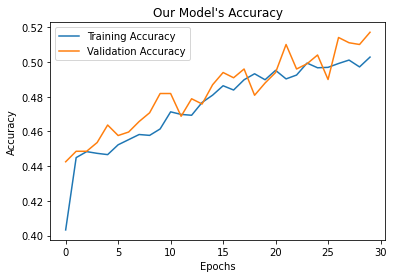

In [22]:
import matplotlib.pyplot as plt

#Plotting accuracies
plt.plot(model_fit.history["accuracy"])
plt.plot(model_fit.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Our Model's Accuracy")
plt.legend(['Training Accuracy', 'Validation Accuracy'])

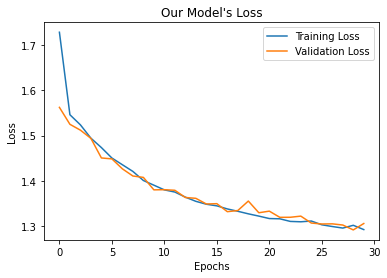

In [23]:
#Plotting Loss
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Our Model's Loss")
plt.legend(['Training Loss', 'Validation Loss'])

In [33]:
predictions = model.predict(test_gen, steps=test_gen.samples//32)

39/39 [==============================] - 9s 234ms/step


In [25]:
#Evaluating our model
model.evaluate(test_gen)

40/40 [==============================] - 12s 302ms/step - loss: 1.2545 - accuracy: 0.5434


[1.2544511556625366, 0.5433932542800903]